# Data Centre Modelling
## Ryan Jenkinson

### Imports

In [85]:
from dataclasses import dataclass

import numpy as np
import pandas as pd
import plotly.express as px
import pypsa
import xarray as xr

In [86]:
np.random.seed(42)  # for reproducibility

### Constants

In [87]:
@dataclass
class Costs:
    capital_cost: float
    marginal_cost: float

### Cost Assumptions

In [103]:
## TODO: Sensitivity analysis for costs
from typing import Literal

cost_scenario: Literal["low", "medium", "high"] = "medium"

## Wind costs
# https://www.gov.uk/government/publications/electricity-generation-costs-2023
# Using 2025 costs
KW_TO_MW = 1000
pre_development_costs_gbp_per_mw = {
    "low": 60 * KW_TO_MW,
    "medium": 130 * KW_TO_MW,
    "high": 200 * KW_TO_MW,
}
construction_costs_gbp_per_mw = {
    "low": 1300 * KW_TO_MW,
    "medium": 1500 * KW_TO_MW,
    "high": 2000 * KW_TO_MW,
}
wind_infrastructure_costs_gbp = {
    "low": 56_000_000,
    "medium": 64_300_000,
    "high": 74_100_000,
}  # TODO: How does this get added into the model? Do we annuitise it? But the other costs are annuitised per MW... :thinking:
wind_insurance = 3000  # £ per MW per year (insurance cost)

wind_capex_per_mw = (
    pre_development_costs_gbp_per_mw[cost_scenario]
    + construction_costs_gbp_per_mw[cost_scenario]
    + wind_insurance
)  # £ per MW
wind_lifetime_years = 30
wind_discount_rate = 0.07
annuitised_wind_cost = (wind_capex_per_mw * wind_discount_rate) / (
    1 - (1 + wind_discount_rate) ** -wind_lifetime_years
)
wind_fixed_opex = 43300  # £ per MW per year (fixed O&M)
wind_variable_operation_and_management_mwh = 1  # £ per MWh_elec (non-fuel variable O&M)

connection_and_use_of_system_charges = 44800  # £ per MW per year (grid connection costs) [NOTE: Not used in model as a microgrid]
WIND_COSTS = Costs(
    capital_cost=annuitised_wind_cost + wind_fixed_opex,  # £ per MW per year
    marginal_cost=0.01,  # £ per MWh (Variable O&M, assumed small)
)

## Gas costs
# Assume OCGT (Open Cycle Gas Turbine) for simplicity.
# Fast Start-Up: Aeroderivative gas turbines, which are derived from jet engine technology, can ramp up to full power in a matter of minutes. This rapid response is crucial to bridge the gap between a utility power outage and the exhaustion of the facility's Uninterruptible Power Supply (UPS) battery backup.
# High Reliability
# Smaller Footprint: Compared to other power generation technologies with similar output, OCGTs have a relatively compact footprint, which is an important consideration for data centers where space can be at a premium.
# Lower Emissions than Diesel
# CCGTs are an alternative for highly efficient for continuous, baseload power generation but they have a much longer start-up time and a significantly larger and more complex footprint so we use OCGT costs here
# https://www.gov.uk/government/publications/electricity-generation-costs-2023

# To decide the costings we use the following methodology:
# Operating Hours: 500 hr vs. 2000 hr --> 500hr is more akin to "backup" generator. 2000hr is equivalent to a standard 8 hour workday every weekday. So we use the 500hr variant
# OCGT 100MW 500 hr -> Logical starting point. Most data centres use 10 x 10MW backups so modelling as a 100MW is a good proxy
# OCGT 299MW 500 hr --> common to model even larger data centres as after 300MW there is much more complicated regulations
# We use the OCGT 100MW

gas_reference_model: Literal["100MW", "299MW"] = (
    "100MW"  # Reference model for gas turbine costs
)

gas_fuel_efficiency = {
    "100MW": 0.34,  # Efficiency of the 100MW OCGT (MWh_elec / MWh_fuel)
    "299MW": 0.35,  # Efficiency of the 299MW OCGT (MWh_elec / MWh_fuel)
}
gas_pre_development_costs_gbp_per_mw = {
    "100MW": {"low": 80 * KW_TO_MW, "medium": 90 * KW_TO_MW, "high": 110 * KW_TO_MW},
    "299MW": {"low": 30 * KW_TO_MW, "medium": 40 * KW_TO_MW, "high": 40 * KW_TO_MW},
}
gas_construction_costs_gbp_per_mw = {
    "100MW": {"low": 600 * KW_TO_MW, "medium": 700 * KW_TO_MW, "high": 900 * KW_TO_MW},
    "299MW": {"low": 300 * KW_TO_MW, "medium": 500 * KW_TO_MW, "high": 800 * KW_TO_MW},
}
gas_infrastructure_costs_gbp = {
    "100MW": {"low": 7_200_000, "medium": 14_400_000, "high": 28_700_000},
    "299MW": {"low": 7_800_000, "medium": 15_500_000, "high": 31_000_000},
}  # TODO: How to add this into the model? Do we annuitise it? But the other costs are annuitised per MW... :thinking:
gas_insurance = {
    "100MW": 2900,  # £ per MW per year (insurance cost for 100MW OCGT)
    "299MW": 1800,  # £ per MW per year (insurance cost for 299MW OCGT)
}
gas_connection_use_of_system_charges = 2700  # NOTE: Not used in model as a microgrid

gas_capex_per_mw = (
    gas_pre_development_costs_gbp_per_mw[gas_reference_model][cost_scenario]
    + gas_construction_costs_gbp_per_mw[gas_reference_model][cost_scenario]
    + gas_insurance[gas_reference_model]
)
gas_lifetime_years = 25
gas_discount_rate = 0.07
annuitised_gas_cost = (gas_capex_per_mw * gas_discount_rate) / (
    1 - (1 + gas_discount_rate) ** -gas_lifetime_years
)
gas_fixed_opex = {
    "100MW": 11300,  # £ per MW per year (fixed O&M for 100MW OCGT)
    "299MW": 7300,  # £ per MW per year (fixed O&M for 299MW OCGT)
}[gas_reference_model]  # Fixed O&M cost based on the reference model
gas_fuel_price_mwh = 60  # £ per MWh_fuel (assumed fuel price) # TODO: Validate
gas_variable_operation_and_management_mwh = {
    "100MW": 2,  # £ per MWh_elec (non-fuel variable O&M for 100MW OCGT)
    "299MW": 1,  # £ per MWh_elec (non-fuel variable O&M for 299MW OCGT)
}[gas_reference_model]
gas_marginal_cost_fuel = (
    gas_fuel_price_mwh / gas_fuel_efficiency[gas_reference_model]
)  # £ per MWh_elec
GAS_COSTS = Costs(
    capital_cost=annuitised_gas_cost + gas_fixed_opex,  # £ per MW per year
    marginal_cost=gas_marginal_cost_fuel
    + gas_variable_operation_and_management_mwh,  # £ per MWh_elec
)

## BESS (Battery Energy Storage System) costs
# https://www.utilitydive.com/news/tariffs-to-spike-power-generation-costs-reports/750133/
# https://www.numberanalytics.com/blog/energy-storage-economics
bess_energy_capex_per_mwh = {
    "low": 140000,  # £ per MWh
    "medium": 170000,  # £ per MWh
    "high": 200000,  # £ per MWh
}
bess_power_capex_per_mw = {
    "low": 450000,  # £ per MW
    "medium": 540000,  # £ per MW
    "high": 630000,  # £ per MW
}
bess_lifetime_years = 15
bess_discount_rate = 0.07

annuitised_bess_energy_cost = (
    bess_energy_capex_per_mwh[cost_scenario] * bess_discount_rate
) / (1 - (1 + bess_discount_rate) ** -bess_lifetime_years)
bess_capital_cost_energy = (
    annuitised_bess_energy_cost  # Cost for energy capacity (Store)
)

annuitised_bess_power_cost = (
    bess_power_capex_per_mw[cost_scenario] * bess_discount_rate
) / (1 - (1 + bess_discount_rate) ** -bess_lifetime_years)
bess_fixed_opex_per_mw_power = 20000  # Fixed OPEX for power conversion part
bess_capital_cost_power = (
    annuitised_bess_power_cost + bess_fixed_opex_per_mw_power
)  # Cost for power capacity (Links)

bess_round_trip_efficiency = 0.87
standing_loss_per_hour = 0.001
bess_marginal_cost_links = 0.001  # Marginal cost for charging/discharging

BESS_COSTS = Costs(
    capital_cost=bess_capital_cost_energy,  # £ per MWh per year
    marginal_cost=0,
)
BESS_LINK_COSTS = Costs(
    capital_cost=bess_capital_cost_power,  # £ per MW per year
    marginal_cost=bess_marginal_cost_links,  # £ per MWh_elec
)
TOTAL_ANNUITISED_INFRASTRUCTURE_COSTS = (
    (wind_infrastructure_costs_gbp[cost_scenario] * wind_discount_rate) / (1 - (1 + wind_discount_rate) ** -wind_lifetime_years)
    + ((gas_infrastructure_costs_gbp[gas_reference_model][cost_scenario] * gas_discount_rate) / (1 - (1 + gas_discount_rate) ** -gas_lifetime_years))
)

In [89]:
# TODO: Put everything relative to this or do a plot that plots this at difference sizes of data centre
DATA_CENTRE_LOAD_MW = 115  # MW, constant demand including PUE

### Wind Availability

In [98]:
wind_data = xr.load_dataset(
    "/Users/katherine.shaw/Desktop/pypsa-eur/resources/profile_39_offwind-dc.nc",
)

In [ ]:

wind_profile_df = wind_data["profile"].to_dataframe().reset_index()

wind_availability_list = wind_profile_df[wind_profile_df["bus"] == "GB2 0"]["profile"].to_numpy()

In [ ]:
wind_availability_list

array([0.85647309, 0.85884475, 0.85858394, ..., 0.41351394, 0.41253353,
       0.48444452])

### Model

In [ ]:
MODEL_TIME_FREQUENCY = pd.Timedelta("1h")  # Time frequency for the model
def gen_model(data_centre_load_mw: float):
    # Define simulation period: a full year, hourly
    snapshots = pd.date_range(
        start="2019-01-01 00:00", end="2019-12-31 23:00", freq=MODEL_TIME_FREQUENCY
    )
    n = pypsa.Network(snapshots=snapshots)

    # --- DEFINE CARRIERS ---
    n.add("Carrier", "AC")  # For AC buses
    n.add("Carrier", "gas", co2_emissions=0.185)  # tCO2/MWh_th, typical for natural gas
    n.add("Carrier", "offshore_wind")
    n.add("Carrier", "battery")  # Carrier for battery components

    # --- DEFINE BUSES ---
    n.add("Bus", "electricity_bus", carrier="AC")
    n.add("Bus", "bess_connection_bus", carrier="AC")

    # --- DEFINE LOAD ---
    # Load (Data Centre): The data centre is modelled as a load with a constant power demand.
    constant_demand_profile = pd.Series(data_centre_load_mw, index=n.snapshots)
    n.add(
        "Load", "data_centre_load", bus="electricity_bus", p_set=constant_demand_profile
    )

    # --- DEFINE GENERATORS ---
    # Generator (Offshore Wind Farm): The offshore wind farm's capacity is extendable.

    wind_availability_pu = pd.Series(wind_availability_list, index=n.snapshots)
    wind_capacity_factor = 0.61  # Target capacity factor for the wind farm
    wind_availability_pu = wind_capacity_factor * (
        wind_availability_pu / wind_availability_pu.mean()
    )
    wind_availability_pu = wind_availability_pu.clip(0, 1)

    n.add(
        "Generator",
        "offshore_wind_farm",
        bus="electricity_bus",
        carrier="offshore_wind",
        p_nom_extendable=True,  # Allow capacity to be extended. To cover what we need to for the data centre load
        capital_cost=WIND_COSTS.capital_cost,
        marginal_cost=WIND_COSTS.marginal_cost,
        p_max_pu=wind_availability_pu,
    )

    # Generator (Gas Turbine Backup): The gas turbine provides backup, and its capacity is also extendable.
    n.add(
        "Generator",
        "gas_turbine",
        bus="electricity_bus",
        carrier="gas",
        p_nom_extendable=True,  # Allow capacity to be extended to cover the data centre load
        committable=False,  # Cannot be both committable and extendable for LOPF capacity optimization. TODO: Check if this is correct
        capital_cost=GAS_COSTS.capital_cost,
        marginal_cost=GAS_COSTS.marginal_cost,
    )

    # --- DEFINE STORAGE (BESS) ---
    # Store component representing the energy capacity of the BESS, and each of the links for charging and discharging.
    n.add(
        "Store",
        "bess_storage",
        bus="bess_connection_bus",
        carrier="battery",
        e_nom_extendable=True,
        e_cyclic=True,
        standing_loss=standing_loss_per_hour,
        capital_cost=BESS_COSTS.capital_cost,
    )
    n.add(
        "Link",
        "bess_charger",
        bus0="electricity_bus",
        bus1="bess_connection_bus",
        carrier="battery",
        p_nom_extendable=True,
        capital_cost=BESS_LINK_COSTS.capital_cost,
        efficiency=bess_round_trip_efficiency**0.5,
        marginal_cost=BESS_LINK_COSTS.marginal_cost,
    )
    n.add(
        "Link",
        "bess_discharger",
        bus0="bess_connection_bus",
        bus1="electricity_bus",
        carrier="battery",
        p_nom_extendable=True,
        capital_cost=0,  # Assuming power CAPEX is fully on charger link, or split if preferred
        efficiency=bess_round_trip_efficiency**0.5,
        marginal_cost=BESS_LINK_COSTS.marginal_cost,
    )

    # --- CONSISTENCY CHECK & SOLVE ---

    # Perform consistency check
    try:
        n.consistency_check()
        print("Network consistency check passed before solving.")
    except Exception as e:
        print(f"Consistency check error before solving: {e}")

    return n

In [108]:
# Ensure you have a solver installed (e.g., cbc, glpk, gurobi)
solver_name = "cbc"  # or 'glpk', 'gurobi', etc.


def solve_model(n: pypsa.Network, solver_name: str, print_results: bool = True):
    """Solve the PyPSA network model using the specified solver.

    Parameters:
    - n: PyPSA Network object
    - solver_name: Name of the solver to use (e.g., 'cbc', 'glpk')
    - print_results: Whether to print the results after solving
    """
    try:
        # Solve the model using the optimize interface, common with linopy backend
        # The `solve_model` method handles the optimization.
        n.optimize(solver_name=solver_name)
        if not print_results:
            return n
        print("Model solved successfully.")

        # --- DISPLAY RESULTS ---
        print("\n--- Optimization Results ---")
        # Objective value is typically stored in n.model.objective after solving with n.optimize
        obj_value = n.model.objective.value
        print(f"Objective Value: {obj_value:.2f} £ (Total Cost)")

        print("\nOptimal Capacities:")
        # Check if components exist in results before trying to access them
        # Optimal capacities are in p_nom_opt (for Generators, Links) and e_nom_opt (for Stores)
        if (
            "offshore_wind_farm" in n.generators.index
            and "p_nom_opt" in n.generators.columns
        ):
            print(
                f"  Offshore Wind Farm (p_nom_opt): {n.generators.loc['offshore_wind_farm', 'p_nom_opt']:.2f} MW"
            )
        if "gas_turbine" in n.generators.index and "p_nom_opt" in n.generators.columns:
            print(
                f"  Gas Turbine (p_nom_opt): {n.generators.loc['gas_turbine', 'p_nom_opt']:.2f} MW"
            )
        if "bess_storage" in n.stores.index and "e_nom_opt" in n.stores.columns:
            print(
                f"  BESS Storage Energy Capacity (e_nom_opt): {n.stores.loc['bess_storage', 'e_nom_opt']:.2f} MWh"
            )
        if "bess_charger" in n.links.index and "p_nom_opt" in n.links.columns:
            print(
                f"  BESS Charger Power Capacity (p_nom_opt): {n.links.loc['bess_charger', 'p_nom_opt']:.2f} MW"
            )
        if "bess_discharger" in n.links.index and "p_nom_opt" in n.links.columns:
            print(
                f"  BESS Discharger Power Capacity (p_nom_opt): {n.links.loc['bess_discharger', 'p_nom_opt']:.2f} MW"
            )

    except Exception as e:
        print(f"An error occurred during model solution or results processing: {e}")
        print("Please ensure you have a compatible solver installed and in your PATH.")
        print("Common solvers: cbc, glpk. You might need to install them.")
        print(
            "Also ensure Linopy (PyPSA's modeling backend) is installed and functioning correctly."
        )
    return n

In [109]:
def get_optimal_capacities(n: pypsa.Network):
    """Get the optimal capacities of the network components after solving."""
    optimal_capacities = {
        "offshore_wind_farm": n.generators.loc["offshore_wind_farm", "p_nom_opt"],
        "gas_turbine": n.generators.loc["gas_turbine", "p_nom_opt"],
        "bess_storage": n.stores.loc["bess_storage", "e_nom_opt"],
        "bess_charger": n.links.loc["bess_charger", "p_nom_opt"],
        "bess_discharger": n.links.loc["bess_discharger", "p_nom_opt"],
    }
    return optimal_capacities


def get_asset_expenditure(n: pypsa.Network):
    stats = n.statistics()
    return {
        "gas": (
            stats.loc[("Generator", "gas"), "Capital Expenditure"]
            + stats.loc[("Generator", "gas"), "Operational Expenditure"]
        ),
        "offshore_wind": (
            stats.loc[("Generator", "offshore_wind"), "Capital Expenditure"]
            + stats.loc[("Generator", "offshore_wind"), "Operational Expenditure"]
        ),
        "battery": (
            stats.loc[("Link", "battery"), "Capital Expenditure"]
            + stats.loc[("Link", "battery"), "Operational Expenditure"]
            + stats.loc[("Store", "battery"), "Capital Expenditure"]
            + stats.loc[("Store", "battery"), "Operational Expenditure"]
        ),
    }

# Sensitivity analysis for different DC loads

In [ ]:
networks = {}
DC_LOADS = [10, 40, 100, 115, 500]  # Different data centre load scenarios in MW

for i, dc_load_value in enumerate(DC_LOADS):
    n = gen_model(data_centre_load_mw=dc_load_value)
    n = solve_model(n, solver_name="gurobi", print_results=False)
    networks[dc_load_value] = n

Network consistency check passed before solving.


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing constraints.:  71%|███████▏  | 10/14 [00:00<00:00, 90.83it/s]

Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 194.23it/s]
INFO:linopy.io: Writing time: 0.3s


Set parameter LicenseID to value 2648928


INFO:gurobipy:Set parameter LicenseID to value 2648928


Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-catq7nyp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-catq7nyp.lp


Reading time = 0.09 seconds


INFO:gurobipy:Reading time = 0.09 seconds


obj: 113885 rows, 52565 columns, 219005 nonzeros


INFO:gurobipy:obj: 113885 rows, 52565 columns, 219005 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:


CPU model: Apple M4 Pro


INFO:gurobipy:CPU model: Apple M4 Pro


Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113885 rows, 52565 columns and 219005 nonzeros


INFO:gurobipy:Optimize a model with 113885 rows, 52565 columns and 219005 nonzeros


Model fingerprint: 0x9ec1ede6


INFO:gurobipy:Model fingerprint: 0x9ec1ede6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-02, 1e+00]


INFO:gurobipy:  Matrix range     [2e-02, 1e+00]


  Objective range  [1e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e-03, 2e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+01, 1e+01]


INFO:gurobipy:  RHS range        [1e+01, 1e+01]


Presolve removed 61325 rows and 8761 columns


INFO:gurobipy:Presolve removed 61325 rows and 8761 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 52560 rows, 43804 columns, 140160 nonzeros


INFO:gurobipy:Presolved: 52560 rows, 43804 columns, 140160 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.051e+05


INFO:gurobipy: AA' NZ     : 1.051e+05


 Factor NZ  : 6.570e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 6.570e+05 (roughly 40 MB of memory)


 Factor Ops : 8.838e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.838e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.19274264e+07  0.00000000e+00  4.12e+01 0.00e+00  5.30e+04     0s


INFO:gurobipy:   0   4.19274264e+07  0.00000000e+00  4.12e+01 0.00e+00  5.30e+04     0s


   1   4.12566632e+07 -9.30730805e+07  2.04e-14 1.71e+02  5.96e+03     0s


INFO:gurobipy:   1   4.12566632e+07 -9.30730805e+07  2.04e-14 1.71e+02  5.96e+03     0s


   2   2.66570307e+07  1.37962488e+06  1.23e-12 7.41e+00  4.86e+02     0s


INFO:gurobipy:   2   2.66570307e+07  1.37962488e+06  1.23e-12 7.41e+00  4.86e+02     0s


   3   1.39493507e+07  3.52166239e+06  4.26e-13 2.16e+00  1.64e+02     0s


INFO:gurobipy:   3   1.39493507e+07  3.52166239e+06  4.26e-13 2.16e+00  1.64e+02     0s


   4   9.03600323e+06  4.98556385e+06  8.67e-13 4.12e-01  5.54e+01     0s


INFO:gurobipy:   4   9.03600323e+06  4.98556385e+06  8.67e-13 4.12e-01  5.54e+01     0s


   5   7.51684138e+06  5.70967085e+06  9.94e-12 1.01e-01  2.38e+01     0s


INFO:gurobipy:   5   7.51684138e+06  5.70967085e+06  9.94e-12 1.01e-01  2.38e+01     0s


   6   7.16892524e+06  5.97162508e+06  7.32e-12 4.07e-02  1.56e+01     0s


INFO:gurobipy:   6   7.16892524e+06  5.97162508e+06  7.32e-12 4.07e-02  1.56e+01     0s


   7   6.89236738e+06  6.06621780e+06  1.14e-11 2.29e-02  1.08e+01     0s


INFO:gurobipy:   7   6.89236738e+06  6.06621780e+06  1.14e-11 2.29e-02  1.08e+01     0s


   8   6.81173919e+06  6.12245628e+06  1.33e-11 1.61e-02  8.97e+00     0s


INFO:gurobipy:   8   6.81173919e+06  6.12245628e+06  1.33e-11 1.61e-02  8.97e+00     0s


   9   6.73455243e+06  6.21045353e+06  1.05e-11 2.12e-02  6.80e+00     0s


INFO:gurobipy:   9   6.73455243e+06  6.21045353e+06  1.05e-11 2.12e-02  6.80e+00     0s


  10   6.66841779e+06  6.26331105e+06  1.98e-11 5.56e-04  5.25e+00     0s


INFO:gurobipy:  10   6.66841779e+06  6.26331105e+06  1.98e-11 5.56e-04  5.25e+00     0s


  11   6.61493603e+06  6.30376494e+06  1.34e-11 1.61e-03  4.03e+00     0s


INFO:gurobipy:  11   6.61493603e+06  6.30376494e+06  1.34e-11 1.61e-03  4.03e+00     0s


  12   6.57468705e+06  6.33789468e+06  5.74e-11 3.44e-03  3.06e+00     0s


INFO:gurobipy:  12   6.57468705e+06  6.33789468e+06  5.74e-11 3.44e-03  3.06e+00     0s


  13   6.55049064e+06  6.37429693e+06  4.37e-11 3.63e-03  2.27e+00     0s


INFO:gurobipy:  13   6.55049064e+06  6.37429693e+06  4.37e-11 3.63e-03  2.27e+00     0s


  14   6.53792262e+06  6.39989232e+06  3.24e-11 2.84e-03  1.78e+00     0s


INFO:gurobipy:  14   6.53792262e+06  6.39989232e+06  3.24e-11 2.84e-03  1.78e+00     0s


  15   6.52290065e+06  6.41564433e+06  3.67e-11 2.26e-03  1.38e+00     0s


INFO:gurobipy:  15   6.52290065e+06  6.41564433e+06  3.67e-11 2.26e-03  1.38e+00     0s


  16   6.51899084e+06  6.42894738e+06  2.85e-11 1.69e-03  1.16e+00     0s


INFO:gurobipy:  16   6.51899084e+06  6.42894738e+06  2.85e-11 1.69e-03  1.16e+00     0s


  17   6.50961280e+06  6.43197331e+06  5.11e-11 9.23e-04  9.98e-01     0s


INFO:gurobipy:  17   6.50961280e+06  6.43197331e+06  5.11e-11 9.23e-04  9.98e-01     0s


  18   6.50658953e+06  6.43514687e+06  4.86e-11 8.78e-04  9.18e-01     0s


INFO:gurobipy:  18   6.50658953e+06  6.43514687e+06  4.86e-11 8.78e-04  9.18e-01     0s


  19   6.50459116e+06  6.43689140e+06  4.36e-11 8.48e-04  8.70e-01     0s


INFO:gurobipy:  19   6.50459116e+06  6.43689140e+06  4.36e-11 8.48e-04  8.70e-01     0s


  20   6.49873321e+06  6.44784880e+06  3.67e-11 5.80e-04  6.53e-01     0s


INFO:gurobipy:  20   6.49873321e+06  6.44784880e+06  3.67e-11 5.80e-04  6.53e-01     0s


  21   6.49561152e+06  6.44936516e+06  3.42e-11 5.52e-04  5.94e-01     0s


INFO:gurobipy:  21   6.49561152e+06  6.44936516e+06  3.42e-11 5.52e-04  5.94e-01     0s


  22   6.49385841e+06  6.45036207e+06  2.87e-11 5.32e-04  5.59e-01     0s


INFO:gurobipy:  22   6.49385841e+06  6.45036207e+06  2.87e-11 5.32e-04  5.59e-01     0s


  23   6.49297804e+06  6.45283504e+06  1.71e-10 4.86e-04  5.15e-01     0s


INFO:gurobipy:  23   6.49297804e+06  6.45283504e+06  1.71e-10 4.86e-04  5.15e-01     0s


  24   6.48957133e+06  6.45568210e+06  1.32e-10 4.35e-04  4.35e-01     0s


INFO:gurobipy:  24   6.48957133e+06  6.45568210e+06  1.32e-10 4.35e-04  4.35e-01     0s


  25   6.48683794e+06  6.46196636e+06  1.52e-10 3.00e-04  3.19e-01     0s


INFO:gurobipy:  25   6.48683794e+06  6.46196636e+06  1.52e-10 3.00e-04  3.19e-01     0s


  26   6.48523269e+06  6.46355894e+06  1.62e-10 9.60e-05  2.78e-01     0s


INFO:gurobipy:  26   6.48523269e+06  6.46355894e+06  1.62e-10 9.60e-05  2.78e-01     0s


  27   6.48417257e+06  6.46489713e+06  1.49e-10 3.21e-09  2.47e-01     0s


INFO:gurobipy:  27   6.48417257e+06  6.46489713e+06  1.49e-10 3.21e-09  2.47e-01     0s


  28   6.48316894e+06  6.46793537e+06  4.02e-10 2.60e-09  1.96e-01     0s


INFO:gurobipy:  28   6.48316894e+06  6.46793537e+06  4.02e-10 2.60e-09  1.96e-01     0s


  29   6.48268223e+06  6.47049626e+06  4.06e-10 2.42e-09  1.56e-01     0s


INFO:gurobipy:  29   6.48268223e+06  6.47049626e+06  4.06e-10 2.42e-09  1.56e-01     0s


  30   6.48247464e+06  6.47123169e+06  4.47e-10 1.60e-09  1.44e-01     0s


INFO:gurobipy:  30   6.48247464e+06  6.47123169e+06  4.47e-10 1.60e-09  1.44e-01     0s


  31   6.48207702e+06  6.47259799e+06  5.11e-10 1.30e-09  1.22e-01     0s


INFO:gurobipy:  31   6.48207702e+06  6.47259799e+06  5.11e-10 1.30e-09  1.22e-01     0s


  32   6.48154292e+06  6.47280780e+06  4.48e-10 1.05e-09  1.12e-01     0s


INFO:gurobipy:  32   6.48154292e+06  6.47280780e+06  4.48e-10 1.05e-09  1.12e-01     0s


  33   6.48127086e+06  6.47398423e+06  7.27e-10 1.98e-09  9.36e-02     0s


INFO:gurobipy:  33   6.48127086e+06  6.47398423e+06  7.27e-10 1.98e-09  9.36e-02     0s


  34   6.48116764e+06  6.47511873e+06  5.44e-10 5.09e-10  7.76e-02     0s


INFO:gurobipy:  34   6.48116764e+06  6.47511873e+06  5.44e-10 5.09e-10  7.76e-02     0s


  35   6.48074157e+06  6.47666161e+06  9.24e-10 1.75e-10  5.24e-02     0s


INFO:gurobipy:  35   6.48074157e+06  6.47666161e+06  9.24e-10 1.75e-10  5.24e-02     0s


  36   6.48045530e+06  6.47806152e+06  2.78e-05 1.16e-10  3.07e-02     0s


INFO:gurobipy:  36   6.48045530e+06  6.47806152e+06  2.78e-05 1.16e-10  3.07e-02     0s


  37   6.48023735e+06  6.47893661e+06  6.03e-05 2.56e-09  1.67e-02     1s


INFO:gurobipy:  37   6.48023735e+06  6.47893661e+06  6.03e-05 2.56e-09  1.67e-02     1s


  38   6.48019986e+06  6.47936722e+06  6.07e-05 3.64e-11  1.07e-02     1s


INFO:gurobipy:  38   6.48019986e+06  6.47936722e+06  6.07e-05 3.64e-11  1.07e-02     1s


  39   6.48019363e+06  6.47954244e+06  6.00e-05 2.04e-10  8.35e-03     1s


INFO:gurobipy:  39   6.48019363e+06  6.47954244e+06  6.00e-05 2.04e-10  8.35e-03     1s


  40   6.48014565e+06  6.47975764e+06  4.75e-05 3.49e-10  4.98e-03     1s


INFO:gurobipy:  40   6.48014565e+06  6.47975764e+06  4.75e-05 3.49e-10  4.98e-03     1s


  41   6.48012704e+06  6.47992092e+06  3.92e-05 4.22e-10  2.64e-03     1s


INFO:gurobipy:  41   6.48012704e+06  6.47992092e+06  3.92e-05 4.22e-10  2.64e-03     1s


  42   6.48011564e+06  6.48001378e+06  2.90e-05 2.98e-10  1.31e-03     1s


INFO:gurobipy:  42   6.48011564e+06  6.48001378e+06  2.90e-05 2.98e-10  1.31e-03     1s


  43   6.48010500e+06  6.48009421e+06  1.37e-05 3.64e-11  1.38e-04     1s


INFO:gurobipy:  43   6.48010500e+06  6.48009421e+06  1.37e-05 3.64e-11  1.38e-04     1s


  44   6.48009870e+06  6.48009753e+06  7.40e-06 1.28e-09  1.49e-05     1s


INFO:gurobipy:  44   6.48009870e+06  6.48009753e+06  7.40e-06 1.28e-09  1.49e-05     1s


  45   6.48009842e+06  6.48009795e+06  3.22e-06 1.57e-09  5.90e-06     1s


INFO:gurobipy:  45   6.48009842e+06  6.48009795e+06  3.22e-06 1.57e-09  5.90e-06     1s


  46   6.48009824e+06  6.48009811e+06  8.17e-07 7.20e-10  1.62e-06     1s


INFO:gurobipy:  46   6.48009824e+06  6.48009811e+06  8.17e-07 7.20e-10  1.62e-06     1s


  47   6.48009819e+06  6.48009815e+06  1.36e-07 6.98e-10  4.59e-07     1s


INFO:gurobipy:  47   6.48009819e+06  6.48009815e+06  1.36e-07 6.98e-10  4.59e-07     1s


  48   6.48009818e+06  6.48009816e+06  8.33e-08 1.16e-09  2.50e-07     1s


INFO:gurobipy:  48   6.48009818e+06  6.48009816e+06  8.33e-08 1.16e-09  2.50e-07     1s


INFO:gurobipy:


Barrier solved model in 48 iterations and 0.64 seconds (1.25 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 0.64 seconds (1.25 work units)


Optimal objective 6.48009818e+06


INFO:gurobipy:Optimal objective 6.48009818e+06


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2521 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    2521 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


   11113 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:   11113 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 5.6510118e-02      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 5.6510118e-02      1s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13637    6.4800982e+06   0.000000e+00   5.651012e-02      1s


INFO:gurobipy:   13637    6.4800982e+06   0.000000e+00   5.651012e-02      1s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


   13721    6.4800982e+06   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   13721    6.4800982e+06   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 13721 iterations and 0.78 seconds (1.35 work units)


INFO:gurobipy:Solved in 13721 iterations and 0.78 seconds (1.35 work units)


Optimal objective  6.480098169e+06


INFO:gurobipy:Optimal objective  6.480098169e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52565 primals, 113885 duals
Objective: 6.48e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


Network consistency check passed before solving.


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 178.31it/s]
INFO:linopy.io: Writing time: 0.29s


Set parameter LicenseID to value 2648928


INFO:gurobipy:Set parameter LicenseID to value 2648928


Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-4vr14kqi.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-4vr14kqi.lp


Reading time = 0.08 seconds


INFO:gurobipy:Reading time = 0.08 seconds


obj: 113885 rows, 52565 columns, 219005 nonzeros


INFO:gurobipy:obj: 113885 rows, 52565 columns, 219005 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:


CPU model: Apple M4 Pro


INFO:gurobipy:CPU model: Apple M4 Pro


Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113885 rows, 52565 columns and 219005 nonzeros


INFO:gurobipy:Optimize a model with 113885 rows, 52565 columns and 219005 nonzeros


Model fingerprint: 0xa6f247bb


INFO:gurobipy:Model fingerprint: 0xa6f247bb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-02, 1e+00]


INFO:gurobipy:  Matrix range     [2e-02, 1e+00]


  Objective range  [1e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e-03, 2e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+01, 4e+01]


INFO:gurobipy:  RHS range        [4e+01, 4e+01]


Presolve removed 61325 rows and 8761 columns


INFO:gurobipy:Presolve removed 61325 rows and 8761 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 52560 rows, 43804 columns, 140160 nonzeros


INFO:gurobipy:Presolved: 52560 rows, 43804 columns, 140160 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.051e+05


INFO:gurobipy: AA' NZ     : 1.051e+05


 Factor NZ  : 6.570e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 6.570e+05 (roughly 40 MB of memory)


 Factor Ops : 8.838e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.838e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.67709705e+08  0.00000000e+00  1.65e+02 0.00e+00  2.12e+05     0s


INFO:gurobipy:   0   1.67709705e+08  0.00000000e+00  1.65e+02 0.00e+00  2.12e+05     0s


   1   1.65026653e+08 -3.72292322e+08  8.17e-14 1.71e+02  2.39e+04     0s


INFO:gurobipy:   1   1.65026653e+08 -3.72292322e+08  8.17e-14 1.71e+02  2.39e+04     0s


   2   1.06628123e+08  5.51849954e+06  4.92e-12 7.41e+00  1.94e+03     0s


INFO:gurobipy:   2   1.06628123e+08  5.51849954e+06  4.92e-12 7.41e+00  1.94e+03     0s


   3   5.57974029e+07  1.40866496e+07  1.71e-12 2.16e+00  6.55e+02     0s


INFO:gurobipy:   3   5.57974029e+07  1.40866496e+07  1.71e-12 2.16e+00  6.55e+02     0s


   4   3.61440129e+07  1.99422554e+07  3.47e-12 4.12e-01  2.22e+02     0s


INFO:gurobipy:   4   3.61440129e+07  1.99422554e+07  3.47e-12 4.12e-01  2.22e+02     0s


   5   3.00673655e+07  2.28386834e+07  3.97e-11 1.01e-01  9.52e+01     0s


INFO:gurobipy:   5   3.00673655e+07  2.28386834e+07  3.97e-11 1.01e-01  9.52e+01     0s


   6   2.86757010e+07  2.38865003e+07  2.93e-11 4.07e-02  6.25e+01     0s


INFO:gurobipy:   6   2.86757010e+07  2.38865003e+07  2.93e-11 4.07e-02  6.25e+01     0s


   7   2.75694695e+07  2.42648712e+07  4.54e-11 2.29e-02  4.30e+01     0s


INFO:gurobipy:   7   2.75694695e+07  2.42648712e+07  4.54e-11 2.29e-02  4.30e+01     0s


   8   2.72469567e+07  2.44898251e+07  5.31e-11 1.61e-02  3.59e+01     0s


INFO:gurobipy:   8   2.72469567e+07  2.44898251e+07  5.31e-11 1.61e-02  3.59e+01     0s


   9   2.69382097e+07  2.48418141e+07  4.20e-11 2.12e-02  2.72e+01     0s


INFO:gurobipy:   9   2.69382097e+07  2.48418141e+07  4.20e-11 2.12e-02  2.72e+01     0s


  10   2.66736712e+07  2.50532442e+07  7.91e-11 5.56e-04  2.10e+01     0s


INFO:gurobipy:  10   2.66736712e+07  2.50532442e+07  7.91e-11 5.56e-04  2.10e+01     0s


  11   2.64597441e+07  2.52150598e+07  5.38e-11 1.61e-03  1.61e+01     0s


INFO:gurobipy:  11   2.64597441e+07  2.52150598e+07  5.38e-11 1.61e-03  1.61e+01     0s


  12   2.62987482e+07  2.53515787e+07  2.29e-10 3.44e-03  1.22e+01     0s


INFO:gurobipy:  12   2.62987482e+07  2.53515787e+07  2.29e-10 3.44e-03  1.22e+01     0s


  13   2.62019625e+07  2.54971877e+07  1.75e-10 3.63e-03  9.09e+00     0s


INFO:gurobipy:  13   2.62019625e+07  2.54971877e+07  1.75e-10 3.63e-03  9.09e+00     0s


  14   2.61516905e+07  2.55995693e+07  1.30e-10 2.84e-03  7.11e+00     0s


INFO:gurobipy:  14   2.61516905e+07  2.55995693e+07  1.30e-10 2.84e-03  7.11e+00     0s


  15   2.60916026e+07  2.56625773e+07  1.47e-10 2.26e-03  5.52e+00     0s


INFO:gurobipy:  15   2.60916026e+07  2.56625773e+07  1.47e-10 2.26e-03  5.52e+00     0s


  16   2.60759633e+07  2.57157895e+07  1.14e-10 1.69e-03  4.63e+00     0s


INFO:gurobipy:  16   2.60759633e+07  2.57157895e+07  1.14e-10 1.69e-03  4.63e+00     0s


  17   2.60384512e+07  2.57278932e+07  2.04e-10 9.23e-04  3.99e+00     0s


INFO:gurobipy:  17   2.60384512e+07  2.57278932e+07  2.04e-10 9.23e-04  3.99e+00     0s


  18   2.60263581e+07  2.57405875e+07  1.94e-10 8.78e-04  3.67e+00     0s


INFO:gurobipy:  18   2.60263581e+07  2.57405875e+07  1.94e-10 8.78e-04  3.67e+00     0s


  19   2.60183647e+07  2.57475656e+07  1.74e-10 8.48e-04  3.48e+00     0s


INFO:gurobipy:  19   2.60183647e+07  2.57475656e+07  1.74e-10 8.48e-04  3.48e+00     0s


  20   2.59949328e+07  2.57913952e+07  1.47e-10 5.80e-04  2.61e+00     0s


INFO:gurobipy:  20   2.59949328e+07  2.57913952e+07  1.47e-10 5.80e-04  2.61e+00     0s


  21   2.59824461e+07  2.57974606e+07  1.37e-10 5.52e-04  2.37e+00     0s


INFO:gurobipy:  21   2.59824461e+07  2.57974606e+07  1.37e-10 5.52e-04  2.37e+00     0s


  22   2.59754336e+07  2.58014483e+07  1.15e-10 5.32e-04  2.23e+00     0s


INFO:gurobipy:  22   2.59754336e+07  2.58014483e+07  1.15e-10 5.32e-04  2.23e+00     0s


  23   2.59719122e+07  2.58113402e+07  6.86e-10 4.86e-04  2.06e+00     0s


INFO:gurobipy:  23   2.59719122e+07  2.58113402e+07  6.86e-10 4.86e-04  2.06e+00     0s


  24   2.59582853e+07  2.58227284e+07  5.28e-10 4.35e-04  1.74e+00     0s


INFO:gurobipy:  24   2.59582853e+07  2.58227284e+07  5.28e-10 4.35e-04  1.74e+00     0s


  25   2.59473518e+07  2.58478655e+07  6.07e-10 3.00e-04  1.28e+00     0s


INFO:gurobipy:  25   2.59473518e+07  2.58478655e+07  6.07e-10 3.00e-04  1.28e+00     0s


  26   2.59409308e+07  2.58542358e+07  6.48e-10 9.60e-05  1.11e+00     0s


INFO:gurobipy:  26   2.59409308e+07  2.58542358e+07  6.48e-10 9.60e-05  1.11e+00     0s


  27   2.59366903e+07  2.58595885e+07  5.94e-10 3.21e-09  9.90e-01     0s


INFO:gurobipy:  27   2.59366903e+07  2.58595885e+07  5.94e-10 3.21e-09  9.90e-01     0s


  28   2.59326757e+07  2.58717415e+07  1.61e-09 2.60e-09  7.82e-01     0s


INFO:gurobipy:  28   2.59326757e+07  2.58717415e+07  1.61e-09 2.60e-09  7.82e-01     0s


  29   2.59307289e+07  2.58819850e+07  1.62e-09 2.42e-09  6.26e-01     0s


INFO:gurobipy:  29   2.59307289e+07  2.58819850e+07  1.62e-09 2.42e-09  6.26e-01     0s


  30   2.59298986e+07  2.58849268e+07  1.79e-09 1.60e-09  5.77e-01     0s


INFO:gurobipy:  30   2.59298986e+07  2.58849268e+07  1.79e-09 1.60e-09  5.77e-01     0s


  31   2.59283081e+07  2.58903920e+07  2.05e-09 1.30e-09  4.87e-01     0s


INFO:gurobipy:  31   2.59283081e+07  2.58903920e+07  2.05e-09 1.30e-09  4.87e-01     0s


  32   2.59261717e+07  2.58912312e+07  1.79e-09 1.05e-09  4.49e-01     0s


INFO:gurobipy:  32   2.59261717e+07  2.58912312e+07  1.79e-09 1.05e-09  4.49e-01     0s


  33   2.59250834e+07  2.58959369e+07  2.91e-09 1.98e-09  3.74e-01     0s


INFO:gurobipy:  33   2.59250834e+07  2.58959369e+07  2.91e-09 1.98e-09  3.74e-01     0s


  34   2.59246706e+07  2.59004749e+07  2.17e-09 5.09e-10  3.11e-01     0s


INFO:gurobipy:  34   2.59246706e+07  2.59004749e+07  2.17e-09 5.09e-10  3.11e-01     0s


  35   2.59229663e+07  2.59066464e+07  3.70e-09 1.75e-10  2.09e-01     0s


INFO:gurobipy:  35   2.59229663e+07  2.59066464e+07  3.70e-09 1.75e-10  2.09e-01     0s


  36   2.59218217e+07  2.59122465e+07  1.63e-09 1.40e-09  1.23e-01     0s


INFO:gurobipy:  36   2.59218217e+07  2.59122465e+07  1.63e-09 1.40e-09  1.23e-01     0s


  37   2.59209497e+07  2.59157162e+07  1.72e-09 1.50e-09  6.72e-02     0s


INFO:gurobipy:  37   2.59209497e+07  2.59157162e+07  1.72e-09 1.50e-09  6.72e-02     0s


  38   2.59208006e+07  2.59174410e+07  1.21e-05 1.46e-09  4.31e-02     0s


INFO:gurobipy:  38   2.59208006e+07  2.59174410e+07  1.21e-05 1.46e-09  4.31e-02     0s


  39   2.59207762e+07  2.59180473e+07  1.42e-05 1.46e-09  3.50e-02     0s


INFO:gurobipy:  39   2.59207762e+07  2.59180473e+07  1.42e-05 1.46e-09  3.50e-02     0s


  40   2.59205847e+07  2.59192648e+07  2.25e-05 1.31e-10  1.69e-02     0s


INFO:gurobipy:  40   2.59205847e+07  2.59192648e+07  2.25e-05 1.31e-10  1.69e-02     0s


  41   2.59204954e+07  2.59198411e+07  2.17e-05 5.89e-10  8.38e-03     0s


INFO:gurobipy:  41   2.59204954e+07  2.59198411e+07  2.17e-05 5.89e-10  8.38e-03     0s


  42   2.59204678e+07  2.59199760e+07  1.87e-05 1.46e-09  6.30e-03     0s


INFO:gurobipy:  42   2.59204678e+07  2.59199760e+07  1.87e-05 1.46e-09  6.30e-03     0s


  43   2.59204218e+07  2.59202386e+07  1.12e-05 2.11e-10  2.35e-03     0s


INFO:gurobipy:  43   2.59204218e+07  2.59202386e+07  1.12e-05 2.11e-10  2.35e-03     0s


  44   2.59204014e+07  2.59203645e+07  3.89e-06 3.57e-10  4.72e-04     1s


INFO:gurobipy:  44   2.59204014e+07  2.59203645e+07  3.89e-06 3.57e-10  4.72e-04     1s


  45   2.59203944e+07  2.59203875e+07  9.97e-07 1.22e-09  8.85e-05     1s


INFO:gurobipy:  45   2.59203944e+07  2.59203875e+07  9.97e-07 1.22e-09  8.85e-05     1s


  46   2.59203931e+07  2.59203919e+07  8.78e-07 0.00e+00  1.57e-05     1s


INFO:gurobipy:  46   2.59203931e+07  2.59203919e+07  8.78e-07 0.00e+00  1.57e-05     1s


  47   2.59203928e+07  2.59203925e+07  2.98e-07 3.49e-10  3.66e-06     1s


INFO:gurobipy:  47   2.59203928e+07  2.59203925e+07  2.98e-07 3.49e-10  3.66e-06     1s


  48   2.59203927e+07  2.59203926e+07  1.14e-07 9.31e-10  1.42e-06     1s


INFO:gurobipy:  48   2.59203927e+07  2.59203926e+07  1.14e-07 9.31e-10  1.42e-06     1s


  49   2.59203927e+07  2.59203926e+07  8.04e-08 3.27e-10  9.82e-07     1s


INFO:gurobipy:  49   2.59203927e+07  2.59203926e+07  8.04e-08 3.27e-10  9.82e-07     1s


INFO:gurobipy:


Barrier solved model in 49 iterations and 0.58 seconds (1.25 work units)


INFO:gurobipy:Barrier solved model in 49 iterations and 0.58 seconds (1.25 work units)


Optimal objective 2.59203927e+07


INFO:gurobipy:Optimal objective 2.59203927e+07


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2523 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    2523 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


   11310 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:   11310 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.4404424e-02      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.4404424e-02      1s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13836    2.5920393e+07   0.000000e+00   4.440442e-02      1s


INFO:gurobipy:   13836    2.5920393e+07   0.000000e+00   4.440442e-02      1s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


   13891    2.5920393e+07   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   13891    2.5920393e+07   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 13891 iterations and 0.65 seconds (1.35 work units)


INFO:gurobipy:Solved in 13891 iterations and 0.65 seconds (1.35 work units)


Optimal objective  2.592039268e+07


INFO:gurobipy:Optimal objective  2.592039268e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52565 primals, 113885 duals
Objective: 2.59e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


Network consistency check passed before solving.


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 185.18it/s]
INFO:linopy.io: Writing time: 0.3s


Set parameter LicenseID to value 2648928


INFO:gurobipy:Set parameter LicenseID to value 2648928


Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-wnp6jsuo.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-wnp6jsuo.lp


Reading time = 0.09 seconds


INFO:gurobipy:Reading time = 0.09 seconds


obj: 113885 rows, 52565 columns, 219005 nonzeros


INFO:gurobipy:obj: 113885 rows, 52565 columns, 219005 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:


CPU model: Apple M4 Pro


INFO:gurobipy:CPU model: Apple M4 Pro


Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113885 rows, 52565 columns and 219005 nonzeros


INFO:gurobipy:Optimize a model with 113885 rows, 52565 columns and 219005 nonzeros


Model fingerprint: 0xed4bfc15


INFO:gurobipy:Model fingerprint: 0xed4bfc15


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-02, 1e+00]


INFO:gurobipy:  Matrix range     [2e-02, 1e+00]


  Objective range  [1e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e-03, 2e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+02, 1e+02]


INFO:gurobipy:  RHS range        [1e+02, 1e+02]


Presolve removed 61325 rows and 8761 columns


INFO:gurobipy:Presolve removed 61325 rows and 8761 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 52560 rows, 43804 columns, 140160 nonzeros


INFO:gurobipy:Presolved: 52560 rows, 43804 columns, 140160 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.051e+05


INFO:gurobipy: AA' NZ     : 1.051e+05


 Factor NZ  : 6.570e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 6.570e+05 (roughly 40 MB of memory)


 Factor Ops : 8.838e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.838e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.19274264e+08  0.00000000e+00  4.12e+02 0.00e+00  5.30e+05     0s


INFO:gurobipy:   0   4.19274264e+08  0.00000000e+00  4.12e+02 0.00e+00  5.30e+05     0s


   1   4.12566632e+08 -9.30730805e+08  1.99e-13 1.71e+02  5.96e+04     0s


INFO:gurobipy:   1   4.12566632e+08 -9.30730805e+08  1.99e-13 1.71e+02  5.96e+04     0s


   2   2.66570307e+08  1.37962488e+07  1.26e-11 7.41e+00  4.86e+03     0s


INFO:gurobipy:   2   2.66570307e+08  1.37962488e+07  1.26e-11 7.41e+00  4.86e+03     0s


   3   1.39493507e+08  3.52166239e+07  4.48e-12 2.16e+00  1.64e+03     0s


INFO:gurobipy:   3   1.39493507e+08  3.52166239e+07  4.48e-12 2.16e+00  1.64e+03     0s


   4   9.03600323e+07  4.98556385e+07  2.89e-11 4.12e-01  5.54e+02     0s


INFO:gurobipy:   4   9.03600323e+07  4.98556385e+07  2.89e-11 4.12e-01  5.54e+02     0s


   5   7.51684138e+07  5.70967085e+07  5.75e-11 1.01e-01  2.38e+02     0s


INFO:gurobipy:   5   7.51684138e+07  5.70967085e+07  5.75e-11 1.01e-01  2.38e+02     0s


   6   7.16892524e+07  5.97162508e+07  5.44e-11 4.07e-02  1.56e+02     0s


INFO:gurobipy:   6   7.16892524e+07  5.97162508e+07  5.44e-11 4.07e-02  1.56e+02     0s


   7   6.89236738e+07  6.06621780e+07  1.49e-10 2.29e-02  1.08e+02     0s


INFO:gurobipy:   7   6.89236738e+07  6.06621780e+07  1.49e-10 2.29e-02  1.08e+02     0s


   8   6.81173919e+07  6.12245628e+07  1.35e-10 1.61e-02  8.97e+01     0s


INFO:gurobipy:   8   6.81173919e+07  6.12245628e+07  1.35e-10 1.61e-02  8.97e+01     0s


   9   6.73455243e+07  6.21045353e+07  1.25e-10 2.12e-02  6.80e+01     0s


INFO:gurobipy:   9   6.73455243e+07  6.21045353e+07  1.25e-10 2.12e-02  6.80e+01     0s


  10   6.66841779e+07  6.26331105e+07  2.91e-10 5.56e-04  5.25e+01     0s


INFO:gurobipy:  10   6.66841779e+07  6.26331105e+07  2.91e-10 5.56e-04  5.25e+01     0s


  11   6.61493603e+07  6.30376494e+07  3.52e-10 1.61e-03  4.03e+01     0s


INFO:gurobipy:  11   6.61493603e+07  6.30376494e+07  3.52e-10 1.61e-03  4.03e+01     0s


  12   6.57468705e+07  6.33789468e+07  6.55e-10 3.44e-03  3.06e+01     0s


INFO:gurobipy:  12   6.57468705e+07  6.33789468e+07  6.55e-10 3.44e-03  3.06e+01     0s


  13   6.55049064e+07  6.37429693e+07  5.03e-10 3.63e-03  2.27e+01     0s


INFO:gurobipy:  13   6.55049064e+07  6.37429693e+07  5.03e-10 3.63e-03  2.27e+01     0s


  14   6.53792262e+07  6.39989232e+07  4.70e-10 2.84e-03  1.78e+01     0s


INFO:gurobipy:  14   6.53792262e+07  6.39989232e+07  4.70e-10 2.84e-03  1.78e+01     0s


  15   6.52290065e+07  6.41564433e+07  4.19e-10 2.26e-03  1.38e+01     0s


INFO:gurobipy:  15   6.52290065e+07  6.41564433e+07  4.19e-10 2.26e-03  1.38e+01     0s


  16   6.51899084e+07  6.42894738e+07  5.81e-10 1.69e-03  1.16e+01     0s


INFO:gurobipy:  16   6.51899084e+07  6.42894738e+07  5.81e-10 1.69e-03  1.16e+01     0s


  17   6.50961280e+07  6.43197331e+07  3.60e-10 9.23e-04  9.98e+00     0s


INFO:gurobipy:  17   6.50961280e+07  6.43197331e+07  3.60e-10 9.23e-04  9.98e+00     0s


  18   6.50658953e+07  6.43514687e+07  3.35e-10 8.78e-04  9.18e+00     0s


INFO:gurobipy:  18   6.50658953e+07  6.43514687e+07  3.35e-10 8.78e-04  9.18e+00     0s


  19   6.50459116e+07  6.43689140e+07  4.92e-10 8.48e-04  8.70e+00     0s


INFO:gurobipy:  19   6.50459116e+07  6.43689140e+07  4.92e-10 8.48e-04  8.70e+00     0s


  20   6.49873321e+07  6.44784880e+07  4.04e-10 5.80e-04  6.53e+00     0s


INFO:gurobipy:  20   6.49873321e+07  6.44784880e+07  4.04e-10 5.80e-04  6.53e+00     0s


  21   6.49561152e+07  6.44936516e+07  3.11e-10 5.52e-04  5.94e+00     0s


INFO:gurobipy:  21   6.49561152e+07  6.44936516e+07  3.11e-10 5.52e-04  5.94e+00     0s


  22   6.49385841e+07  6.45036207e+07  4.79e-10 5.32e-04  5.59e+00     0s


INFO:gurobipy:  22   6.49385841e+07  6.45036207e+07  4.79e-10 5.32e-04  5.59e+00     0s


  23   6.49297804e+07  6.45283504e+07  7.25e-10 4.86e-04  5.15e+00     0s


INFO:gurobipy:  23   6.49297804e+07  6.45283504e+07  7.25e-10 4.86e-04  5.15e+00     0s


  24   6.48957133e+07  6.45568209e+07  4.58e-10 4.35e-04  4.35e+00     0s


INFO:gurobipy:  24   6.48957133e+07  6.45568209e+07  4.58e-10 4.35e-04  4.35e+00     0s


  25   6.48683794e+07  6.46196636e+07  1.91e-09 3.00e-04  3.19e+00     0s


INFO:gurobipy:  25   6.48683794e+07  6.46196636e+07  1.91e-09 3.00e-04  3.19e+00     0s


  26   6.48523269e+07  6.46355894e+07  1.34e-09 9.60e-05  2.78e+00     0s


INFO:gurobipy:  26   6.48523269e+07  6.46355894e+07  1.34e-09 9.60e-05  2.78e+00     0s


  27   6.48417257e+07  6.46489713e+07  1.30e-09 4.83e-09  2.47e+00     0s


INFO:gurobipy:  27   6.48417257e+07  6.46489713e+07  1.30e-09 4.83e-09  2.47e+00     0s


  28   6.48316894e+07  6.46793538e+07  2.07e-09 4.02e-09  1.96e+00     0s


INFO:gurobipy:  28   6.48316894e+07  6.46793538e+07  2.07e-09 4.02e-09  1.96e+00     0s


  29   6.48268223e+07  6.47049627e+07  2.24e-09 3.36e-09  1.56e+00     0s


INFO:gurobipy:  29   6.48268223e+07  6.47049627e+07  2.24e-09 3.36e-09  1.56e+00     0s


  30   6.48247464e+07  6.47123164e+07  1.79e-09 2.62e-09  1.44e+00     0s


INFO:gurobipy:  30   6.48247464e+07  6.47123164e+07  1.79e-09 2.62e-09  1.44e+00     0s


  31   6.48207701e+07  6.47259794e+07  2.35e-09 2.00e-09  1.22e+00     0s


INFO:gurobipy:  31   6.48207701e+07  6.47259794e+07  2.35e-09 2.00e-09  1.22e+00     0s


  32   6.48154279e+07  6.47280777e+07  6.20e-09 2.16e-09  1.12e+00     0s


INFO:gurobipy:  32   6.48154279e+07  6.47280777e+07  6.20e-09 2.16e-09  1.12e+00     0s


  33   6.48127074e+07  6.47398410e+07  4.83e-09 1.38e-09  9.36e-01     0s


INFO:gurobipy:  33   6.48127074e+07  6.47398410e+07  4.83e-09 1.38e-09  9.36e-01     0s


  34   6.48116763e+07  6.47511878e+07  4.89e-09 1.16e-09  7.76e-01     0s


INFO:gurobipy:  34   6.48116763e+07  6.47511878e+07  4.89e-09 1.16e-09  7.76e-01     0s


  35   6.48074175e+07  6.47666152e+07  3.68e-09 1.06e-09  5.24e-01     0s


INFO:gurobipy:  35   6.48074175e+07  6.47666152e+07  3.68e-09 1.06e-09  5.24e-01     0s


  36   6.48045545e+07  6.47806390e+07  3.10e-09 2.15e-09  3.07e-01     0s


INFO:gurobipy:  36   6.48045545e+07  6.47806390e+07  3.10e-09 2.15e-09  3.07e-01     0s


  37   6.48023893e+07  6.47888915e+07  4.28e-09 2.50e-09  1.73e-01     0s


INFO:gurobipy:  37   6.48023893e+07  6.47888915e+07  4.28e-09 2.50e-09  1.73e-01     0s


  38   6.48020046e+07  6.47931989e+07  6.30e-07 2.30e-09  1.13e-01     0s


INFO:gurobipy:  38   6.48020046e+07  6.47931989e+07  6.30e-07 2.30e-09  1.13e-01     0s


  39   6.48019600e+07  6.47946688e+07  1.64e-06 1.55e-09  9.35e-02     0s


INFO:gurobipy:  39   6.48019600e+07  6.47946688e+07  1.64e-06 1.55e-09  9.35e-02     0s


  40   6.48014652e+07  6.47968137e+07  9.05e-06 8.73e-10  5.97e-02     0s


INFO:gurobipy:  40   6.48014652e+07  6.47968137e+07  9.05e-06 8.73e-10  5.97e-02     0s


  41   6.48012106e+07  6.47986894e+07  1.80e-05 2.74e-09  3.23e-02     0s


INFO:gurobipy:  41   6.48012106e+07  6.47986894e+07  1.80e-05 2.74e-09  3.23e-02     0s


  42   6.48010787e+07  6.47996596e+07  1.71e-05 2.24e-09  1.82e-02     0s


INFO:gurobipy:  42   6.48010787e+07  6.47996596e+07  1.71e-05 2.24e-09  1.82e-02     0s


  43   6.48010252e+07  6.48006963e+07  1.17e-05 8.59e-10  4.21e-03     0s


INFO:gurobipy:  43   6.48010252e+07  6.48006963e+07  1.17e-05 8.59e-10  4.21e-03     0s


  44   6.48009918e+07  6.48009602e+07  2.76e-06 1.30e-09  4.05e-04     0s


INFO:gurobipy:  44   6.48009918e+07  6.48009602e+07  2.76e-06 1.30e-09  4.05e-04     0s


  45   6.48009837e+07  6.48009772e+07  1.25e-06 1.31e-10  8.39e-05     0s


INFO:gurobipy:  45   6.48009837e+07  6.48009772e+07  1.25e-06 1.31e-10  8.39e-05     0s


  46   6.48009822e+07  6.48009801e+07  3.94e-07 2.91e-10  2.74e-05     1s


INFO:gurobipy:  46   6.48009822e+07  6.48009801e+07  3.94e-07 2.91e-10  2.74e-05     1s


  47   6.48009820e+07  6.48009812e+07  2.04e-07 3.35e-10  9.10e-06     1s


INFO:gurobipy:  47   6.48009820e+07  6.48009812e+07  2.04e-07 3.35e-10  9.10e-06     1s


  48   6.48009818e+07  6.48009815e+07  1.04e-07 2.91e-10  4.50e-06     1s


INFO:gurobipy:  48   6.48009818e+07  6.48009815e+07  1.04e-07 2.91e-10  4.50e-06     1s


  49   6.48009818e+07  6.48009816e+07  5.95e-08 8.44e-10  2.47e-06     1s


INFO:gurobipy:  49   6.48009818e+07  6.48009816e+07  5.95e-08 8.44e-10  2.47e-06     1s


INFO:gurobipy:


Barrier solved model in 49 iterations and 0.54 seconds (1.25 work units)


INFO:gurobipy:Barrier solved model in 49 iterations and 0.54 seconds (1.25 work units)


Optimal objective 6.48009818e+07


INFO:gurobipy:Optimal objective 6.48009818e+07


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2523 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    2523 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


   11789 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:   11789 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.0162055e-02      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.0162055e-02      1s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   14315    6.4800982e+07   0.000000e+00   4.016205e-02      1s


INFO:gurobipy:   14315    6.4800982e+07   0.000000e+00   4.016205e-02      1s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


   14394    6.4800982e+07   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   14394    6.4800982e+07   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 14394 iterations and 0.61 seconds (1.35 work units)


INFO:gurobipy:Solved in 14394 iterations and 0.61 seconds (1.35 work units)


Optimal objective  6.480098169e+07


INFO:gurobipy:Optimal objective  6.480098169e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52565 primals, 113885 duals
Objective: 6.48e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Network consistency check passed before solving.


INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 188.59it/s]
INFO:linopy.io: Writing time: 0.26s


Set parameter LicenseID to value 2648928


INFO:gurobipy:Set parameter LicenseID to value 2648928


Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-br_3ozoc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-br_3ozoc.lp


Reading time = 0.08 seconds


INFO:gurobipy:Reading time = 0.08 seconds


obj: 113885 rows, 52565 columns, 219005 nonzeros


INFO:gurobipy:obj: 113885 rows, 52565 columns, 219005 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:


CPU model: Apple M4 Pro


INFO:gurobipy:CPU model: Apple M4 Pro


Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113885 rows, 52565 columns and 219005 nonzeros


INFO:gurobipy:Optimize a model with 113885 rows, 52565 columns and 219005 nonzeros


Model fingerprint: 0xbfe2c7f0


INFO:gurobipy:Model fingerprint: 0xbfe2c7f0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-02, 1e+00]


INFO:gurobipy:  Matrix range     [2e-02, 1e+00]


  Objective range  [1e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e-03, 2e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+02, 1e+02]


INFO:gurobipy:  RHS range        [1e+02, 1e+02]


Presolve removed 61325 rows and 8761 columns


INFO:gurobipy:Presolve removed 61325 rows and 8761 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 52560 rows, 43804 columns, 140160 nonzeros


INFO:gurobipy:Presolved: 52560 rows, 43804 columns, 140160 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.051e+05


INFO:gurobipy: AA' NZ     : 1.051e+05


 Factor NZ  : 6.570e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 6.570e+05 (roughly 40 MB of memory)


 Factor Ops : 8.838e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.838e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.82165403e+08  0.00000000e+00  4.74e+02 0.00e+00  6.10e+05     0s


INFO:gurobipy:   0   4.82165403e+08  0.00000000e+00  4.74e+02 0.00e+00  6.10e+05     0s


   1   4.74451627e+08 -1.07034043e+09  2.27e-13 1.71e+02  6.86e+04     0s


INFO:gurobipy:   1   4.74451627e+08 -1.07034043e+09  2.27e-13 1.71e+02  6.86e+04     0s


   2   3.06555853e+08  1.58656862e+07  1.47e-11 7.41e+00  5.59e+03     0s


INFO:gurobipy:   2   3.06555853e+08  1.58656862e+07  1.47e-11 7.41e+00  5.59e+03     0s


   3   1.60417533e+08  4.04991175e+07  5.14e-12 2.16e+00  1.88e+03     0s


INFO:gurobipy:   3   1.60417533e+08  4.04991175e+07  5.14e-12 2.16e+00  1.88e+03     0s


   4   1.03914037e+08  5.73339843e+07  2.58e-11 4.12e-01  6.37e+02     0s


INFO:gurobipy:   4   1.03914037e+08  5.73339843e+07  2.58e-11 4.12e-01  6.37e+02     0s


   5   8.64436758e+07  6.56612148e+07  9.60e-11 1.01e-01  2.74e+02     0s


INFO:gurobipy:   5   8.64436758e+07  6.56612148e+07  9.60e-11 1.01e-01  2.74e+02     0s


   6   8.24426403e+07  6.86736884e+07  8.40e-11 4.07e-02  1.80e+02     0s


INFO:gurobipy:   6   8.24426403e+07  6.86736884e+07  8.40e-11 4.07e-02  1.80e+02     0s


   7   7.92622248e+07  6.97615047e+07  5.83e-11 2.29e-02  1.24e+02     0s


INFO:gurobipy:   7   7.92622248e+07  6.97615047e+07  5.83e-11 2.29e-02  1.24e+02     0s


   8   7.83350006e+07  7.04082472e+07  7.81e-11 1.61e-02  1.03e+02     0s


INFO:gurobipy:   8   7.83350006e+07  7.04082472e+07  7.81e-11 1.61e-02  1.03e+02     0s


   9   7.74473529e+07  7.14202156e+07  1.29e-10 2.12e-02  7.82e+01     0s


INFO:gurobipy:   9   7.74473529e+07  7.14202156e+07  1.29e-10 2.12e-02  7.82e+01     0s


  10   7.66868046e+07  7.20280771e+07  2.18e-10 5.56e-04  6.04e+01     0s


INFO:gurobipy:  10   7.66868046e+07  7.20280771e+07  2.18e-10 5.56e-04  6.04e+01     0s


  11   7.60717643e+07  7.24932968e+07  4.34e-10 1.61e-03  4.63e+01     0s


INFO:gurobipy:  11   7.60717643e+07  7.24932968e+07  4.34e-10 1.61e-03  4.63e+01     0s


  12   7.56089011e+07  7.28857888e+07  3.32e-10 3.44e-03  3.52e+01     0s


INFO:gurobipy:  12   7.56089011e+07  7.28857888e+07  3.32e-10 3.44e-03  3.52e+01     0s


  13   7.53306423e+07  7.33044147e+07  2.73e-10 3.63e-03  2.61e+01     0s


INFO:gurobipy:  13   7.53306423e+07  7.33044147e+07  2.73e-10 3.63e-03  2.61e+01     0s


  14   7.51861101e+07  7.35987617e+07  2.18e-10 2.84e-03  2.04e+01     0s


INFO:gurobipy:  14   7.51861101e+07  7.35987617e+07  2.18e-10 2.84e-03  2.04e+01     0s


  15   7.50133575e+07  7.37799098e+07  4.16e-10 2.26e-03  1.59e+01     0s


INFO:gurobipy:  15   7.50133575e+07  7.37799098e+07  4.16e-10 2.26e-03  1.59e+01     0s


  16   7.49683946e+07  7.39328949e+07  2.81e-10 1.69e-03  1.33e+01     0s


INFO:gurobipy:  16   7.49683946e+07  7.39328949e+07  2.81e-10 1.69e-03  1.33e+01     0s


  17   7.48605472e+07  7.39676930e+07  3.84e-10 9.23e-04  1.15e+01     0s


INFO:gurobipy:  17   7.48605472e+07  7.39676930e+07  3.84e-10 9.23e-04  1.15e+01     0s


  18   7.48257795e+07  7.40041890e+07  4.43e-10 8.78e-04  1.06e+01     0s


INFO:gurobipy:  18   7.48257795e+07  7.40041890e+07  4.43e-10 8.78e-04  1.06e+01     0s


  19   7.48027984e+07  7.40242511e+07  4.32e-10 8.48e-04  1.00e+01     0s


INFO:gurobipy:  19   7.48027984e+07  7.40242511e+07  4.32e-10 8.48e-04  1.00e+01     0s


  20   7.47354319e+07  7.41502612e+07  3.67e-10 5.80e-04  7.51e+00     0s


INFO:gurobipy:  20   7.47354319e+07  7.41502612e+07  3.67e-10 5.80e-04  7.51e+00     0s


  21   7.46995325e+07  7.41676993e+07  4.07e-10 5.52e-04  6.83e+00     0s


INFO:gurobipy:  21   7.46995325e+07  7.41676993e+07  4.07e-10 5.52e-04  6.83e+00     0s


  22   7.46793717e+07  7.41791638e+07  4.20e-10 5.32e-04  6.42e+00     0s


INFO:gurobipy:  22   7.46793717e+07  7.41791638e+07  4.20e-10 5.32e-04  6.42e+00     0s


  23   7.46692475e+07  7.42076029e+07  4.49e-09 4.86e-04  5.93e+00     0s


INFO:gurobipy:  23   7.46692475e+07  7.42076029e+07  4.49e-09 4.86e-04  5.93e+00     0s


  24   7.46300703e+07  7.42403441e+07  3.66e-09 4.35e-04  5.00e+00     0s


INFO:gurobipy:  24   7.46300703e+07  7.42403441e+07  3.66e-09 4.35e-04  5.00e+00     0s


  25   7.45986363e+07  7.43126132e+07  1.70e-09 3.00e-04  3.67e+00     0s


INFO:gurobipy:  25   7.45986363e+07  7.43126132e+07  1.70e-09 3.00e-04  3.67e+00     0s


  26   7.45801760e+07  7.43309278e+07  1.50e-09 9.60e-05  3.20e+00     0s


INFO:gurobipy:  26   7.45801760e+07  7.43309278e+07  1.50e-09 9.60e-05  3.20e+00     0s


  27   7.45679846e+07  7.43463170e+07  1.23e-09 3.38e-09  2.85e+00     0s


INFO:gurobipy:  27   7.45679846e+07  7.43463170e+07  1.23e-09 3.38e-09  2.85e+00     0s


  28   7.45564428e+07  7.43812569e+07  4.00e-09 2.07e-09  2.25e+00     0s


INFO:gurobipy:  28   7.45564428e+07  7.43812569e+07  4.00e-09 2.07e-09  2.25e+00     0s


  29   7.45508456e+07  7.44107071e+07  2.48e-09 1.40e-09  1.80e+00     0s


INFO:gurobipy:  29   7.45508456e+07  7.44107071e+07  2.48e-09 1.40e-09  1.80e+00     0s


  30   7.45484584e+07  7.44191638e+07  2.28e-09 1.13e-09  1.66e+00     0s


INFO:gurobipy:  30   7.45484584e+07  7.44191638e+07  2.28e-09 1.13e-09  1.66e+00     0s


  31   7.45438857e+07  7.44348763e+07  1.94e-09 1.23e-09  1.40e+00     0s


INFO:gurobipy:  31   7.45438857e+07  7.44348763e+07  1.94e-09 1.23e-09  1.40e+00     0s


  32   7.45377419e+07  7.44372893e+07  3.08e-09 4.87e-10  1.29e+00     0s


INFO:gurobipy:  32   7.45377419e+07  7.44372893e+07  3.08e-09 4.87e-10  1.29e+00     0s


  33   7.45346133e+07  7.44508170e+07  3.20e-09 6.26e-10  1.08e+00     0s


INFO:gurobipy:  33   7.45346133e+07  7.44508170e+07  3.20e-09 6.26e-10  1.08e+00     0s


  34   7.45334278e+07  7.44638660e+07  2.80e-09 1.96e-10  8.93e-01     0s


INFO:gurobipy:  34   7.45334278e+07  7.44638660e+07  2.80e-09 1.96e-10  8.93e-01     0s


  35   7.45285304e+07  7.44816074e+07  3.44e-09 2.21e-09  6.02e-01     0s


INFO:gurobipy:  35   7.45285304e+07  7.44816074e+07  3.44e-09 2.21e-09  6.02e-01     0s


  36   7.45252377e+07  7.44977380e+07  2.52e-09 1.48e-09  3.53e-01     0s


INFO:gurobipy:  36   7.45252377e+07  7.44977380e+07  2.52e-09 1.48e-09  3.53e-01     0s


  37   7.45227499e+07  7.45072270e+07  2.33e-09 1.29e-09  1.99e-01     0s


INFO:gurobipy:  37   7.45227499e+07  7.45072270e+07  2.33e-09 1.29e-09  1.99e-01     0s


  38   7.45223057e+07  7.45121959e+07  2.90e-09 1.98e-09  1.30e-01     0s


INFO:gurobipy:  38   7.45223057e+07  7.45121959e+07  2.90e-09 1.98e-09  1.30e-01     0s


  39   7.45222544e+07  7.45138906e+07  7.16e-07 4.22e-10  1.07e-01     0s


INFO:gurobipy:  39   7.45222544e+07  7.45138906e+07  7.16e-07 4.22e-10  1.07e-01     0s


  40   7.45216849e+07  7.45163865e+07  6.45e-06 1.46e-09  6.80e-02     0s


INFO:gurobipy:  40   7.45216849e+07  7.45163865e+07  6.45e-06 1.46e-09  6.80e-02     0s


  41   7.45213893e+07  7.45185315e+07  1.60e-05 0.00e+00  3.67e-02     1s


INFO:gurobipy:  41   7.45213893e+07  7.45185315e+07  1.60e-05 0.00e+00  3.67e-02     1s


  42   7.45212088e+07  7.45197848e+07  1.61e-05 1.40e-09  1.83e-02     1s


INFO:gurobipy:  42   7.45212088e+07  7.45197848e+07  1.61e-05 1.40e-09  1.83e-02     1s


  43   7.45211640e+07  7.45210810e+07  1.04e-05 5.09e-11  1.06e-03     1s


INFO:gurobipy:  43   7.45211640e+07  7.45210810e+07  1.04e-05 5.09e-11  1.06e-03     1s


  44   7.45211326e+07  7.45211232e+07  1.00e-06 3.57e-10  1.19e-04     1s


INFO:gurobipy:  44   7.45211326e+07  7.45211232e+07  1.00e-06 3.57e-10  1.19e-04     1s


  45   7.45211304e+07  7.45211272e+07  3.39e-07 4.55e-11  3.99e-05     1s


INFO:gurobipy:  45   7.45211304e+07  7.45211272e+07  3.39e-07 4.55e-11  3.99e-05     1s


  46   7.45211295e+07  7.45211283e+07  6.94e-08 1.28e-09  1.54e-05     1s


INFO:gurobipy:  46   7.45211295e+07  7.45211283e+07  6.94e-08 1.28e-09  1.54e-05     1s


  47   7.45211292e+07  7.45211286e+07  3.77e-08 1.05e-09  7.74e-06     1s


INFO:gurobipy:  47   7.45211292e+07  7.45211286e+07  3.77e-08 1.05e-09  7.74e-06     1s


INFO:gurobipy:


Barrier solved model in 47 iterations and 0.56 seconds (1.21 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 0.56 seconds (1.21 work units)


Optimal objective 7.45211292e+07


INFO:gurobipy:Optimal objective 7.45211292e+07


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2528 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    2528 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


   13087 PPushes remaining with PInf 7.2605178e-05                 1s


INFO:gurobipy:   13087 PPushes remaining with PInf 7.2605178e-05                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1546800e-01      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1546800e-01      1s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   15618    7.4521129e+07   0.000000e+00   1.154680e-01      1s


INFO:gurobipy:   15618    7.4521129e+07   0.000000e+00   1.154680e-01      1s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


   15842    7.4521129e+07   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   15842    7.4521129e+07   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 15842 iterations and 0.64 seconds (1.33 work units)


INFO:gurobipy:Solved in 15842 iterations and 0.64 seconds (1.33 work units)


Optimal objective  7.452112894e+07


INFO:gurobipy:Optimal objective  7.452112894e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52565 primals, 113885 duals
Objective: 7.45e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Network consistency check passed before solving.


INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 189.14it/s]
INFO:linopy.io: Writing time: 0.26s


Set parameter LicenseID to value 2648928


INFO:gurobipy:Set parameter LicenseID to value 2648928


Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-hsvqznk6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-hsvqznk6.lp


Reading time = 0.08 seconds


INFO:gurobipy:Reading time = 0.08 seconds


obj: 113885 rows, 52565 columns, 219005 nonzeros


INFO:gurobipy:obj: 113885 rows, 52565 columns, 219005 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:


CPU model: Apple M4 Pro


INFO:gurobipy:CPU model: Apple M4 Pro


Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113885 rows, 52565 columns and 219005 nonzeros


INFO:gurobipy:Optimize a model with 113885 rows, 52565 columns and 219005 nonzeros


Model fingerprint: 0x4df1a09a


INFO:gurobipy:Model fingerprint: 0x4df1a09a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-02, 1e+00]


INFO:gurobipy:  Matrix range     [2e-02, 1e+00]


  Objective range  [1e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e-03, 2e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [5e+02, 5e+02]


INFO:gurobipy:  RHS range        [5e+02, 5e+02]


Presolve removed 61325 rows and 8761 columns


INFO:gurobipy:Presolve removed 61325 rows and 8761 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 52560 rows, 43804 columns, 140160 nonzeros


INFO:gurobipy:Presolved: 52560 rows, 43804 columns, 140160 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.051e+05


INFO:gurobipy: AA' NZ     : 1.051e+05


 Factor NZ  : 6.570e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 6.570e+05 (roughly 40 MB of memory)


 Factor Ops : 8.838e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.838e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.09637132e+09  0.00000000e+00  2.06e+03 0.00e+00  2.65e+06     0s


INFO:gurobipy:   0   2.09637132e+09  0.00000000e+00  2.06e+03 0.00e+00  2.65e+06     0s


   1   2.06283316e+09 -4.65365402e+09  9.66e-13 1.71e+02  2.98e+05     0s


INFO:gurobipy:   1   2.06283316e+09 -4.65365402e+09  9.66e-13 1.71e+02  2.98e+05     0s


   2   1.33285154e+09  6.89812442e+07  6.37e-11 7.41e+00  2.43e+04     0s


INFO:gurobipy:   2   1.33285154e+09  6.89812442e+07  6.37e-11 7.41e+00  2.43e+04     0s


   3   6.97467536e+08  1.76083119e+08  2.00e-11 2.16e+00  8.19e+03     0s


INFO:gurobipy:   3   6.97467536e+08  1.76083119e+08  2.00e-11 2.16e+00  8.19e+03     0s


   4   4.51800161e+08  2.49278193e+08  2.49e-10 4.12e-01  2.77e+03     0s


INFO:gurobipy:   4   4.51800161e+08  2.49278193e+08  2.49e-10 4.12e-01  2.77e+03     0s


   5   3.75842069e+08  2.85483543e+08  4.56e-10 1.01e-01  1.19e+03     0s


INFO:gurobipy:   5   3.75842069e+08  2.85483543e+08  4.56e-10 1.01e-01  1.19e+03     0s


   6   3.58446262e+08  2.98581254e+08  4.71e-10 4.07e-02  7.81e+02     0s


INFO:gurobipy:   6   3.58446262e+08  2.98581254e+08  4.71e-10 4.07e-02  7.81e+02     0s


   7   3.44618369e+08  3.03310890e+08  5.67e-10 2.29e-02  5.38e+02     0s


INFO:gurobipy:   7   3.44618369e+08  3.03310890e+08  5.67e-10 2.29e-02  5.38e+02     0s


   8   3.40586959e+08  3.06122814e+08  5.60e-10 1.61e-02  4.48e+02     0s


INFO:gurobipy:   8   3.40586959e+08  3.06122814e+08  5.60e-10 1.61e-02  4.48e+02     0s


   9   3.36727621e+08  3.10522676e+08  9.82e-10 2.12e-02  3.40e+02     0s


INFO:gurobipy:   9   3.36727621e+08  3.10522676e+08  9.82e-10 2.12e-02  3.40e+02     0s


  10   3.33420889e+08  3.13165553e+08  6.86e-10 5.56e-04  2.62e+02     0s


INFO:gurobipy:  10   3.33420889e+08  3.13165553e+08  6.86e-10 5.56e-04  2.62e+02     0s


  11   3.30746801e+08  3.15188247e+08  2.06e-09 1.61e-03  2.01e+02     0s


INFO:gurobipy:  11   3.30746801e+08  3.15188247e+08  2.06e-09 1.61e-03  2.01e+02     0s


  12   3.28734352e+08  3.16894734e+08  1.38e-09 3.44e-03  1.53e+02     0s


INFO:gurobipy:  12   3.28734352e+08  3.16894734e+08  1.38e-09 3.44e-03  1.53e+02     0s


  13   3.27524532e+08  3.18714846e+08  1.19e-09 3.63e-03  1.14e+02     0s


INFO:gurobipy:  13   3.27524532e+08  3.18714846e+08  1.19e-09 3.63e-03  1.14e+02     0s


  14   3.26896131e+08  3.19994616e+08  9.95e-10 2.84e-03  8.89e+01     0s


INFO:gurobipy:  14   3.26896131e+08  3.19994616e+08  9.95e-10 2.84e-03  8.89e+01     0s


  15   3.26145032e+08  3.20782216e+08  2.17e-09 2.26e-03  6.90e+01     0s


INFO:gurobipy:  15   3.26145032e+08  3.20782216e+08  2.17e-09 2.26e-03  6.90e+01     0s


  16   3.25949542e+08  3.21447369e+08  2.05e-09 1.69e-03  5.79e+01     0s


INFO:gurobipy:  16   3.25949542e+08  3.21447369e+08  2.05e-09 1.69e-03  5.79e+01     0s


  17   3.25480640e+08  3.21598665e+08  2.36e-09 9.23e-04  4.99e+01     0s


INFO:gurobipy:  17   3.25480640e+08  3.21598665e+08  2.36e-09 9.23e-04  4.99e+01     0s


  18   3.25329476e+08  3.21757344e+08  2.08e-09 8.78e-04  4.59e+01     0s


INFO:gurobipy:  18   3.25329476e+08  3.21757344e+08  2.08e-09 8.78e-04  4.59e+01     0s


  19   3.25229558e+08  3.21844570e+08  3.51e-09 8.48e-04  4.35e+01     0s


INFO:gurobipy:  19   3.25229558e+08  3.21844570e+08  3.51e-09 8.48e-04  4.35e+01     0s


  20   3.24936660e+08  3.22392440e+08  2.80e-09 5.80e-04  3.27e+01     0s


INFO:gurobipy:  20   3.24936660e+08  3.22392440e+08  2.80e-09 5.80e-04  3.27e+01     0s


  21   3.24780576e+08  3.22468258e+08  2.31e-09 5.52e-04  2.97e+01     0s


INFO:gurobipy:  21   3.24780576e+08  3.22468258e+08  2.31e-09 5.52e-04  2.97e+01     0s


  22   3.24692920e+08  3.22518104e+08  2.22e-09 5.32e-04  2.79e+01     0s


INFO:gurobipy:  22   3.24692920e+08  3.22518104e+08  2.22e-09 5.32e-04  2.79e+01     0s


  23   3.24648902e+08  3.22641752e+08  1.71e-08 4.86e-04  2.58e+01     0s


INFO:gurobipy:  23   3.24648902e+08  3.22641752e+08  1.71e-08 4.86e-04  2.58e+01     0s


  24   3.24478566e+08  3.22784105e+08  1.41e-08 4.35e-04  2.18e+01     0s


INFO:gurobipy:  24   3.24478566e+08  3.22784105e+08  1.41e-08 4.35e-04  2.18e+01     0s


  25   3.24341897e+08  3.23098318e+08  6.69e-09 3.00e-04  1.60e+01     0s


INFO:gurobipy:  25   3.24341897e+08  3.23098318e+08  6.69e-09 3.00e-04  1.60e+01     0s


  26   3.24261635e+08  3.23177947e+08  1.19e-08 9.60e-05  1.39e+01     0s


INFO:gurobipy:  26   3.24261635e+08  3.23177947e+08  1.19e-08 9.60e-05  1.39e+01     0s


  27   3.24208629e+08  3.23244856e+08  1.29e-08 5.87e-09  1.24e+01     0s


INFO:gurobipy:  27   3.24208629e+08  3.23244856e+08  1.29e-08 5.87e-09  1.24e+01     0s


  28   3.24158447e+08  3.23396768e+08  1.40e-08 4.56e-09  9.78e+00     0s


INFO:gurobipy:  28   3.24158447e+08  3.23396768e+08  1.40e-08 4.56e-09  9.78e+00     0s


  29   3.24134111e+08  3.23524813e+08  9.06e-09 3.21e-09  7.82e+00     0s


INFO:gurobipy:  29   3.24134111e+08  3.23524813e+08  9.06e-09 3.21e-09  7.82e+00     0s


  30   3.24123732e+08  3.23561584e+08  8.48e-09 2.87e-09  7.21e+00     0s


INFO:gurobipy:  30   3.24123732e+08  3.23561584e+08  8.48e-09 2.87e-09  7.21e+00     0s


  31   3.24103851e+08  3.23629899e+08  9.59e-09 2.10e-09  6.08e+00     0s


INFO:gurobipy:  31   3.24103851e+08  3.23629899e+08  9.59e-09 2.10e-09  6.08e+00     0s


  32   3.24077146e+08  3.23640390e+08  1.52e-08 2.07e-09  5.61e+00     0s


INFO:gurobipy:  32   3.24077146e+08  3.23640390e+08  1.52e-08 2.07e-09  5.61e+00     0s


  33   3.24063543e+08  3.23699211e+08  1.95e-08 1.71e-09  4.68e+00     0s


INFO:gurobipy:  33   3.24063543e+08  3.23699211e+08  1.95e-08 1.71e-09  4.68e+00     0s


  34   3.24058382e+08  3.23755937e+08  1.76e-08 1.08e-09  3.88e+00     0s


INFO:gurobipy:  34   3.24058382e+08  3.23755937e+08  1.76e-08 1.08e-09  3.88e+00     0s


  35   3.24037079e+08  3.23833080e+08  2.44e-08 2.74e-09  2.62e+00     0s


INFO:gurobipy:  35   3.24037079e+08  3.23833080e+08  2.44e-08 2.74e-09  2.62e+00     0s


  36   3.24022772e+08  3.23903088e+08  1.13e-08 1.79e-09  1.54e+00     0s


INFO:gurobipy:  36   3.24022772e+08  3.23903088e+08  1.13e-08 1.79e-09  1.54e+00     0s


  37   3.24011877e+08  3.23946187e+08  5.05e-08 1.80e-09  8.43e-01     0s


INFO:gurobipy:  37   3.24011877e+08  3.23946187e+08  5.05e-08 1.80e-09  8.43e-01     0s


  38   3.24010013e+08  3.23967828e+08  3.65e-08 2.03e-09  5.41e-01     0s


INFO:gurobipy:  38   3.24010013e+08  3.23967828e+08  3.65e-08 2.03e-09  5.41e-01     0s


  39   3.24009713e+08  3.23974967e+08  3.42e-08 3.86e-10  4.46e-01     0s


INFO:gurobipy:  39   3.24009713e+08  3.23974967e+08  3.42e-08 3.86e-10  4.46e-01     0s


  40   3.24007325e+08  3.23985320e+08  1.44e-08 6.75e-09  2.82e-01     0s


INFO:gurobipy:  40   3.24007325e+08  3.23985320e+08  1.44e-08 6.75e-09  2.82e-01     0s


  41   3.24006126e+08  3.23994949e+08  2.04e-08 1.52e-08  1.43e-01     0s


INFO:gurobipy:  41   3.24006126e+08  3.23994949e+08  2.04e-08 1.52e-08  1.43e-01     0s


  42   3.24005804e+08  3.23997919e+08  1.67e-06 1.40e-08  1.01e-01     0s


INFO:gurobipy:  42   3.24005804e+08  3.23997919e+08  1.67e-06 1.40e-08  1.01e-01     0s


  43   3.24005272e+08  3.24002380e+08  4.81e-06 1.12e-08  3.71e-02     0s


INFO:gurobipy:  43   3.24005272e+08  3.24002380e+08  4.81e-06 1.12e-08  3.71e-02     0s


  44   3.24005037e+08  3.24004619e+08  4.08e-06 2.16e-08  5.33e-03     0s


INFO:gurobipy:  44   3.24005037e+08  3.24004619e+08  4.08e-06 2.16e-08  5.33e-03     0s


  45   3.24004932e+08  3.24004843e+08  2.18e-06 1.01e-08  1.14e-03     0s


INFO:gurobipy:  45   3.24004932e+08  3.24004843e+08  2.18e-06 1.01e-08  1.14e-03     0s


  46   3.24004914e+08  3.24004899e+08  9.65e-07 2.33e-09  1.81e-04     0s


INFO:gurobipy:  46   3.24004914e+08  3.24004899e+08  9.65e-07 2.33e-09  1.81e-04     0s


  47   3.24004910e+08  3.24004906e+08  2.86e-07 1.82e-11  4.48e-05     0s


INFO:gurobipy:  47   3.24004910e+08  3.24004906e+08  2.86e-07 1.82e-11  4.48e-05     0s


  48   3.24004909e+08  3.24004908e+08  8.44e-08 0.00e+00  1.82e-05     0s


INFO:gurobipy:  48   3.24004909e+08  3.24004908e+08  8.44e-08 0.00e+00  1.82e-05     0s


  49   3.24004909e+08  3.24004908e+08  3.78e-08 2.10e-09  1.01e-05     1s


INFO:gurobipy:  49   3.24004909e+08  3.24004908e+08  3.78e-08 2.10e-09  1.01e-05     1s


INFO:gurobipy:


Barrier solved model in 49 iterations and 0.50 seconds (1.25 work units)


INFO:gurobipy:Barrier solved model in 49 iterations and 0.50 seconds (1.25 work units)


Optimal objective 3.24004909e+08


INFO:gurobipy:Optimal objective 3.24004909e+08


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2521 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    2521 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


   12967 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:   12967 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 6.6921688e-02      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 6.6921688e-02      1s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   15491    3.2400491e+08   0.000000e+00   6.692169e-02      1s


INFO:gurobipy:   15491    3.2400491e+08   0.000000e+00   6.692169e-02      1s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


   15558    3.2400491e+08   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   15558    3.2400491e+08   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 15558 iterations and 0.61 seconds (1.36 work units)


INFO:gurobipy:Solved in 15558 iterations and 0.61 seconds (1.36 work units)


Optimal objective  3.240049084e+08


INFO:gurobipy:Optimal objective  3.240049084e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52565 primals, 113885 duals
Objective: 3.24e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


In [ ]:
capacities = {load: get_optimal_capacities(n) for load, n in networks.items()}
capacities_df = pd.DataFrame(capacities).T  # Transpose so loads are rows
capacities_df.index.name = "data_centre_load_MW"
capacities_df.reset_index(inplace=True)
capacities_df

,data_centre_load_MW,offshore_wind_farm,gas_turbine,bess_storage,bess_charger,bess_discharger
0,10,18.899108,9.140279,4.556892,0.214759,3.734599
1,40,75.596430,36.561115,18.227566,0.859036,14.938396
2,100,188.991076,91.402787,45.568915,2.147590,37.345990
3,115,217.339738,105.113205,52.404252,2.469728,42.947889
4,500,944.955380,457.013936,227.844576,10.737948,186.729951


In [ ]:
fig = px.line(
    data_frame=capacities_df,
    x="data_centre_load_MW",
    y=capacities_df.columns,
    title="Generator Power Output per DC scenario",
    labels={"value": "Power (MW)", "variable": "Generator"},
    template="plotly_white",
)
fig.show()

In [ ]:
costs = {load: n.objective for load, n in networks.items()}

In [ ]:
costs_df = pd.DataFrame.from_dict(costs, orient="index")
costs_df.index.name = "data_centre_load_MW"
costs_df.reset_index(inplace=True)
costs_df.columns = [
    "data_centre_load_MW",
    "objective cost (GBP)",
]  # Rename columns for clarity
costs_df["cost_per_dc_mw"] = (
    costs_df["objective cost (GBP)"] / costs_df["data_centre_load_MW"]
)
costs_df

,data_centre_load_MW,objective cost (GBP),cost_per_dc_mw
0,10,6.480098e+06,648009.816887
1,40,2.592039e+07,648009.816887
2,100,6.480098e+07,648009.816887
3,115,7.452113e+07,648009.816887
4,500,3.240049e+08,648009.816887


In [ ]:
asset_expenditures = {load: get_asset_expenditure(n) for load, n in networks.items()}
asset_expenditures_df = (
    pd.DataFrame(asset_expenditures).T
    .assign(infrastructure=TOTAL_ANNUITISED_INFRASTRUCTURE_COSTS)
)
asset_expenditures_df["total"] = asset_expenditures_df.sum(axis=1)
asset_expenditures_df = asset_expenditures_df.reset_index(names="data_centre_load_MW")
asset_expenditures_df

,data_centre_load_MW,gas,offshore_wind,battery,infrastructure,total
0,10,3.071861e+06,3.306154e+06,1.020837e+05,6.417377e+06,1.289748e+07
1,40,1.228744e+07,1.322461e+07,4.083350e+05,6.417377e+06,3.233777e+07
2,100,3.071861e+07,3.306154e+07,1.020837e+06,6.417377e+06,7.121836e+07
3,115,3.532640e+07,3.802077e+07,1.173963e+06,6.417377e+06,8.093851e+07
4,500,1.535930e+08,1.653077e+08,5.104187e+06,6.417377e+06,3.304223e+08


In [ ]:
fig = px.line(
    data_frame=asset_expenditures_df,
    x="data_centre_load_MW",
    y=asset_expenditures_df.columns,
    title="Total Asset Expenditures per DC scenario",
    labels={"value": "Cost (GBP)", "variable": "Generator"},
    template="plotly_white",
)
fig.show()

# Single datacentre exploration

In [ ]:
n = gen_model(data_centre_load_mw=DATA_CENTRE_LOAD_MW)
n = solve_model(n, solver_name="gurobi", print_results=True) #changed to gurobi from highs for Katie's runs because she has access to gurobi

INFO:linopy.model: Solve problem using Gurobi solver


Network consistency check passed before solving.


INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 190.55it/s]
INFO:linopy.io: Writing time: 0.26s


Set parameter LicenseID to value 2648928


INFO:gurobipy:Set parameter LicenseID to value 2648928


Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-823qt_d8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-823qt_d8.lp


Reading time = 0.08 seconds


INFO:gurobipy:Reading time = 0.08 seconds


obj: 113885 rows, 52565 columns, 219005 nonzeros


INFO:gurobipy:obj: 113885 rows, 52565 columns, 219005 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:


CPU model: Apple M4 Pro


INFO:gurobipy:CPU model: Apple M4 Pro


Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113885 rows, 52565 columns and 219005 nonzeros


INFO:gurobipy:Optimize a model with 113885 rows, 52565 columns and 219005 nonzeros


Model fingerprint: 0xbfe2c7f0


INFO:gurobipy:Model fingerprint: 0xbfe2c7f0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-02, 1e+00]


INFO:gurobipy:  Matrix range     [2e-02, 1e+00]


  Objective range  [1e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e-03, 2e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+02, 1e+02]


INFO:gurobipy:  RHS range        [1e+02, 1e+02]


Presolve removed 61325 rows and 8761 columns


INFO:gurobipy:Presolve removed 61325 rows and 8761 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 52560 rows, 43804 columns, 140160 nonzeros


INFO:gurobipy:Presolved: 52560 rows, 43804 columns, 140160 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.051e+05


INFO:gurobipy: AA' NZ     : 1.051e+05


 Factor NZ  : 6.570e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 6.570e+05 (roughly 40 MB of memory)


 Factor Ops : 8.838e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.838e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.82165403e+08  0.00000000e+00  4.74e+02 0.00e+00  6.10e+05     0s


INFO:gurobipy:   0   4.82165403e+08  0.00000000e+00  4.74e+02 0.00e+00  6.10e+05     0s


   1   4.74451627e+08 -1.07034043e+09  2.27e-13 1.71e+02  6.86e+04     0s


INFO:gurobipy:   1   4.74451627e+08 -1.07034043e+09  2.27e-13 1.71e+02  6.86e+04     0s


   2   3.06555853e+08  1.58656862e+07  1.47e-11 7.41e+00  5.59e+03     0s


INFO:gurobipy:   2   3.06555853e+08  1.58656862e+07  1.47e-11 7.41e+00  5.59e+03     0s


   3   1.60417533e+08  4.04991175e+07  5.14e-12 2.16e+00  1.88e+03     0s


INFO:gurobipy:   3   1.60417533e+08  4.04991175e+07  5.14e-12 2.16e+00  1.88e+03     0s


   4   1.03914037e+08  5.73339843e+07  2.58e-11 4.12e-01  6.37e+02     0s


INFO:gurobipy:   4   1.03914037e+08  5.73339843e+07  2.58e-11 4.12e-01  6.37e+02     0s


   5   8.64436758e+07  6.56612148e+07  9.60e-11 1.01e-01  2.74e+02     0s


INFO:gurobipy:   5   8.64436758e+07  6.56612148e+07  9.60e-11 1.01e-01  2.74e+02     0s


   6   8.24426403e+07  6.86736884e+07  8.40e-11 4.07e-02  1.80e+02     0s


INFO:gurobipy:   6   8.24426403e+07  6.86736884e+07  8.40e-11 4.07e-02  1.80e+02     0s


   7   7.92622248e+07  6.97615047e+07  5.83e-11 2.29e-02  1.24e+02     0s


INFO:gurobipy:   7   7.92622248e+07  6.97615047e+07  5.83e-11 2.29e-02  1.24e+02     0s


   8   7.83350006e+07  7.04082472e+07  7.81e-11 1.61e-02  1.03e+02     0s


INFO:gurobipy:   8   7.83350006e+07  7.04082472e+07  7.81e-11 1.61e-02  1.03e+02     0s


   9   7.74473529e+07  7.14202156e+07  1.29e-10 2.12e-02  7.82e+01     0s


INFO:gurobipy:   9   7.74473529e+07  7.14202156e+07  1.29e-10 2.12e-02  7.82e+01     0s


  10   7.66868046e+07  7.20280771e+07  2.18e-10 5.56e-04  6.04e+01     0s


INFO:gurobipy:  10   7.66868046e+07  7.20280771e+07  2.18e-10 5.56e-04  6.04e+01     0s


  11   7.60717643e+07  7.24932968e+07  4.34e-10 1.61e-03  4.63e+01     0s


INFO:gurobipy:  11   7.60717643e+07  7.24932968e+07  4.34e-10 1.61e-03  4.63e+01     0s


  12   7.56089011e+07  7.28857888e+07  3.32e-10 3.44e-03  3.52e+01     0s


INFO:gurobipy:  12   7.56089011e+07  7.28857888e+07  3.32e-10 3.44e-03  3.52e+01     0s


  13   7.53306423e+07  7.33044147e+07  2.73e-10 3.63e-03  2.61e+01     0s


INFO:gurobipy:  13   7.53306423e+07  7.33044147e+07  2.73e-10 3.63e-03  2.61e+01     0s


  14   7.51861101e+07  7.35987617e+07  2.18e-10 2.84e-03  2.04e+01     0s


INFO:gurobipy:  14   7.51861101e+07  7.35987617e+07  2.18e-10 2.84e-03  2.04e+01     0s


  15   7.50133575e+07  7.37799098e+07  4.16e-10 2.26e-03  1.59e+01     0s


INFO:gurobipy:  15   7.50133575e+07  7.37799098e+07  4.16e-10 2.26e-03  1.59e+01     0s


  16   7.49683946e+07  7.39328949e+07  2.81e-10 1.69e-03  1.33e+01     0s


INFO:gurobipy:  16   7.49683946e+07  7.39328949e+07  2.81e-10 1.69e-03  1.33e+01     0s


  17   7.48605472e+07  7.39676930e+07  3.84e-10 9.23e-04  1.15e+01     0s


INFO:gurobipy:  17   7.48605472e+07  7.39676930e+07  3.84e-10 9.23e-04  1.15e+01     0s


  18   7.48257795e+07  7.40041890e+07  4.43e-10 8.78e-04  1.06e+01     0s


INFO:gurobipy:  18   7.48257795e+07  7.40041890e+07  4.43e-10 8.78e-04  1.06e+01     0s


  19   7.48027984e+07  7.40242511e+07  4.32e-10 8.48e-04  1.00e+01     0s


INFO:gurobipy:  19   7.48027984e+07  7.40242511e+07  4.32e-10 8.48e-04  1.00e+01     0s


  20   7.47354319e+07  7.41502612e+07  3.67e-10 5.80e-04  7.51e+00     0s


INFO:gurobipy:  20   7.47354319e+07  7.41502612e+07  3.67e-10 5.80e-04  7.51e+00     0s


  21   7.46995325e+07  7.41676993e+07  4.07e-10 5.52e-04  6.83e+00     0s


INFO:gurobipy:  21   7.46995325e+07  7.41676993e+07  4.07e-10 5.52e-04  6.83e+00     0s


  22   7.46793717e+07  7.41791638e+07  4.20e-10 5.32e-04  6.42e+00     0s


INFO:gurobipy:  22   7.46793717e+07  7.41791638e+07  4.20e-10 5.32e-04  6.42e+00     0s


  23   7.46692475e+07  7.42076029e+07  4.49e-09 4.86e-04  5.93e+00     0s


INFO:gurobipy:  23   7.46692475e+07  7.42076029e+07  4.49e-09 4.86e-04  5.93e+00     0s


  24   7.46300703e+07  7.42403441e+07  3.66e-09 4.35e-04  5.00e+00     0s


INFO:gurobipy:  24   7.46300703e+07  7.42403441e+07  3.66e-09 4.35e-04  5.00e+00     0s


  25   7.45986363e+07  7.43126132e+07  1.70e-09 3.00e-04  3.67e+00     0s


INFO:gurobipy:  25   7.45986363e+07  7.43126132e+07  1.70e-09 3.00e-04  3.67e+00     0s


  26   7.45801760e+07  7.43309278e+07  1.50e-09 9.60e-05  3.20e+00     0s


INFO:gurobipy:  26   7.45801760e+07  7.43309278e+07  1.50e-09 9.60e-05  3.20e+00     0s


  27   7.45679846e+07  7.43463170e+07  1.23e-09 3.38e-09  2.85e+00     0s


INFO:gurobipy:  27   7.45679846e+07  7.43463170e+07  1.23e-09 3.38e-09  2.85e+00     0s


  28   7.45564428e+07  7.43812569e+07  4.00e-09 2.07e-09  2.25e+00     0s


INFO:gurobipy:  28   7.45564428e+07  7.43812569e+07  4.00e-09 2.07e-09  2.25e+00     0s


  29   7.45508456e+07  7.44107071e+07  2.48e-09 1.40e-09  1.80e+00     0s


INFO:gurobipy:  29   7.45508456e+07  7.44107071e+07  2.48e-09 1.40e-09  1.80e+00     0s


  30   7.45484584e+07  7.44191638e+07  2.28e-09 1.13e-09  1.66e+00     0s


INFO:gurobipy:  30   7.45484584e+07  7.44191638e+07  2.28e-09 1.13e-09  1.66e+00     0s


  31   7.45438857e+07  7.44348763e+07  1.94e-09 1.23e-09  1.40e+00     0s


INFO:gurobipy:  31   7.45438857e+07  7.44348763e+07  1.94e-09 1.23e-09  1.40e+00     0s


  32   7.45377419e+07  7.44372893e+07  3.08e-09 4.87e-10  1.29e+00     0s


INFO:gurobipy:  32   7.45377419e+07  7.44372893e+07  3.08e-09 4.87e-10  1.29e+00     0s


  33   7.45346133e+07  7.44508170e+07  3.20e-09 6.26e-10  1.08e+00     0s


INFO:gurobipy:  33   7.45346133e+07  7.44508170e+07  3.20e-09 6.26e-10  1.08e+00     0s


  34   7.45334278e+07  7.44638660e+07  2.80e-09 1.96e-10  8.93e-01     0s


INFO:gurobipy:  34   7.45334278e+07  7.44638660e+07  2.80e-09 1.96e-10  8.93e-01     0s


  35   7.45285304e+07  7.44816074e+07  3.44e-09 2.21e-09  6.02e-01     0s


INFO:gurobipy:  35   7.45285304e+07  7.44816074e+07  3.44e-09 2.21e-09  6.02e-01     0s


  36   7.45252377e+07  7.44977380e+07  2.52e-09 1.48e-09  3.53e-01     0s


INFO:gurobipy:  36   7.45252377e+07  7.44977380e+07  2.52e-09 1.48e-09  3.53e-01     0s


  37   7.45227499e+07  7.45072270e+07  2.33e-09 1.29e-09  1.99e-01     0s


INFO:gurobipy:  37   7.45227499e+07  7.45072270e+07  2.33e-09 1.29e-09  1.99e-01     0s


  38   7.45223057e+07  7.45121959e+07  2.90e-09 1.98e-09  1.30e-01     0s


INFO:gurobipy:  38   7.45223057e+07  7.45121959e+07  2.90e-09 1.98e-09  1.30e-01     0s


  39   7.45222544e+07  7.45138906e+07  7.16e-07 4.22e-10  1.07e-01     0s


INFO:gurobipy:  39   7.45222544e+07  7.45138906e+07  7.16e-07 4.22e-10  1.07e-01     0s


  40   7.45216849e+07  7.45163865e+07  6.45e-06 1.46e-09  6.80e-02     0s


INFO:gurobipy:  40   7.45216849e+07  7.45163865e+07  6.45e-06 1.46e-09  6.80e-02     0s


  41   7.45213893e+07  7.45185315e+07  1.60e-05 0.00e+00  3.67e-02     0s


INFO:gurobipy:  41   7.45213893e+07  7.45185315e+07  1.60e-05 0.00e+00  3.67e-02     0s


  42   7.45212088e+07  7.45197848e+07  1.61e-05 1.40e-09  1.83e-02     0s


INFO:gurobipy:  42   7.45212088e+07  7.45197848e+07  1.61e-05 1.40e-09  1.83e-02     0s


  43   7.45211640e+07  7.45210810e+07  1.04e-05 5.09e-11  1.06e-03     0s


INFO:gurobipy:  43   7.45211640e+07  7.45210810e+07  1.04e-05 5.09e-11  1.06e-03     0s


  44   7.45211326e+07  7.45211232e+07  1.00e-06 3.57e-10  1.19e-04     0s


INFO:gurobipy:  44   7.45211326e+07  7.45211232e+07  1.00e-06 3.57e-10  1.19e-04     0s


  45   7.45211304e+07  7.45211272e+07  3.39e-07 4.55e-11  3.99e-05     0s


INFO:gurobipy:  45   7.45211304e+07  7.45211272e+07  3.39e-07 4.55e-11  3.99e-05     0s


  46   7.45211295e+07  7.45211283e+07  6.94e-08 1.28e-09  1.54e-05     0s


INFO:gurobipy:  46   7.45211295e+07  7.45211283e+07  6.94e-08 1.28e-09  1.54e-05     0s


  47   7.45211292e+07  7.45211286e+07  3.77e-08 1.05e-09  7.74e-06     0s


INFO:gurobipy:  47   7.45211292e+07  7.45211286e+07  3.77e-08 1.05e-09  7.74e-06     0s


INFO:gurobipy:


Barrier solved model in 47 iterations and 0.49 seconds (1.21 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 0.49 seconds (1.21 work units)


Optimal objective 7.45211292e+07


INFO:gurobipy:Optimal objective 7.45211292e+07


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2528 DPushes remaining with DInf 0.0000000e+00                 0s


INFO:gurobipy:    2528 DPushes remaining with DInf 0.0000000e+00                 0s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


   13087 PPushes remaining with PInf 7.2605178e-05                 1s


INFO:gurobipy:   13087 PPushes remaining with PInf 7.2605178e-05                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1546800e-01      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1546800e-01      1s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   15618    7.4521129e+07   0.000000e+00   1.154680e-01      1s


INFO:gurobipy:   15618    7.4521129e+07   0.000000e+00   1.154680e-01      1s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


   15842    7.4521129e+07   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   15842    7.4521129e+07   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 15842 iterations and 0.56 seconds (1.33 work units)


INFO:gurobipy:Solved in 15842 iterations and 0.56 seconds (1.33 work units)


Optimal objective  7.452112894e+07


INFO:gurobipy:Optimal objective  7.452112894e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52565 primals, 113885 duals
Objective: 7.45e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


Model solved successfully.

--- Optimization Results ---
Objective Value: 74521128.94 £ (Total Cost)

Optimal Capacities:
  Offshore Wind Farm (p_nom_opt): 217.34 MW
  Gas Turbine (p_nom_opt): 105.11 MW
  BESS Storage Energy Capacity (e_nom_opt): 52.40 MWh
  BESS Charger Power Capacity (p_nom_opt): 2.47 MW
  BESS Discharger Power Capacity (p_nom_opt): 42.95 MW


In [ ]:
generator_power = n.generators_t.p
data_centre_power = n.loads_t.p["data_centre_load"]
battery_power = n.links_t.p1["bess_charger"] - n.links_t.p1["bess_discharger"]

In [ ]:
generator_power = n.generators_t.p
data_centre_power = n.loads_t.p["data_centre_load"]
battery_power = n.links_t.p1["bess_charger"] - n.links_t.p1["bess_discharger"]
asset_power = generator_power.copy()
asset_power["bess"] = battery_power
asset_power["dc_load"] = data_centre_power
asset_power

Generator,offshore_wind_farm,gas_turbine,bess,dc_load
snapshot,,,,
2019-01-01 00:00:00,115.000000,0.000000,0.0,115.0
2019-01-01 01:00:00,115.000000,0.000000,0.0,115.0
2019-01-01 02:00:00,115.000000,0.000000,0.0,115.0
2019-01-01 03:00:00,115.000000,0.000000,0.0,115.0
2019-01-01 04:00:00,115.000000,0.000000,0.0,115.0
...,...,...,...,...
2019-12-31 19:00:00,67.502403,47.497597,0.0,115.0
2019-12-31 20:00:00,78.630132,36.369868,0.0,115.0
2019-12-31 21:00:00,93.401646,21.598354,0.0,115.0


In [ ]:
fig = px.line(
    data_frame=asset_power,
    x=asset_power.index,
    y=asset_power.columns,
    title="Asset Power Output Over Time",
    labels={"value": "Power (MW)", "variable": "Asset"},
    template="plotly_white",
)
fig.show()

In [ ]:
fig = px.line(
    data_frame=pd.DataFrame(battery_power),
    x=data_centre_power.index,
    y=0,
    title="BESS Power Output Over Time",
    labels={"value": "Power (MW)", "variable": "Generator"},
    template="plotly_white",
)
fig.show()

In [ ]:
asset_energy_mwh_per_day = asset_power.groupby(pd.Grouper(freq="D")).apply(lambda x: x.abs().sum().mul(
    MODEL_TIME_FREQUENCY.total_seconds() / 3600
))  # Convert power to energy (MWh)
asset_energy_mwh_per_month = asset_power.groupby(pd.Grouper(freq="M")).apply(lambda x: x.abs().sum().mul(
    MODEL_TIME_FREQUENCY.total_seconds() / 3600
))  # Convert power to energy (MWh)
asset_energy_mwh_per_day.head()

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_87225/1325227996.py:4: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



Generator,offshore_wind_farm,gas_turbine,bess,dc_load
snapshot,,,,
2019-01-01,2780.178442,0.000000,18.821198,2760.0
2019-01-02,2600.729302,147.159520,82.916783,2760.0
2019-01-03,1489.258993,1270.741007,0.000000,2760.0
2019-01-04,2632.536827,132.402629,4.607218,2760.0
2019-01-05,2778.832833,0.000000,81.407244,2760.0


In [ ]:
# For each time period in the day, create a stacked bar chart showing the amount of energy used from each of the generators to meet the data centre load
fig = px.bar(
    data_frame=asset_energy_mwh_per_day,
    x=asset_energy_mwh_per_day.index,
    y=list(set(asset_energy_mwh_per_day.columns.to_list()) - {"dc_load"}),
    title="Energy Used from Each Generator to Meet Data Centre Load on Each Day of the Year",
    labels={"value": "Power (MW)", "variable": "Generator"},
    template="plotly_white",
    color_discrete_map={
        "offshore_wind_farm": "lightgreen",
        "gas_turbine": "darkgrey",
        "bess": "orange"
    }
)
# Add a line for the data centre load
fig.add_scatter(
    x=asset_energy_mwh_per_day.index,
    y=asset_energy_mwh_per_day["dc_load"],
    mode="lines",
    name="Data Centre Load",
    line=dict(color="black", width=2),
)
fig.add_layout_image(
    dict(
        source="https://centrefornetzero.org/static/media/logo.7e2e2e2e.svg",  # SVG logo from their website
        xref="paper", yref="paper",
        x=1, y=1,  # Top-right corner
        sizex=0.2, sizey=0.2,
        xanchor="right", yanchor="top",
        layer="above"
    )
)
fig.show()

In [ ]:
asset_energy_mwh_per_month

Generator,offshore_wind_farm,gas_turbine,bess,dc_load
snapshot,,,,
2019-01-31,70912.613502,14704.312078,702.053497,85560.0
2019-02-28,68912.388747,8417.504036,633.228379,77280.0
2019-03-31,79034.240562,6595.252081,883.551527,85560.0
2019-04-30,70018.724558,12839.173011,610.538858,82800.0
2019-05-31,57167.938296,28473.192716,701.496331,85560.0
2019-06-30,68142.445382,14712.358752,1079.287662,82800.0
2019-07-31,67239.513619,18395.410709,1027.609585,85560.0
2019-08-31,71589.521468,14046.130275,784.296001,85560.0
2019-09-30,71308.743060,11544.525850,847.736170,82800.0


In [ ]:
# Add percentage columns for each generator
for col in ["offshore_wind_farm", "gas_turbine", "bess"]:
    asset_energy_mwh_per_month[f"{col}_pct"] = (
        asset_energy_mwh_per_month[col] / asset_energy_mwh_per_month["dc_load"] * 100
    ).round(1).astype(str) + "%"

# Melt the DataFrame for easier plotting with text labels
melted = asset_energy_mwh_per_month.reset_index().melt(
    id_vars=["snapshot"],
    value_vars=["offshore_wind_farm", "gas_turbine", "bess"],
    var_name="Generator",
    value_name="Energy (MWh)",
)
# Add percentage labels
melted["Percentage"] = [
    asset_energy_mwh_per_month.loc[row["snapshot"], f"{row['Generator']}_pct"]
    for _, row in melted.iterrows()
]

fig = px.bar(
    melted,
    x="snapshot",
    y="Energy (MWh)",
    color="Generator",
    title="Energy Used from Each Generator to Meet Data Centre Load on Each Month of the Year",
    labels={"snapshot": "Month"},
    template="plotly_white",
    color_discrete_map={
        "offshore_wind_farm": "lightgreen",
        "gas_turbine": "darkgrey",
        "bess": "orange"
    },
    text="Percentage"
)
# Add a line for the data centre load
fig.add_scatter(
    x=asset_energy_mwh_per_month.index,
    y=asset_energy_mwh_per_month["dc_load"],
    mode="lines",
    name="Data Centre Load",
    line=dict(color="black", width=2),
)

fig.show()

In [ ]:
# Get optimised powers for each asset
wind_opt_power = n.generators.loc["offshore_wind_farm", "p_nom_opt"]
gas_opt_power = n.generators.loc["gas_turbine", "p_nom_opt"]
bess_input_power = n.links.loc["bess_charger", "p_nom_opt"]
bess_output_power = n.links.loc["bess_discharger", "p_nom_opt"]
bess_avg_power = (bess_input_power + bess_output_power) / 2
bess_energy_capacity = n.stores.loc["bess_storage", "e_nom_opt"]

# Calculate percentages of DC load
wind_pct = wind_opt_power / DATA_CENTRE_LOAD_MW * 100
gas_pct = gas_opt_power / DATA_CENTRE_LOAD_MW * 100
bess_pct = bess_avg_power / DATA_CENTRE_LOAD_MW * 100

percentages = [wind_pct, gas_pct, bess_pct]
labels = [
    "<b>[Offshore Wind]</b><br><i>Power:</i> {:.1f} MW<br><i>({:.1f}%)</i>".format(wind_opt_power, wind_pct),
    "<b>[Gas Turbine]</b><br><i>Power:</i> {:.1f} MW<br><i>({:.1f}%)</i>".format(gas_opt_power, gas_pct),
    "<b>[BESS]</b><br><i>Avg Power (Import/Export):</i> {:.1f} MW<br><i>Energy:</i> {:.1f} MWh<br><i>({:.1f}%)</i>".format(bess_avg_power, bess_energy_capacity, bess_pct)
]

fig = px.bar(
    x=percentages,
    y=["Data Centre Load"] * 3,
    orientation="h",
    text=labels,
    color=["offshore_wind_farm", "gas_turbine", "bess"],
    color_discrete_map={
        "offshore_wind_farm": "lightgreen",
        "gas_turbine": "darkgrey",
        "bess": "orange"
    },
    title="Optimised Microgrid Generation Powers as Percentage of Data Centre Load<br><i>(Assuming 115 MW DC Load)</i>",
    labels={"x": "Percentage of DC Load (%)", "y": ""},
)

# Add black outline to each bar
for trace in fig.data:
    trace.marker.line.width = 2
    trace.marker.line.color = "black"

fig.update_traces(texttemplate="%{text}", textposition="inside")
fig.update_layout(
    barmode="stack",
    xaxis_title="Percentage of DC Load (%)",
    yaxis_title="",
    template="plotly_white",
    showlegend=False,
)
fig.show()

In [ ]:
total_gas_mwh_usage = n.generators_t.p["gas_turbine"].sum()
total_data_centre_mwh_usage = n.loads_t.p["data_centre_load"].sum()
print(
    f"Ratio of data centre load covered by gas turbine: {total_gas_mwh_usage / total_data_centre_mwh_usage:.2%}"
)

Ratio of data centre load covered by gas turbine: 15.01%


In [ ]:
n.model.objective.value

74521128.94201323

## From Gemini (Nuclear PPA prices)
PPA Market Dynamics: The general PPA market in the UK has experienced volatility. While specific nuclear PPA prices for data centres are not public, the strike price for Hinkley Point C's Contract for Difference (CfD) is £92.50 per MWh (in 2012 prices), which serves as a long-term, inflation-indexed reference for new large-scale nuclear, albeit a subsidised rate. Market analysts have noted that premiums in the UK PPA market can add approximately £10/MWh to baseline PPA costs for corporate buyers seeking specific attributes like 24/7 carbon-free power.

In [ ]:
HOURS_PER_YEAR = 8760  # Total hours in a year
NUCLEAR_PPA_COST_PER_MWH = 133  # 92.5 £2012/MWh in todays money
CARBON_FREE_NUCLEAR_PPA_PREMIUM = (
    NUCLEAR_PPA_COST_PER_MWH*0  # £/MWh, assumed premium for carbon-free nuclear PPA assuming 10% premium
)

cost_difference_percentages = {}
cost_microgrid = {}
cost_nuclear = {}
for load in DC_LOADS:
    n = networks[load]
    print(f"Data Centre Load: {load} MW")
    cost_of_running_microgrid_per_year = n.model.objective.value + TOTAL_ANNUITISED_INFRASTRUCTURE_COSTS
    cost_of_running_with_nuclear_ppa_per_year = (
        load
        * HOURS_PER_YEAR
        * (NUCLEAR_PPA_COST_PER_MWH + CARBON_FREE_NUCLEAR_PPA_PREMIUM)
    )  # £ per year, assuming a PPA of £60/MWh

    print(
        f"Cost of running the microgrid per year: £{cost_of_running_microgrid_per_year:,.2f}"
    )
    print(
        f"Cost of running with a nuclear PPA per year: £{cost_of_running_with_nuclear_ppa_per_year:,.2f}"
    )
    # Calculate the percentage difference in costs
    cost_difference_percentage = (
        (cost_of_running_microgrid_per_year - cost_of_running_with_nuclear_ppa_per_year)
        / cost_of_running_with_nuclear_ppa_per_year
    ) * 100
    print(f"Percentage difference in costs: {cost_difference_percentage:.2f}%\n")
    cost_difference_percentages[load] = cost_difference_percentage
    cost_microgrid[load] = cost_of_running_microgrid_per_year
    cost_nuclear[load] = cost_of_running_with_nuclear_ppa_per_year

Data Centre Load: 10 MW
Cost of running the microgrid per year: £12,897,475.36
Cost of running with a nuclear PPA per year: £11,650,800.00
Percentage difference in costs: 10.70%

Data Centre Load: 40 MW
Cost of running the microgrid per year: £32,337,769.87
Cost of running with a nuclear PPA per year: £46,603,200.00
Percentage difference in costs: -30.61%

Data Centre Load: 100 MW
Cost of running the microgrid per year: £71,218,358.88
Cost of running with a nuclear PPA per year: £116,508,000.00
Percentage difference in costs: -38.87%

Data Centre Load: 115 MW
Cost of running the microgrid per year: £80,938,506.14
Cost of running with a nuclear PPA per year: £133,984,200.00
Percentage difference in costs: -39.59%

Data Centre Load: 500 MW
Cost of running the microgrid per year: £330,422,285.64
Cost of running with a nuclear PPA per year: £582,540,000.00
Percentage difference in costs: -43.28%



In [ ]:
# Create a DataFrame for cost differences
cost_difference_df = pd.DataFrame.from_dict(
    cost_difference_percentages, orient="index", columns=["Cost Difference (%)"]
).reset_index(names="Data Centre Load (MW)")

# Prepare data for extrapolation
X = cost_difference_df["Data Centre Load (MW)"].to_numpy().reshape(-1, 1)
y = cost_difference_df["Cost Difference (%)"].to_numpy()

# Plot actual data and extrapolation
fig = px.line(
    cost_difference_df,
    x="Data Centre Load (MW)",
    y="Cost Difference (%)",
    title="Cost Difference of Microgrid Scenario vs Nuclear PPA by Data Centre Load",
    labels={"Data Centre Load (MW)": "Data Centre Load (MW)", "Cost Difference (%)": "Cost Difference (%)"},
    template="plotly_white",
)

fig.update_layout(
    xaxis_title="Data Centre Load (MW)",
    yaxis_title="Cost Difference (%)",
    showlegend=True,
)
fig.show()

In [ ]:
import plotly.graph_objects as go

# Select the 100 MW scenario
load = 115
microgrid_cost = cost_microgrid[load]
nuclear_cost = cost_nuclear[load]
cost_diff_pct = cost_difference_percentages[load]

# Bar chart data
scenarios = ["<b>Scenario 1</b> <i>(Baseline)</i>:<br>Nuclear PPA", "<b>Scenario 2</b> <i>(Alternative)</i>:<br>Wind+BESS+Gas Backup Microgrid"]
costs = [nuclear_cost, microgrid_cost]
colors = ["#636EFA", "#00CC96"]

fig = go.Figure()

# Add bars with black outlines
for i, (scenario, cost, color) in enumerate(zip(scenarios, costs, colors)):
    fig.add_trace(
        go.Bar(
            x=[scenario],
            y=[cost],
            marker=dict(color=color, line=dict(color="black", width=3)),
            name=scenario,
            showlegend=False,
            width=0.5,
        )
    )

# Add downward arrow and annotation if microgrid is cheaper
fig.add_annotation(
    x=scenarios[1],
    y=microgrid_cost,
    text=f"{abs(cost_diff_pct):.1f}% lower",
    showarrow=True,
    arrowhead=2,
    arrowsize=1.5,
    arrowwidth=2,
    arrowcolor="black",
    ax=0,
    ay=-80,  # Negative value moves annotation above the bar
    font=dict(color="black", size=16),
    bgcolor="white",
    bordercolor="black",
    borderwidth=2,
)

fig.update_layout(
    title=f"Annual Cost Comparison: Nuclear PPA vs Microgrid ({load} MW DC Load)",
    yaxis_title="Annual Cost (£)",
    xaxis_title="Scenario",
    template="plotly_white",
    bargap=0.5,
    yaxis=dict(tickformat=","),
)

fig.show()

# Adding a SMR Generator Instead 

In [94]:
MODEL_TIME_FREQUENCY = pd.Timedelta("1h")  # Time frequency for the model
def gen_model_SRM(data_centre_load_mw: float):
    # Define simulation period: a full year, hourly
    snapshots = pd.date_range(
        start="2019-01-01 00:00", end="2019-12-31 23:00", freq=MODEL_TIME_FREQUENCY
    )
    n = pypsa.Network(snapshots=snapshots)

    # --- DEFINE CARRIERS ---
    n.add("Carrier", "AC")  # For AC buses
    

    # --- DEFINE BUSES ---
    n.add("Bus", "electricity_bus", carrier="AC")

    # --- DEFINE LOAD ---
    # Load (Data Centre): The data centre is modelled as a load with a constant power demand.
    constant_demand_profile = pd.Series(data_centre_load_mw, index=n.snapshots)
    n.add(
        "Load", "data_centre_load", bus="electricity_bus", p_set=constant_demand_profile
    )

    # --- DEFINE GENERATORS ---

    # Generator (Gas Turbine Backup): The gas turbine provides backup, and its capacity is also extendable.
    n.add(
        "Generator",
        "SMR",
        bus="electricity_bus",
        carrier="AC",
        p_nom_extendable=False,  # Allow capacity to be extended to cover the data centre load
        committable=False,  # Cannot be both committable and extendable for LOPF capacity optimization. TODO: Check if this is correct
        capital_cost=2.5e9, # £ per unit, assuming a single SMR unit
        marginal_cost= 50, # £ per MWh_elec, assumed operational cost , conservative value from Izzy's estimate 
    )



    # --- CONSISTENCY CHECK & SOLVE ---

    # Perform consistency check
    try:
        n.consistency_check()
        print("Network consistency check passed before solving.")
    except Exception as e:
        print(f"Consistency check error before solving: {e}")

    return n

In [ ]:
networks2 = {}
DC_LOADS = [10, 40, 100, 115, 500]  # Different data centre load scenarios in MW

for i, dc_load_value in enumerate(DC_LOADS):
    n2 = gen_model_SRM(data_centre_load_mw=dc_load_value)
    n2 = solve_model(n2, solver_name="gurobi", print_results=False)
    networks2[dc_load_value] = n2

INFO:linopy.model: Solve problem using Gurobi solver


Network consistency check passed before solving.


INFO:linopy.io: Writing time: 0.04s


Set parameter LicenseID to value 2648928


INFO:gurobipy:Set parameter LicenseID to value 2648928


Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-_09ui9ut.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-_09ui9ut.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 26280 rows, 8760 columns, 26280 nonzeros


INFO:gurobipy:obj: 26280 rows, 8760 columns, 26280 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:


CPU model: Apple M4 Pro


INFO:gurobipy:CPU model: Apple M4 Pro


Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 26280 rows, 8760 columns and 26280 nonzeros


INFO:gurobipy:Optimize a model with 26280 rows, 8760 columns and 26280 nonzeros


Model fingerprint: 0xfad3747a


INFO:gurobipy:Model fingerprint: 0xfad3747a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e+01, 5e+01]


INFO:gurobipy:  Objective range  [5e+01, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+01, 1e+01]


INFO:gurobipy:  RHS range        [1e+01, 1e+01]


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


INFO:gurobipy:


Solved in 0 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 0 iterations and 0.01 seconds (0.00 work units)


Infeasible or unbounded model


INFO:gurobipy:Infeasible or unbounded model
INFO:linopy.solvers:Unable to save solution file. Raised error: Unable to retrieve attribute 'X'
Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4

INFO:linopy.model: Solve problem using Gurobi solver


Network consistency check passed before solving.


INFO:linopy.io: Writing time: 0.04s


Set parameter LicenseID to value 2648928


INFO:gurobipy:Set parameter LicenseID to value 2648928


Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-6__bgbgm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-6__bgbgm.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 26280 rows, 8760 columns, 26280 nonzeros


INFO:gurobipy:obj: 26280 rows, 8760 columns, 26280 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:


CPU model: Apple M4 Pro


INFO:gurobipy:CPU model: Apple M4 Pro


Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 26280 rows, 8760 columns and 26280 nonzeros


INFO:gurobipy:Optimize a model with 26280 rows, 8760 columns and 26280 nonzeros


Model fingerprint: 0xb2ee2776


INFO:gurobipy:Model fingerprint: 0xb2ee2776


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e+01, 5e+01]


INFO:gurobipy:  Objective range  [5e+01, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+01, 4e+01]


INFO:gurobipy:  RHS range        [4e+01, 4e+01]


Presolve time: 0.00s


INFO:gurobipy:Presolve time: 0.00s


INFO:gurobipy:


Solved in 0 iterations and 0.00 seconds (0.00 work units)


INFO:gurobipy:Solved in 0 iterations and 0.00 seconds (0.00 work units)


Infeasible or unbounded model


INFO:gurobipy:Infeasible or unbounded model
INFO:linopy.solvers:Unable to save solution file. Raised error: Unable to retrieve attribute 'X'
Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4

INFO:linopy.model: Solve problem using Gurobi solver


Network consistency check passed before solving.


INFO:linopy.io: Writing time: 0.04s


Set parameter LicenseID to value 2648928


INFO:gurobipy:Set parameter LicenseID to value 2648928


Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-mb1uxf4z.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-mb1uxf4z.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 26280 rows, 8760 columns, 26280 nonzeros


INFO:gurobipy:obj: 26280 rows, 8760 columns, 26280 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:


CPU model: Apple M4 Pro


INFO:gurobipy:CPU model: Apple M4 Pro


Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 26280 rows, 8760 columns and 26280 nonzeros


INFO:gurobipy:Optimize a model with 26280 rows, 8760 columns and 26280 nonzeros


Model fingerprint: 0xb2cdc3f4


INFO:gurobipy:Model fingerprint: 0xb2cdc3f4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e+01, 5e+01]


INFO:gurobipy:  Objective range  [5e+01, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+02, 1e+02]


INFO:gurobipy:  RHS range        [1e+02, 1e+02]


Presolve time: 0.00s


INFO:gurobipy:Presolve time: 0.00s


INFO:gurobipy:


Solved in 0 iterations and 0.00 seconds (0.00 work units)


INFO:gurobipy:Solved in 0 iterations and 0.00 seconds (0.00 work units)


Infeasible or unbounded model


INFO:gurobipy:Infeasible or unbounded model
INFO:linopy.solvers:Unable to save solution file. Raised error: Unable to retrieve attribute 'X'
Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4

INFO:linopy.model: Solve problem using Gurobi solver


Network consistency check passed before solving.


INFO:linopy.io: Writing time: 0.04s


Set parameter LicenseID to value 2648928


INFO:gurobipy:Set parameter LicenseID to value 2648928


Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-avq99sz7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-avq99sz7.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 26280 rows, 8760 columns, 26280 nonzeros


INFO:gurobipy:obj: 26280 rows, 8760 columns, 26280 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:


CPU model: Apple M4 Pro


INFO:gurobipy:CPU model: Apple M4 Pro


Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 26280 rows, 8760 columns and 26280 nonzeros


INFO:gurobipy:Optimize a model with 26280 rows, 8760 columns and 26280 nonzeros


Model fingerprint: 0x8b1ec51d


INFO:gurobipy:Model fingerprint: 0x8b1ec51d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e+01, 5e+01]


INFO:gurobipy:  Objective range  [5e+01, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+02, 1e+02]


INFO:gurobipy:  RHS range        [1e+02, 1e+02]


Presolve time: 0.00s


INFO:gurobipy:Presolve time: 0.00s


INFO:gurobipy:


Solved in 0 iterations and 0.00 seconds (0.00 work units)


INFO:gurobipy:Solved in 0 iterations and 0.00 seconds (0.00 work units)


Infeasible or unbounded model


INFO:gurobipy:Infeasible or unbounded model
INFO:linopy.solvers:Unable to save solution file. Raised error: Unable to retrieve attribute 'X'
Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4

INFO:linopy.model: Solve problem using Gurobi solver


Network consistency check passed before solving.


INFO:linopy.io: Writing time: 0.04s


Set parameter LicenseID to value 2648928


INFO:gurobipy:Set parameter LicenseID to value 2648928


Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-ve2e8s5a.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-ve2e8s5a.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 26280 rows, 8760 columns, 26280 nonzeros


INFO:gurobipy:obj: 26280 rows, 8760 columns, 26280 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)


INFO:gurobipy:


CPU model: Apple M4 Pro


INFO:gurobipy:CPU model: Apple M4 Pro


Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 26280 rows, 8760 columns and 26280 nonzeros


INFO:gurobipy:Optimize a model with 26280 rows, 8760 columns and 26280 nonzeros


Model fingerprint: 0x7fbdb471


INFO:gurobipy:Model fingerprint: 0x7fbdb471


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e+01, 5e+01]


INFO:gurobipy:  Objective range  [5e+01, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [5e+02, 5e+02]


INFO:gurobipy:  RHS range        [5e+02, 5e+02]


Presolve time: 0.00s


INFO:gurobipy:Presolve time: 0.00s


INFO:gurobipy:


Solved in 0 iterations and 0.00 seconds (0.00 work units)


INFO:gurobipy:Solved in 0 iterations and 0.00 seconds (0.00 work units)


Infeasible or unbounded model


INFO:gurobipy:Infeasible or unbounded model
INFO:linopy.solvers:Unable to save solution file. Raised error: Unable to retrieve attribute 'X'
Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4



In [ ]:
networks2[115].generators_t.stand_by_cost

Generator
snapshot
2019-01-01 00:00:00
2019-01-01 01:00:00
2019-01-01 02:00:00
2019-01-01 03:00:00
2019-01-01 04:00:00
...
2019-12-31 19:00:00
2019-12-31 20:00:00
2019-12-31 21:00:00


In [150]:
HOURS_PER_YEAR = 8760  # Total hours in a year
SMR_COSTS_PER_MWH =  50 # £/MWh, conservative end of the estimate given by Izzy for SMR costs
CARBON_FREE_NUCLEAR_PPA_PREMIUM = (
    SMR_COSTS_PER_MWH*0  # £/MWh, assumed premium for carbon-free nuclear PPA assuming 10% premium
)

smr_infrastructure_costs_gbp = 1.8e9 
smr_lifetime_years = 60  # Assumed lifetime of the SMR in years, from Rolls Royce : https://gda.rolls-royce-smr.com/our-technology#:~:text=Over%20its%2060%2Dyear%20lifetime,type%20of%20waste%20is%20it%3F
smr_discount_rate = 0.07 #assumed the same as wind and gas
TOTAL_ANNUITISED_INFRASTRUCTURE_COSTS_SMR = (
    (smr_infrastructure_costs_gbp * smr_discount_rate) / (1 - (1 + smr_discount_rate) ** -smr_lifetime_years))
cost_difference_percentages = {}
cost_microgrid = {}
cost_nuclear = {}
for load in DC_LOADS:
    n = networks[load]
    cost_of_running_microgrid_per_year = n.model.objective.value + TOTAL_ANNUITISED_INFRASTRUCTURE_COSTS
    print(f"Data Centre Load: {load} MW")
    print(load)
    if load < 500:
        cost_of_running_with_nuclear_ppa_per_year = (
            (load
            * HOURS_PER_YEAR
            * (SMR_COSTS_PER_MWH + CARBON_FREE_NUCLEAR_PPA_PREMIUM)) + TOTAL_ANNUITISED_INFRASTRUCTURE_COSTS_SMR
        )  # £ per year, assumping SMR of 50 £/MWh plus having built the SMR for purpose of datacentre 
    else:
        cost_of_running_with_nuclear_ppa_per_year = (
            (load
            * HOURS_PER_YEAR
            * (SMR_COSTS_PER_MWH + CARBON_FREE_NUCLEAR_PPA_PREMIUM)) + 2* TOTAL_ANNUITISED_INFRASTRUCTURE_COSTS_SMR #because for a 500 MW data centre, we need two SMRs
        )  # £ per year, assumping SMR of 50 £/MWh plus having built the SMR for purpose of datacentre 

    print(
        f"Cost of running the microgrid per year: £{cost_of_running_microgrid_per_year:,.2f}"
    )
    print(
        f"Cost of running with a purpose-built SMR per year (including capex): £{cost_of_running_with_nuclear_ppa_per_year:,.2f}"
    )
    # Calculate the percentage difference in costs
    cost_difference_percentage = (
        (cost_of_running_microgrid_per_year - cost_of_running_with_nuclear_ppa_per_year)
        / cost_of_running_with_nuclear_ppa_per_year
    ) * 100
    print(f"Percentage difference in costs: {cost_difference_percentage:.2f}%\n")
    cost_difference_percentages[load] = cost_difference_percentage
    cost_microgrid[load] = cost_of_running_microgrid_per_year
    cost_nuclear[load] = cost_of_running_with_nuclear_ppa_per_year

NameError: name 'DC_LOADS' is not defined

In [ ]:
# Create a DataFrame for cost differences
cost_difference_df = pd.DataFrame.from_dict(
    cost_difference_percentages, orient="index", columns=["Cost Difference (%)"]
).reset_index(names="Data Centre Load (MW)")

# Prepare data for extrapolation
X = cost_difference_df["Data Centre Load (MW)"].to_numpy().reshape(-1, 1)
y = cost_difference_df["Cost Difference (%)"].to_numpy()

# Plot actual data and extrapolation
fig = px.line(
    cost_difference_df,
    x="Data Centre Load (MW)",
    y="Cost Difference (%)",
    title="Cost Difference of Microgrid Scenario vs SMR by Data Centre Load",
    labels={"Data Centre Load (MW)": "Data Centre Load (MW)", "Cost Difference (%)": "Cost Difference (%)"},
    template="plotly_white",
)

fig.update_layout(
    xaxis_title="Data Centre Load (MW)",
    yaxis_title="Cost Difference (%)",
    showlegend=True,
)
fig.show()

In [ ]:
import plotly.graph_objects as go

# Select the 100 MW scenario
load = 115
microgrid_cost = cost_microgrid[load]
nuclear_cost = cost_nuclear[load]
cost_diff_pct = cost_difference_percentages[load]

# Bar chart data
scenarios = ["<b>Scenario 1</b> <i>(Baseline)</i>:<br>SMR", "<b>Scenario 2</b> <i>(Alternative)</i>:<br>Wind+BESS+Gas Backup Microgrid"]
costs = [nuclear_cost, microgrid_cost]
colors = ["#636EFA", "#00CC96"]

fig = go.Figure()

# Add bars with black outlines
for i, (scenario, cost, color) in enumerate(zip(scenarios, costs, colors)):
    fig.add_trace(
        go.Bar(
            x=[scenario],
            y=[cost],
            marker=dict(color=color, line=dict(color="black", width=3)),
            name=scenario,
            showlegend=False,
            width=0.5,
        )
    )

# Add downward arrow and annotation if microgrid is cheaper
fig.add_annotation(
    x=scenarios[1],
    y=microgrid_cost,
    text=f"{abs(cost_diff_pct):.1f}% lower",
    showarrow=True,
    arrowhead=2,
    arrowsize=1.5,
    arrowwidth=2,
    arrowcolor="black",
    ax=0,
    ay=-80,  # Negative value moves annotation above the bar
    font=dict(color="black", size=16),
    bgcolor="white",
    bordercolor="black",
    borderwidth=2,
)

fig.update_layout(
    title=f"Annual Cost Comparison: SMR vs Microgrid ({load} MW DC Load)",
    yaxis_title="Annual Cost (£)",
    xaxis_title="Scenario",
    template="plotly_white",
    bargap=0.5,
    yaxis=dict(tickformat=","),
)

fig.show()

# Solar, with profile modified with default pypsa-eur constraints 

In [ ]:
solar_profile

<xarray.DataArray 'profile' (year: 1, time: 8760, bus: 39)> Size: 3MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * year     (year) int64 8B 0
  * time     (time) datetime64[ns] 70kB 2019-01-01 ... 2019-12-31T23:00:00
  * bus      (bus) <U5 780B 'AL0 0' 'AT0 0' 'BA0 0' ... 'SI0 0' 'SK0 0' 'XK0 0'

In [136]:
#solar availability 
solar_profile = xr.load_dataset('/Users/katherine.shaw/Desktop/pypsa-eur/resources/profile_39_solar.nc')
solar_availability_df = solar_profile['profile'].to_dataframe().reset_index()
solar_availability_df = solar_availability_df[solar_availability_df.bus == 'GB2 0']
solar_availability_df.reset_index()
solar_availability_df = solar_availability_df.profile
solar_availability = solar_availability_df.to_numpy()

#solar capital cost
solar_capex_per_mw = (700.13 * 1000) # originally given in EUR/kW_e, so had to multiply by 1000 to make /MW and also turn into £ to match wind cost units.  taken from pypsa eur cost files 
solar_discount_rate = wind_discount_rate
solar_lifetime_years = 35.0 #taken from pypsa eur cost files 
annuitised_solar_cost = (solar_capex_per_mw * solar_discount_rate) / (
    1 - (1 + solar_discount_rate) ** -solar_lifetime_years
)


In [124]:
annuitised_wind_cost

131597.59693364456

In [144]:
MODEL_TIME_FREQUENCY = pd.Timedelta("1h")  # Time frequency for the model
def gen_model_solar(data_centre_load_mw: float):
    # Define simulation period: a full year, hourly
    snapshots = pd.date_range(
        start="2019-01-01 00:00", end="2019-12-31 23:00", freq=MODEL_TIME_FREQUENCY
    )
    n = pypsa.Network(snapshots=snapshots)

    # Define simulation period: a full year, hourly
    snapshots = pd.date_range(
        start="2019-01-01 00:00", end="2019-12-31 23:00", freq=MODEL_TIME_FREQUENCY
    )
    n = pypsa.Network(snapshots=snapshots)

    # --- DEFINE CARRIERS ---
    n.add("Carrier", "AC")  # For AC buses
    n.add("Carrier", "gas", co2_emissions=0.185)  # tCO2/MWh_th, typical for natural gas
    n.add("Carrier", "offshore_wind")
    n.add("Carrier", "battery")  # Carrier for battery components

    # --- DEFINE BUSES ---
    n.add("Bus", "electricity_bus", carrier="AC")
    n.add("Bus", "bess_connection_bus", carrier="AC")

    # --- DEFINE LOAD ---
    # Load (Data Centre): The data centre is modelled as a load with a constant power demand.
    constant_demand_profile = pd.Series(data_centre_load_mw, index=n.snapshots)
    n.add(
        "Load", "data_centre_load", bus="electricity_bus", p_set=constant_demand_profile
    )


    # --- DEFINE GENERATORS ---
    # Generator (Offshore Wind Farm): The offshore wind farm's capacity is extendable.

    wind_availability_pu = pd.Series(wind_availability_list, index=n.snapshots)
    wind_capacity_factor = 0.61  # Target capacity factor for the wind farm
    wind_availability_pu = wind_capacity_factor * (
        wind_availability_pu / wind_availability_pu.mean()
    )
    wind_availability_pu = wind_availability_pu.clip(0, 1)

    n.add(
        "Generator",
        "offshore_wind_farm",
        bus="electricity_bus",
        carrier="offshore_wind",
        p_nom_extendable=True,  # Allow capacity to be extended. To cover what we need to for the data centre load
        capital_cost=WIND_COSTS.capital_cost,
        marginal_cost=WIND_COSTS.marginal_cost,
        p_max_pu=wind_availability_pu,
    )


    #solar data from costs 2020 in the pypsa eur run in katie's project, this capital cost is for the technology 'solar', which has a 35 year lifetime  

    n.add(
        "Generator",
        "solar",
        bus="electricity_bus",
        carrier="AC",
        p_nom_extendable=True,  # Allow capacity to be extended to cover the data centre load
        committable=False,  # Cannot be both committable and extendable for LOPF capacity optimization. TODO: Check if this is correct
        capital_cost= annuitised_solar_cost, # originally given in EUR/kW_e, so had to multiply by 1000
        marginal_cost= 0.0092, # 0.0106 EUR/MWh_el to GBP, taken from pypsa EUR
        p_max_pu = solar_availability
    )

    # --- DEFINE STORAGE (BESS) ---
    # Store component representing the energy capacity of the BESS, and each of the links for charging and discharging.
    n.add(
        "Store",
        "bess_storage",
        bus="bess_connection_bus",
        carrier="battery",
        e_nom_extendable=True,
        e_cyclic=True,
        standing_loss=standing_loss_per_hour,
        capital_cost=BESS_COSTS.capital_cost,
    )
    n.add(
        "Link",
        "bess_charger",
        bus0="electricity_bus",
        bus1="bess_connection_bus",
        carrier="battery",
        p_nom_extendable=True,
        capital_cost=BESS_LINK_COSTS.capital_cost,
        efficiency=bess_round_trip_efficiency**0.5,
        marginal_cost=BESS_LINK_COSTS.marginal_cost,
    )
    n.add(
        "Link",
        "bess_discharger",
        bus0="bess_connection_bus",
        bus1="electricity_bus",
        carrier="battery",
        p_nom_extendable=True,
        capital_cost=0,  # Assuming power CAPEX is fully on charger link, or split if preferred
        efficiency=bess_round_trip_efficiency**0.5,
        marginal_cost=BESS_LINK_COSTS.marginal_cost,
    )

    # --- CONSISTENCY CHECK & SOLVE ---

    # Perform consistency check
    try:
        n.consistency_check()
        print("Network consistency check passed before solving.")
    except Exception as e:
        print(f"Consistency check error before solving: {e}")

    return n

In [145]:
n = gen_model_solar(data_centre_load_mw=DATA_CENTRE_LOAD_MW)
n = solve_model(n, solver_name="gurobi", print_results=True) #changed to gurobi from highs for Katie's runs because she has access to gurobi

Network consistency check passed before solving.


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 184.88it/s]
INFO:linopy.io: Writing time: 0.27s


Set parameter LicenseID to value 2648928


INFO:gurobipy:Set parameter LicenseID to value 2648928


Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-8_tfgbqp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-8_tfgbqp.lp


Reading time = 0.10 seconds


INFO:gurobipy:Reading time = 0.10 seconds


obj: 113885 rows, 52565 columns, 214162 nonzeros


INFO:gurobipy:obj: 113885 rows, 52565 columns, 214162 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.6.0 24G84)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.6.0 24G84)


INFO:gurobipy:


CPU model: Apple M4 Pro


INFO:gurobipy:CPU model: Apple M4 Pro


Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113885 rows, 52565 columns and 214162 nonzeros


INFO:gurobipy:Optimize a model with 113885 rows, 52565 columns and 214162 nonzeros


Model fingerprint: 0xd0500240


INFO:gurobipy:Model fingerprint: 0xd0500240


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-02, 1e+00]


INFO:gurobipy:  Matrix range     [1e-02, 1e+00]


  Objective range  [1e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e-03, 2e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+02, 1e+02]


INFO:gurobipy:  RHS range        [1e+02, 1e+02]


Presolve removed 66168 rows and 13604 columns


INFO:gurobipy:Presolve removed 66168 rows and 13604 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 47717 rows, 38961 columns, 125631 nonzeros


INFO:gurobipy:Presolved: 47717 rows, 38961 columns, 125631 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 9.543e+04


INFO:gurobipy: AA' NZ     : 9.543e+04


 Factor NZ  : 6.246e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 6.246e+05 (roughly 40 MB of memory)


 Factor Ops : 8.908e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.908e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.32035719e+08  0.00000000e+00  7.11e+02 0.00e+00  4.28e+05     0s


INFO:gurobipy:   0   2.32035719e+08  0.00000000e+00  7.11e+02 0.00e+00  4.28e+05     0s


   1   4.94108723e+08 -4.01916174e+08  1.42e+02 1.37e+02  9.64e+04     0s


INFO:gurobipy:   1   4.94108723e+08 -4.01916174e+08  1.42e+02 1.37e+02  9.64e+04     0s


   2   3.84491524e+08 -9.40881531e+07  7.51e+00 1.58e+01  1.47e+04     0s


INFO:gurobipy:   2   3.84491524e+08 -9.40881531e+07  7.51e+00 1.58e+01  1.47e+04     0s


   3   3.17431827e+08  2.08419656e+07  5.26e+00 3.43e+00  5.92e+03     0s


INFO:gurobipy:   3   3.17431827e+08  2.08419656e+07  5.26e+00 3.43e+00  5.92e+03     0s


   4   2.59315453e+08  7.31156497e+07  3.25e+00 1.42e+00  3.36e+03     0s


INFO:gurobipy:   4   2.59315453e+08  7.31156497e+07  3.25e+00 1.42e+00  3.36e+03     0s


   5   2.13193099e+08  8.11137301e+07  1.95e+00 1.26e+00  2.52e+03     0s


INFO:gurobipy:   5   2.13193099e+08  8.11137301e+07  1.95e+00 1.26e+00  2.52e+03     0s


   6   2.15032228e+08  8.64387786e+07  1.74e+00 1.12e+00  2.41e+03     0s


INFO:gurobipy:   6   2.15032228e+08  8.64387786e+07  1.74e+00 1.12e+00  2.41e+03     0s


   7   2.07045415e+08  8.77421161e+07  1.60e+00 1.07e+00  2.26e+03     0s


INFO:gurobipy:   7   2.07045415e+08  8.77421161e+07  1.60e+00 1.07e+00  2.26e+03     0s


   8   1.89183857e+08  9.55335845e+07  1.31e+00 7.03e-01  1.73e+03     0s


INFO:gurobipy:   8   1.89183857e+08  9.55335845e+07  1.31e+00 7.03e-01  1.73e+03     0s


   9   1.82050459e+08  1.01267276e+08  1.04e+00 5.84e-01  1.48e+03     0s


INFO:gurobipy:   9   1.82050459e+08  1.01267276e+08  1.04e+00 5.84e-01  1.48e+03     0s


  10   1.73915036e+08  1.07842036e+08  7.62e-01 5.11e-01  1.22e+03     0s


INFO:gurobipy:  10   1.73915036e+08  1.07842036e+08  7.62e-01 5.11e-01  1.22e+03     0s


  11   1.71055090e+08  1.20518777e+08  6.14e-01 3.59e-01  9.17e+02     0s


INFO:gurobipy:  11   1.71055090e+08  1.20518777e+08  6.14e-01 3.59e-01  9.17e+02     0s


  12   1.68477654e+08  1.30517534e+08  4.88e-01 2.70e-01  6.90e+02     0s


INFO:gurobipy:  12   1.68477654e+08  1.30517534e+08  4.88e-01 2.70e-01  6.90e+02     0s


  13   1.64933549e+08  1.33784604e+08  3.36e-01 2.24e-01  5.70e+02     0s


INFO:gurobipy:  13   1.64933549e+08  1.33784604e+08  3.36e-01 2.24e-01  5.70e+02     0s


  14   1.63992259e+08  1.35461584e+08  3.23e-01 2.06e-01  5.25e+02     0s


INFO:gurobipy:  14   1.63992259e+08  1.35461584e+08  3.23e-01 2.06e-01  5.25e+02     0s


  15   1.62827802e+08  1.38199548e+08  3.01e-01 1.64e-01  4.47e+02     0s


INFO:gurobipy:  15   1.62827802e+08  1.38199548e+08  3.01e-01 1.64e-01  4.47e+02     0s


  16   1.60197810e+08  1.39206332e+08  2.63e-01 1.46e-01  3.89e+02     0s


INFO:gurobipy:  16   1.60197810e+08  1.39206332e+08  2.63e-01 1.46e-01  3.89e+02     0s


  17   1.58486672e+08  1.40993229e+08  1.85e-01 1.10e-01  3.17e+02     0s


INFO:gurobipy:  17   1.58486672e+08  1.40993229e+08  1.85e-01 1.10e-01  3.17e+02     0s


  18   1.57123494e+08  1.41151695e+08  1.52e-01 1.09e-01  2.96e+02     0s


INFO:gurobipy:  18   1.57123494e+08  1.41151695e+08  1.52e-01 1.09e-01  2.96e+02     0s


  19   1.55048104e+08  1.41407111e+08  1.22e-01 1.01e-01  2.61e+02     0s


INFO:gurobipy:  19   1.55048104e+08  1.41407111e+08  1.22e-01 1.01e-01  2.61e+02     0s


  20   1.55765539e+08  1.41859027e+08  1.15e-01 9.36e-02  2.58e+02     0s


INFO:gurobipy:  20   1.55765539e+08  1.41859027e+08  1.15e-01 9.36e-02  2.58e+02     0s


  21   1.53155250e+08  1.42808774e+08  7.92e-02 6.98e-02  1.95e+02     0s


INFO:gurobipy:  21   1.53155250e+08  1.42808774e+08  7.92e-02 6.98e-02  1.95e+02     0s


  22   1.51324814e+08  1.43017276e+08  6.12e-02 6.64e-02  1.65e+02     0s


INFO:gurobipy:  22   1.51324814e+08  1.43017276e+08  6.12e-02 6.64e-02  1.65e+02     0s


  23   1.50846155e+08  1.43243681e+08  5.34e-02 6.10e-02  1.52e+02     0s


INFO:gurobipy:  23   1.50846155e+08  1.43243681e+08  5.34e-02 6.10e-02  1.52e+02     0s


  24   1.50707871e+08  1.44408779e+08  4.47e-02 4.00e-02  1.19e+02     0s


INFO:gurobipy:  24   1.50707871e+08  1.44408779e+08  4.47e-02 4.00e-02  1.19e+02     0s


  25   1.50440016e+08  1.45549600e+08  1.02e-02 2.87e-02  9.06e+01     0s


INFO:gurobipy:  25   1.50440016e+08  1.45549600e+08  1.02e-02 2.87e-02  9.06e+01     0s


  26   1.50019284e+08  1.46910165e+08  2.37e-03 1.80e-02  5.76e+01     0s


INFO:gurobipy:  26   1.50019284e+08  1.46910165e+08  2.37e-03 1.80e-02  5.76e+01     0s


  27   1.49926839e+08  1.47147335e+08  1.44e-03 1.63e-02  5.19e+01     0s


INFO:gurobipy:  27   1.49926839e+08  1.47147335e+08  1.44e-03 1.63e-02  5.19e+01     0s


  28   1.49887025e+08  1.47588623e+08  1.26e-03 1.35e-02  4.29e+01     0s


INFO:gurobipy:  28   1.49887025e+08  1.47588623e+08  1.26e-03 1.35e-02  4.29e+01     0s


  29   1.49863471e+08  1.47691783e+08  1.02e-03 1.28e-02  4.07e+01     0s


INFO:gurobipy:  29   1.49863471e+08  1.47691783e+08  1.02e-03 1.28e-02  4.07e+01     0s


  30   1.49855215e+08  1.48345358e+08  8.74e-04 8.68e-03  2.81e+01     0s


INFO:gurobipy:  30   1.49855215e+08  1.48345358e+08  8.74e-04 8.68e-03  2.81e+01     0s


  31   1.49807529e+08  1.48593128e+08  4.72e-04 7.07e-03  2.27e+01     0s


INFO:gurobipy:  31   1.49807529e+08  1.48593128e+08  4.72e-04 7.07e-03  2.27e+01     0s


  32   1.49792805e+08  1.49284308e+08  3.57e-04 2.71e-03  9.36e+00     0s


INFO:gurobipy:  32   1.49792805e+08  1.49284308e+08  3.57e-04 2.71e-03  9.36e+00     0s


  33   1.49789702e+08  1.49296827e+08  3.28e-04 2.63e-03  9.07e+00     0s


INFO:gurobipy:  33   1.49789702e+08  1.49296827e+08  3.28e-04 2.63e-03  9.07e+00     0s


  34   1.49782782e+08  1.49350348e+08  2.31e-04 2.32e-03  7.97e+00     0s


INFO:gurobipy:  34   1.49782782e+08  1.49350348e+08  2.31e-04 2.32e-03  7.97e+00     0s


  35   1.49783278e+08  1.49409684e+08  2.24e-04 2.00e-03  6.89e+00     0s


INFO:gurobipy:  35   1.49783278e+08  1.49409684e+08  2.24e-04 2.00e-03  6.89e+00     0s


  36   1.49775940e+08  1.49510890e+08  1.44e-04 1.47e-03  4.92e+00     0s


INFO:gurobipy:  36   1.49775940e+08  1.49510890e+08  1.44e-04 1.47e-03  4.92e+00     0s


  37   1.49774680e+08  1.49728433e+08  1.31e-04 8.97e-05  7.47e-01     0s


INFO:gurobipy:  37   1.49774680e+08  1.49728433e+08  1.31e-04 8.97e-05  7.47e-01     0s


  38   1.49773290e+08  1.49728570e+08  1.11e-04 8.20e-05  7.20e-01     0s


INFO:gurobipy:  38   1.49773290e+08  1.49728570e+08  1.11e-04 8.20e-05  7.20e-01     0s


  39   1.49763303e+08  1.49741317e+08  1.36e-05 3.57e-05  3.55e-01     0s


INFO:gurobipy:  39   1.49763303e+08  1.49741317e+08  1.36e-05 3.57e-05  3.55e-01     0s


  40   1.49762133e+08  1.49754769e+08  1.79e-06 1.05e-05  1.17e-01     0s


INFO:gurobipy:  40   1.49762133e+08  1.49754769e+08  1.79e-06 1.05e-05  1.17e-01     0s


  41   1.49761282e+08  1.49758626e+08  1.12e-06 2.76e-06  3.99e-02     0s


INFO:gurobipy:  41   1.49761282e+08  1.49758626e+08  1.12e-06 2.76e-06  3.99e-02     0s


  42   1.49762203e+08  1.49758889e+08  9.93e-07 2.41e-06  4.92e-02     0s


INFO:gurobipy:  42   1.49762203e+08  1.49758889e+08  9.93e-07 2.41e-06  4.92e-02     0s


  43   1.49760024e+08  1.49758707e+08  4.82e-07 2.23e-06  2.02e-02     0s


INFO:gurobipy:  43   1.49760024e+08  1.49758707e+08  4.82e-07 2.23e-06  2.02e-02     0s


  44   1.49759916e+08  1.49759233e+08  3.98e-07 3.90e-07  1.01e-02     0s


INFO:gurobipy:  44   1.49759916e+08  1.49759233e+08  3.98e-07 3.90e-07  1.01e-02     0s


  45   1.49759719e+08  1.49759420e+08  1.55e-07 1.66e-07  4.39e-03     1s


INFO:gurobipy:  45   1.49759719e+08  1.49759420e+08  1.55e-07 1.66e-07  4.39e-03     1s


  46   1.49759652e+08  1.49759478e+08  9.50e-08 8.07e-08  2.54e-03     1s


INFO:gurobipy:  46   1.49759652e+08  1.49759478e+08  9.50e-08 8.07e-08  2.54e-03     1s


  47   1.49759623e+08  1.49759508e+08  6.86e-08 3.96e-08  1.67e-03     1s


INFO:gurobipy:  47   1.49759623e+08  1.49759508e+08  6.86e-08 3.96e-08  1.67e-03     1s


  48   1.49759578e+08  1.49759529e+08  1.14e-07 1.48e-08  7.26e-04     1s


INFO:gurobipy:  48   1.49759578e+08  1.49759529e+08  1.14e-07 1.48e-08  7.26e-04     1s


  49   1.49759560e+08  1.49759537e+08  6.24e-08 6.82e-09  3.39e-04     1s


INFO:gurobipy:  49   1.49759560e+08  1.49759537e+08  6.24e-08 6.82e-09  3.39e-04     1s


  50   1.49759553e+08  1.49759540e+08  3.97e-08 3.65e-09  1.92e-04     1s


INFO:gurobipy:  50   1.49759553e+08  1.49759540e+08  3.97e-08 3.65e-09  1.92e-04     1s


  51   1.49759551e+08  1.49759542e+08  3.06e-08 2.20e-09  1.35e-04     1s


INFO:gurobipy:  51   1.49759551e+08  1.49759542e+08  3.06e-08 2.20e-09  1.35e-04     1s


  52   1.49759549e+08  1.49759543e+08  1.92e-08 1.21e-09  8.77e-05     1s


INFO:gurobipy:  52   1.49759549e+08  1.49759543e+08  1.92e-08 1.21e-09  8.77e-05     1s


  53   1.49759547e+08  1.49759544e+08  1.06e-08 9.60e-10  4.75e-05     1s


INFO:gurobipy:  53   1.49759547e+08  1.49759544e+08  1.06e-08 9.60e-10  4.75e-05     1s


  54   1.49759546e+08  1.49759544e+08  5.13e-09 5.82e-10  2.45e-05     1s


INFO:gurobipy:  54   1.49759546e+08  1.49759544e+08  5.13e-09 5.82e-10  2.45e-05     1s


  55   1.49759545e+08  1.49759544e+08  3.03e-09 6.11e-10  1.43e-05     1s


INFO:gurobipy:  55   1.49759545e+08  1.49759544e+08  3.03e-09 6.11e-10  1.43e-05     1s


INFO:gurobipy:


Barrier solved model in 55 iterations and 0.67 seconds (1.30 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 0.67 seconds (1.30 work units)


Optimal objective 1.49759545e+08


INFO:gurobipy:Optimal objective 1.49759545e+08


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


      20 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:      20 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


   21171 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:   21171 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.5866184e-02      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.5866184e-02      1s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   21193    1.4975954e+08   0.000000e+00   2.586618e-02      1s


INFO:gurobipy:   21193    1.4975954e+08   0.000000e+00   2.586618e-02      1s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


   21265    1.4975954e+08   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   21265    1.4975954e+08   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 21265 iterations and 0.91 seconds (1.44 work units)


INFO:gurobipy:Solved in 21265 iterations and 0.91 seconds (1.44 work units)


Optimal objective  1.497595445e+08


INFO:gurobipy:Optimal objective  1.497595445e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52565 primals, 113885 duals
Objective: 1.50e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


Model solved successfully.

--- Optimization Results ---
Objective Value: 149759544.46 £ (Total Cost)

Optimal Capacities:
  Offshore Wind Farm (p_nom_opt): 317.82 MW
  BESS Storage Energy Capacity (e_nom_opt): 3989.58 MWh
  BESS Charger Power Capacity (p_nom_opt): 38.95 MW
  BESS Discharger Power Capacity (p_nom_opt): 113.36 MW


In [147]:
n.generators.p_nom_opt #MW capacity

Generator
offshore_wind_farm    317.816846
solar                 307.165512
Name: p_nom_opt, dtype: float64

<Axes: xlabel='snapshot'>

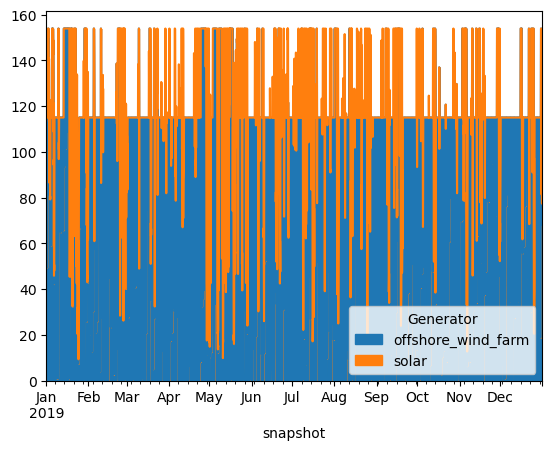

In [148]:
n.generators_t.p.plot(kind = 'area')

In [141]:
generator_power = n.generators_t.p
data_centre_power = n.loads_t.p["data_centre_load"]
battery_power = n.links_t.p1["bess_charger"] - n.links_t.p1["bess_discharger"]
asset_power = generator_power.copy()
asset_power["bess"] = battery_power
asset_power["dc_load"] = data_centre_power
asset_power

Generator,offshore_wind_farm,solar,bess,dc_load
snapshot,,,,
2019-01-01 00:00:00,115.000000,0.0,0.000000,115.0
2019-01-01 01:00:00,115.000000,0.0,0.000000,115.0
2019-01-01 02:00:00,115.000000,0.0,0.000000,115.0
2019-01-01 03:00:00,115.000000,0.0,0.000000,115.0
2019-01-01 04:00:00,115.000000,0.0,0.000000,115.0
...,...,...,...,...
2019-12-31 19:00:00,98.709058,0.0,16.290942,115.0
2019-12-31 20:00:00,114.981185,0.0,0.018815,115.0
2019-12-31 21:00:00,115.000000,0.0,0.000000,115.0


In [ ]:
generator_power = n.generators_t.p
data_centre_power = n.loads_t.p["data_centre_load"]
battery_power = n.links_t.p1["bess_charger"] - n.links_t.p1["bess_discharger"]
asset_power = generator_power.copy()
asset_power["bess"] = battery_power
asset_power["dc_load"] = data_centre_power
asset_power
asset_energy_mwh_per_day = asset_power.groupby(pd.Grouper(freq="D")).apply(lambda x: x.abs().sum().mul(
    MODEL_TIME_FREQUENCY.total_seconds() / 3600
))  # Convert power to energy (MWh)
asset_energy_mwh_per_month = asset_power.groupby(pd.Grouper(freq="M")).apply(lambda x: x.abs().sum().mul(
    MODEL_TIME_FREQUENCY.total_seconds() / 3600
))  # Convert power to energy (MWh)
asset_energy_mwh_per_day.head()
asset_energy_mwh_per_day = asset_energy_mwh_per_day[['solar', 'bess', 'offshore_wind_farm', 'dc_load']]
asset_energy_mwh_per_day

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_18283/2173132126.py:4: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



Generator,solar,bess,offshore_wind_farm,dc_load
snapshot,,,,
2019-01-01,0.000000,0.000000,2760.000000,2760.0
2019-01-02,0.000000,517.558662,3311.208817,2760.0
2019-01-03,119.482026,462.768053,2177.749921,2760.0
2019-01-04,0.000000,4.394215,2755.605785,2760.0
2019-01-05,0.000000,738.170502,3551.401848,2760.0
...,...,...,...,...
2019-12-27,0.000000,0.000000,2760.000000,2760.0
2019-12-28,0.000000,0.000000,2760.000000,2760.0
2019-12-29,0.000000,0.000000,2760.000000,2760.0


In [157]:
asset_energy_mwh_per_day.columns.to_list()

['solar', 'bess', 'offshore_wind_farm', 'dc_load']

In [160]:
# For each time period in the day, create a stacked bar chart showing the amount of energy used from each of the generators to meet the data centre load
fig = px.bar(
    data_frame=asset_energy_mwh_per_day,
    x=asset_energy_mwh_per_day.index,
    y=list(set(asset_energy_mwh_per_day.columns.to_list()) - {"dc_load"}),
    title="Energy Used from Each Generator to Meet Data Centre Load on Each Day of the Year",
    labels={"value": "Energy (MWh)", "variable": "Generator"},
    template="plotly_white",
    color_discrete_map={
        'solar': 'purple',
        "offshore_wind_farm": "lightgreen",
        "gas_turbine": "darkgrey",
        "bess": "orange"
    }
)
# Add a line for the data centre load
fig.add_scatter(
    x=asset_energy_mwh_per_day.index,
    y=asset_energy_mwh_per_day["dc_load"],
    mode="lines",
    name="Data Centre Load",
    line=dict(color="black", width=2),
)
'''
fig.add_layout_image(
    dict(
        source="https://centrefornetzero.org/static/media/logo.7e2e2e2e.svg",  # SVG logo from their website
        xref="paper", yref="paper",
        x=1, y=1,  # Top-right corner
        sizex=0.2, sizey=0.2,
        xanchor="right", yanchor="top",
        layer="above"
    )
)'''
fig.show()

# Running the solar and wind farm for the year 2023
Author: Katie Shaw, 
Date: August 13 

Notes on weather cutouts: I have outlined below under the heading "How to calculate the Renewable Profiles like they do in PyPSA EUR" the method by which to turn an available atlite cutout into a file that can determine the availability of a certain technology in termps of fractions of it's nominal power. It is IMPORTANT TO NOTE that these files come baked with assumptions about which technological parameters are used, which can be found in the default options of pypsa Europe: https://2050plus-climact.readthedocs.io/en/stable/configuration.html 

In [180]:
#wind and solar availability update 
##renewable profile for 2023
#the 2023 file from the respoitory above is for the year 2023
cutout_2023 = xr.load_dataset('/Users/katherine.shaw/Desktop/pypsa-eur/cutouts/europe-2023-sarah3-era5.nc') 
#cutout defined from pypsa eur dataset
#cutout can be downloaded from this zenedo repository : https://zenodo.org/records/12791128

#wind data 
wind_data = xr.load_dataset(
    "/Users/katherine.shaw/Desktop/pypsa-eur/resources/profile_39_offwind-dc.nc",
)
wind_profile_df = wind_data["profile"].to_dataframe().reset_index()
wind_availability_list = wind_profile_df[wind_profile_df["bus"] == "GB2 0"]["profile"].to_numpy()

#solar data 
solar_profile = xr.load_dataset('/Users/katherine.shaw/Desktop/pypsa-eur/resources/profile_39_solar.nc')
solar_availability_df = solar_profile['profile'].to_dataframe().reset_index()
solar_availability_df = solar_availability_df[solar_availability_df.bus == 'GB2 0']
solar_availability_df.reset_index()
solar_availability_df = solar_availability_df.profile
solar_availability = solar_availability_df.to_numpy()

#solar capital cost
solar_capex_per_mw = (700.13 * 1000) # originally given in EUR/kW_e, so had to multiply by 1000 to make /MW and also turn into £ to match wind cost units.  taken from pypsa eur cost files 
solar_discount_rate = wind_discount_rate
solar_lifetime_years = 35.0 #taken from pypsa eur cost files 
annuitised_solar_cost = (solar_capex_per_mw * solar_discount_rate) / (
    1 - (1 + solar_discount_rate) ** -solar_lifetime_years
)



In [181]:
n = gen_model_solar(data_centre_load_mw=DATA_CENTRE_LOAD_MW)
n = solve_model(n, solver_name="gurobi", print_results=True) #changed to gurobi from highs for Katie's runs because she has access to gurobi

Network consistency check passed before solving.


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 148.86it/s]
INFO:linopy.io: Writing time: 0.34s


Set parameter LicenseID to value 2648928


INFO:gurobipy:Set parameter LicenseID to value 2648928


Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-rf4k_ber.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/linopy-problem-rf4k_ber.lp


Reading time = 0.10 seconds


INFO:gurobipy:Reading time = 0.10 seconds


obj: 113885 rows, 52565 columns, 214160 nonzeros


INFO:gurobipy:obj: 113885 rows, 52565 columns, 214160 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.6.0 24G84)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.6.0 24G84)


INFO:gurobipy:


CPU model: Apple M4 Pro


INFO:gurobipy:CPU model: Apple M4 Pro


Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113885 rows, 52565 columns and 214160 nonzeros


INFO:gurobipy:Optimize a model with 113885 rows, 52565 columns and 214160 nonzeros


Model fingerprint: 0x051e1cba


INFO:gurobipy:Model fingerprint: 0x051e1cba


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-02, 1e+00]


INFO:gurobipy:  Matrix range     [1e-02, 1e+00]


  Objective range  [1e-03, 2e+05]


INFO:gurobipy:  Objective range  [1e-03, 2e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+02, 1e+02]


INFO:gurobipy:  RHS range        [1e+02, 1e+02]


Presolve removed 66170 rows and 13606 columns


INFO:gurobipy:Presolve removed 66170 rows and 13606 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 47715 rows, 38959 columns, 125625 nonzeros


INFO:gurobipy:Presolved: 47715 rows, 38959 columns, 125625 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 9.543e+04


INFO:gurobipy: AA' NZ     : 9.543e+04


 Factor NZ  : 6.245e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 6.245e+05 (roughly 40 MB of memory)


 Factor Ops : 8.904e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.904e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.01245783e+08  0.00000000e+00  9.63e+02 0.00e+00  5.64e+05     0s


INFO:gurobipy:   0   3.01245783e+08  0.00000000e+00  9.63e+02 0.00e+00  5.64e+05     0s


   1   6.30190485e+08 -4.55520201e+08  2.35e+02 1.24e+02  1.17e+05     0s


INFO:gurobipy:   1   6.30190485e+08 -4.55520201e+08  2.35e+02 1.24e+02  1.17e+05     0s


   2   5.02360979e+08 -1.54420385e+08  8.33e+00 1.46e+01  1.92e+04     0s


INFO:gurobipy:   2   5.02360979e+08 -1.54420385e+08  8.33e+00 1.46e+01  1.92e+04     0s


   3   3.71273683e+08 -3.13679896e+07  5.05e+00 5.17e+00  8.91e+03     0s


INFO:gurobipy:   3   3.71273683e+08 -3.13679896e+07  5.05e+00 5.17e+00  8.91e+03     0s


   4   2.76657839e+08  4.13446884e+07  2.79e+00 1.98e+00  4.55e+03     0s


INFO:gurobipy:   4   2.76657839e+08  4.13446884e+07  2.79e+00 1.98e+00  4.55e+03     0s


   5   2.56408123e+08  5.92072622e+07  2.70e+00 9.48e-01  3.39e+03     0s


INFO:gurobipy:   5   2.56408123e+08  5.92072622e+07  2.70e+00 9.48e-01  3.39e+03     0s


   6   2.18148771e+08  6.20277629e+07  2.05e+00 8.24e-01  2.70e+03     0s


INFO:gurobipy:   6   2.18148771e+08  6.20277629e+07  2.05e+00 8.24e-01  2.70e+03     0s


   7   2.17556236e+08  7.50230646e+07  1.92e+00 5.24e-01  2.35e+03     0s


INFO:gurobipy:   7   2.17556236e+08  7.50230646e+07  1.92e+00 5.24e-01  2.35e+03     0s


   8   1.98286365e+08  8.38003570e+07  1.10e+00 4.36e-01  1.87e+03     0s


INFO:gurobipy:   8   1.98286365e+08  8.38003570e+07  1.10e+00 4.36e-01  1.87e+03     0s


   9   1.93751248e+08  8.47173113e+07  1.05e+00 4.00e-01  1.78e+03     0s


INFO:gurobipy:   9   1.93751248e+08  8.47173113e+07  1.05e+00 4.00e-01  1.78e+03     0s


  10   1.62843255e+08  8.74392702e+07  6.75e-01 3.47e-01  1.28e+03     0s


INFO:gurobipy:  10   1.62843255e+08  8.74392702e+07  6.75e-01 3.47e-01  1.28e+03     0s


  11   1.55387823e+08  9.23795886e+07  5.74e-01 2.22e-01  1.03e+03     0s


INFO:gurobipy:  11   1.55387823e+08  9.23795886e+07  5.74e-01 2.22e-01  1.03e+03     0s


  12   1.50945449e+08  9.75732060e+07  4.54e-01 1.68e-01  8.65e+02     0s


INFO:gurobipy:  12   1.50945449e+08  9.75732060e+07  4.54e-01 1.68e-01  8.65e+02     0s


  13   1.49850288e+08  9.98346553e+07  4.37e-01 1.51e-01  8.07e+02     0s


INFO:gurobipy:  13   1.49850288e+08  9.98346553e+07  4.37e-01 1.51e-01  8.07e+02     0s


  14   1.48845594e+08  1.04925441e+08  4.20e-01 1.19e-01  7.02e+02     0s


INFO:gurobipy:  14   1.48845594e+08  1.04925441e+08  4.20e-01 1.19e-01  7.02e+02     0s


  15   1.46863910e+08  1.10948604e+08  2.76e-01 9.46e-02  5.76e+02     0s


INFO:gurobipy:  15   1.46863910e+08  1.10948604e+08  2.76e-01 9.46e-02  5.76e+02     0s


  16   1.43882971e+08  1.16669110e+08  2.21e-01 7.06e-02  4.37e+02     0s


INFO:gurobipy:  16   1.43882971e+08  1.16669110e+08  2.21e-01 7.06e-02  4.37e+02     0s


  17   1.41910706e+08  1.19630630e+08  1.76e-01 5.72e-02  3.57e+02     0s


INFO:gurobipy:  17   1.41910706e+08  1.19630630e+08  1.76e-01 5.72e-02  3.57e+02     0s


  18   1.41798133e+08  1.19924305e+08  1.74e-01 5.59e-02  3.51e+02     0s


INFO:gurobipy:  18   1.41798133e+08  1.19924305e+08  1.74e-01 5.59e-02  3.51e+02     0s


  19   1.40990720e+08  1.19981922e+08  1.66e-01 5.55e-02  3.39e+02     0s


INFO:gurobipy:  19   1.40990720e+08  1.19981922e+08  1.66e-01 5.55e-02  3.39e+02     0s


  20   1.39429965e+08  1.20693820e+08  1.46e-01 5.17e-02  3.05e+02     0s


INFO:gurobipy:  20   1.39429965e+08  1.20693820e+08  1.46e-01 5.17e-02  3.05e+02     0s


  21   1.37642478e+08  1.21583061e+08  1.12e-01 4.64e-02  2.63e+02     0s


INFO:gurobipy:  21   1.37642478e+08  1.21583061e+08  1.12e-01 4.64e-02  2.63e+02     0s


  22   1.37280120e+08  1.21886189e+08  1.05e-01 4.48e-02  2.52e+02     0s


INFO:gurobipy:  22   1.37280120e+08  1.21886189e+08  1.05e-01 4.48e-02  2.52e+02     0s


  23   1.36747647e+08  1.23971497e+08  8.29e-02 3.41e-02  2.08e+02     0s


INFO:gurobipy:  23   1.36747647e+08  1.23971497e+08  8.29e-02 3.41e-02  2.08e+02     0s


  24   1.37163872e+08  1.25598582e+08  6.40e-02 2.74e-02  1.85e+02     0s


INFO:gurobipy:  24   1.37163872e+08  1.25598582e+08  6.40e-02 2.74e-02  1.85e+02     0s


  25   1.36597321e+08  1.28303482e+08  1.39e-02 1.81e-02  1.32e+02     0s


INFO:gurobipy:  25   1.36597321e+08  1.28303482e+08  1.39e-02 1.81e-02  1.32e+02     0s


  26   1.35766064e+08  1.31332831e+08  6.21e-03 7.91e-03  6.96e+01     0s


INFO:gurobipy:  26   1.35766064e+08  1.31332831e+08  6.21e-03 7.91e-03  6.96e+01     0s


  27   1.35637491e+08  1.32655178e+08  4.33e-03 4.59e-03  4.63e+01     0s


INFO:gurobipy:  27   1.35637491e+08  1.32655178e+08  4.33e-03 4.59e-03  4.63e+01     0s


  28   1.35194436e+08  1.33337506e+08  2.12e-03 3.02e-03  2.90e+01     0s


INFO:gurobipy:  28   1.35194436e+08  1.33337506e+08  2.12e-03 3.02e-03  2.90e+01     0s


  29   1.35018792e+08  1.33997226e+08  4.33e-05 1.68e-03  1.59e+01     0s


INFO:gurobipy:  29   1.35018792e+08  1.33997226e+08  4.33e-05 1.68e-03  1.59e+01     0s


  30   1.34995082e+08  1.34501864e+08  3.69e-05 6.05e-04  7.59e+00     0s


INFO:gurobipy:  30   1.34995082e+08  1.34501864e+08  3.69e-05 6.05e-04  7.59e+00     0s


  31   1.34921035e+08  1.34595585e+08  1.64e-05 4.21e-04  5.03e+00     0s


INFO:gurobipy:  31   1.34921035e+08  1.34595585e+08  1.64e-05 4.21e-04  5.03e+00     0s


  32   1.34886062e+08  1.34807485e+08  5.81e-06 8.61e-05  1.20e+00     0s


INFO:gurobipy:  32   1.34886062e+08  1.34807485e+08  5.81e-06 8.61e-05  1.20e+00     0s


  33   1.34872367e+08  1.34845070e+08  3.21e-06 3.13e-05  4.20e-01     1s


INFO:gurobipy:  33   1.34872367e+08  1.34845070e+08  3.21e-06 3.13e-05  4.20e-01     1s


  34   1.34872829e+08  1.34851720e+08  1.31e-05 2.22e-05  3.23e-01     1s


INFO:gurobipy:  34   1.34872829e+08  1.34851720e+08  1.31e-05 2.22e-05  3.23e-01     1s


  35   1.34870055e+08  1.34861306e+08  4.01e-05 8.23e-06  1.33e-01     1s


INFO:gurobipy:  35   1.34870055e+08  1.34861306e+08  4.01e-05 8.23e-06  1.33e-01     1s


  36   1.34868436e+08  1.34866731e+08  2.17e-06 6.45e-08  2.55e-02     1s


INFO:gurobipy:  36   1.34868436e+08  1.34866731e+08  2.17e-06 6.45e-08  2.55e-02     1s


  37   1.34868189e+08  1.34867190e+08  9.26e-07 4.03e-08  1.49e-02     1s


INFO:gurobipy:  37   1.34868189e+08  1.34867190e+08  9.26e-07 4.03e-08  1.49e-02     1s


  38   1.34868060e+08  1.34867630e+08  6.53e-07 5.53e-10  6.40e-03     1s


INFO:gurobipy:  38   1.34868060e+08  1.34867630e+08  6.53e-07 5.53e-10  6.40e-03     1s


  39   1.34868000e+08  1.34867847e+08  9.28e-07 3.49e-10  2.28e-03     1s


INFO:gurobipy:  39   1.34868000e+08  1.34867847e+08  9.28e-07 3.49e-10  2.28e-03     1s


  40   1.34867956e+08  1.34867899e+08  2.99e-07 8.73e-11  8.48e-04     1s


INFO:gurobipy:  40   1.34867956e+08  1.34867899e+08  2.99e-07 8.73e-11  8.48e-04     1s


  41   1.34867944e+08  1.34867913e+08  1.38e-07 0.00e+00  4.50e-04     1s


INFO:gurobipy:  41   1.34867944e+08  1.34867913e+08  1.38e-07 0.00e+00  4.50e-04     1s


  42   1.34867939e+08  1.34867920e+08  8.86e-08 7.82e-11  2.77e-04     1s


INFO:gurobipy:  42   1.34867939e+08  1.34867920e+08  8.86e-08 7.82e-11  2.77e-04     1s


  43   1.34867934e+08  1.34867924e+08  3.27e-08 5.24e-10  1.42e-04     1s


INFO:gurobipy:  43   1.34867934e+08  1.34867924e+08  3.27e-08 5.24e-10  1.42e-04     1s


  44   1.34867931e+08  1.34867927e+08  4.48e-08 2.62e-10  5.74e-05     1s


INFO:gurobipy:  44   1.34867931e+08  1.34867927e+08  4.48e-08 2.62e-10  5.74e-05     1s


  45   1.34867930e+08  1.34867928e+08  3.23e-08 0.00e+00  3.32e-05     1s


INFO:gurobipy:  45   1.34867930e+08  1.34867928e+08  3.23e-08 0.00e+00  3.32e-05     1s


  46   1.34867930e+08  1.34867929e+08  1.56e-08 2.47e-10  1.76e-05     1s


INFO:gurobipy:  46   1.34867930e+08  1.34867929e+08  1.56e-08 2.47e-10  1.76e-05     1s


INFO:gurobipy:


Barrier solved model in 46 iterations and 0.65 seconds (1.14 work units)


INFO:gurobipy:Barrier solved model in 46 iterations and 0.65 seconds (1.14 work units)


Optimal objective 1.34867930e+08


INFO:gurobipy:Optimal objective 1.34867930e+08


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


      31 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:      31 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


   20429 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:   20429 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2447676e-02      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2447676e-02      1s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   20459    1.3486793e+08   0.000000e+00   1.244767e-02      1s


INFO:gurobipy:   20459    1.3486793e+08   0.000000e+00   1.244767e-02      1s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


   20507    1.3486793e+08   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   20507    1.3486793e+08   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 20507 iterations and 0.80 seconds (1.30 work units)


INFO:gurobipy:Solved in 20507 iterations and 0.80 seconds (1.30 work units)


Optimal objective  1.348679296e+08


INFO:gurobipy:Optimal objective  1.348679296e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52565 primals, 113885 duals
Objective: 1.35e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


Model solved successfully.

--- Optimization Results ---
Objective Value: 134867929.63 £ (Total Cost)

Optimal Capacities:
  Offshore Wind Farm (p_nom_opt): 244.62 MW
  BESS Storage Energy Capacity (e_nom_opt): 3409.49 MWh
  BESS Charger Power Capacity (p_nom_opt): 72.28 MW
  BESS Discharger Power Capacity (p_nom_opt): 116.71 MW


In [182]:
n.generators.p_nom_opt

Generator
offshore_wind_farm    244.618181
solar                 419.888618
Name: p_nom_opt, dtype: float64

In [183]:
generator_power = n.generators_t.p
data_centre_power = n.loads_t.p["data_centre_load"]
battery_power = n.links_t.p1["bess_charger"] - n.links_t.p1["bess_discharger"]
asset_power = generator_power.copy()
asset_power["bess"] = battery_power
asset_power["dc_load"] = data_centre_power
asset_power
asset_energy_mwh_per_day = asset_power.groupby(pd.Grouper(freq="D")).apply(lambda x: x.abs().sum().mul(
    MODEL_TIME_FREQUENCY.total_seconds() / 3600
))  # Convert power to energy (MWh)
asset_energy_mwh_per_month = asset_power.groupby(pd.Grouper(freq="M")).apply(lambda x: x.abs().sum().mul(
    MODEL_TIME_FREQUENCY.total_seconds() / 3600
))  # Convert power to energy (MWh)
asset_energy_mwh_per_day.head()
asset_energy_mwh_per_day = asset_energy_mwh_per_day[['solar', 'bess', 'offshore_wind_farm', 'dc_load']]
asset_energy_mwh_per_day


# For each time period in the day, create a stacked bar chart showing the amount of energy used from each of the generators to meet the data centre load
fig = px.bar(
    data_frame=asset_energy_mwh_per_day,
    x=asset_energy_mwh_per_day.index,
    y=list(set(asset_energy_mwh_per_day.columns.to_list()) - {"dc_load"}),
    title="Energy Used from Each Generator to Meet Data Centre Load on Each Day of the Year",
    labels={"value": "Energy (MWh)", "variable": "Generator"},
    template="plotly_white",
    color_discrete_map={
        'solar': 'purple',
        "offshore_wind_farm": "lightgreen",
        "gas_turbine": "darkgrey",
        "bess": "orange"
    }
)
# Add a line for the data centre load
fig.add_scatter(
    x=asset_energy_mwh_per_day.index,
    y=asset_energy_mwh_per_day["dc_load"],
    mode="lines",
    name="Data Centre Load",
    line=dict(color="black", width=2),
)
'''
fig.add_layout_image(
    dict(
        source="https://centrefornetzero.org/static/media/logo.7e2e2e2e.svg",  # SVG logo from their website
        xref="paper", yref="paper",
        x=1, y=1,  # Top-right corner
        sizex=0.2, sizey=0.2,
        xanchor="right", yanchor="top",
        layer="above"
    )
)'''
fig.show()

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_18283/3340708648.py:11: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



## How to calculate the Renewable Profiles like they do in PyPSA EUR. 


weather cutouts can be downloaded from this zenodo repository: https://zenodo.org/records/12791128 

These files are merged spatiotemporal subsets of the European weather data from the ECMWF ERA5 realanlysis dataset and CMSAF SARAH-3 solar radiation dataset compiled by the atlite tool by various authors of PyPSA Eur 

In [ ]:
##renewable profile for 2023
#the 2023 file from the respoitory above is for the year 2023
cutout_2023 = xr.load_dataset('/Users/katherine.shaw/Desktop/pypsa-eur/cutouts/europe-2023-sarah3-era5.nc') #cutout defined from pypsa eur dataset
cutout_2023

<xarray.Dataset> Size: 13GB
Dimensions:           (x: 177, y: 131, time: 8760)
Coordinates:
  * x                 (x) float64 1kB -12.0 -11.7 -11.4 -11.1 ... 40.2 40.5 40.8
  * y                 (y) float64 1kB 33.0 33.3 33.6 33.9 ... 71.4 71.7 72.0
  * time              (time) datetime64[ns] 70kB 2023-01-01 ... 2023-12-31T23...
    lon               (x) float64 1kB -12.0 -11.7 -11.4 -11.1 ... 40.2 40.5 nan
    lat               (y) float64 1kB 33.0 33.3 33.6 33.9 ... nan nan nan nan
Data variables: (12/13)
    influx_direct     (time, y, x) float32 812MB 0.0 0.0 0.0 0.0 ... nan nan nan
    influx_diffuse    (time, y, x) float32 812MB 0.0 0.0 0.0 0.0 ... nan nan nan
    solar_altitude    (time, y, x) float64 2GB -1.308 -1.312 -1.315 ... nan nan
    solar_azimuth     (time, y, x) float64 2GB 5.379 5.392 5.406 ... nan nan nan
    height            (y, x) float32 93kB 0.85 0.737 -0.3181 ... -0.5066 0.02101
    wnd100m           (time, y, x) float32 812MB 7.779 7.247 ... 2.783 3.133
    ...                ...
    roughness         (time, y, x) float32 812MB 8.035e-05 ... 2.426e-05
    influx_toa        (time, y, x) float32 812MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    albedo            (time, y, x) float32 812MB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    temperature       (time, y, x) float64 2GB 293.3 293.1 293.2 ... 271.1 271.1
    soil temperature  (time, y, x) float64 2GB 293.4 293.3 293.4 ... 275.7 275.8
    runoff            (time, y, x) float32 812MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/46)
    module:                     ['era5', 'sarah']
    prepared_features:          ['height', 'influx', 'runoff', 'temperature',...
    chunksize_lat:              -1
    chunksize_time:             100
    sarah_dir:                  data
    dx:                         0.3
    ...                         ...
    platform:                   Earth Observation Satellites > METEOSAT > MET...
    instrument_vocabulary:      GCMD Instruments, Version 8.6
    instrument:                 SEVIRI > Spinning Enhanced Visible and Infrar...
    variable_id:                SIS
    license:                    The CM SAF data are owned by EUMETSAT and are...
    history:                    2024-03-04 22:58:37 GMT by grib_to_netcdf-2.2...

In [168]:
import atlite
sns = get_snapshots(snapshots, drop_leap_day=False)
cutout_filepath = '/Users/katherine.shaw/Desktop/pypsa-eur/cutouts/europe-2023-sarah3-era5.nc'
atlite.Cutout(cutout_filepath).sel(time=sns)

KeyError: "not all values found in index 'time'"

The following script is modified from the build_renewable_profiles.py file in scripts of PyPSA-EUR. Running just soley this element of PYSPA-EUR caused issues with time alignment, thus I've replicated it here. This can also be used for any further edits of the microgrid project without fully diving into PyPSA EUR 

In [ ]:
### Documentation for Use in PyPSA-EUR 

# SPDX-FileCopyrightText: Contributors to PyPSA-Eur <https://github.com/pypsa/pypsa-eur>
#
# SPDX-License-Identifier: MIT
"""
Calculates for each clustered region the (i) installable capacity (based on
land-use from :mod:`determine_availability_matrix`), (ii) the available
generation time series (based on weather data), and (iii) the average distance
from the node for onshore wind, AC-connected offshore wind, DC-connected
offshore wind and solar PV generators.

.. note:: Hydroelectric profiles are built in script :mod:`build_hydro_profiles`.

Outputs
-------

- ``resources/profile_{technology}.nc`` with the following structure

    ===================  ==========  =========================================================
    Field                Dimensions  Description
    ===================  ==========  =========================================================
    profile              bus, time   the per unit hourly availability factors for each bus
    -------------------  ----------  ---------------------------------------------------------
    p_nom_max            bus         maximal installable capacity at the bus (in MW)
    -------------------  ----------  ---------------------------------------------------------
    average_distance     bus         average distance of units in the region to the
                                     grid bus for onshore technologies and to the shoreline
                                     for offshore technologies (in km)
    ===================  ==========  =========================================================

    - **profile**

    .. image:: img/profile_ts.png
        :scale: 33 %
        :align: center

    - **p_nom_max**

    .. image:: img/p_nom_max_hist.png
        :scale: 33 %
        :align: center

    - **average_distance**

    .. image:: img/distance_hist.png
        :scale: 33 %
        :align: center

Description
-----------

This script functions at two main spatial resolutions: the resolution of the
clustered network regions, and the resolution of the cutout grid cells for the
weather data. Typically the weather data grid is finer than the network regions,
so we have to work out the distribution of generators across the grid cells
within each region. This is done by taking account of a combination of the
available land at each grid cell (computed in
:mod:`determine_availability_matrix`) and the capacity factor there.

Based on the availability matrix, the script first computes how much of the
technology can be installed at each cutout grid cell. To compute the layout of
generators in each clustered region, the installable potential in each grid cell
is multiplied with the capacity factor at each grid cell. This is done since we
assume more generators are installed at cells with a higher capacity factor.

.. image:: img/offwinddc-gridcell.png
    :scale: 50 %
    :align: center

.. image:: img/offwindac-gridcell.png
    :scale: 50 %
    :align: center

.. image:: img/onwind-gridcell.png
    :scale: 50 %
    :align: center

.. image:: img/solar-gridcell.png
    :scale: 50 %
    :align: center

This layout is then used to compute the generation availability time series from
the weather data cutout from ``atlite``.

The maximal installable potential for the node (`p_nom_max`) is computed by
adding up the installable potentials of the individual grid cells.
"""



In [ ]:
#connection timeout with this code, but the layout should be correct.
import time

import atlite
import geopandas as gpd
import xarray as xr
#from _helpers import configure_logging, get_snapshots, set_scenario_config
#from build_shapes import _simplify_polys
from dask.distributed import Client

#from build shapes
from itertools import takewhile
from operator import attrgetter

import country_converter as coco
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
import xarray as xr
from rasterio.mask import mask
from shapely.geometry import MultiPolygon, Polygon, box

#logger = logging.getLogger(__name__)

#from other pypsa EUR files like _helpers
renewable_technologies = {
    "onwind": {
        "cutout": "europe-2013-sarah3-era5",
        "resource": {
            "method": "wind",
            "turbine": "Vestas_V112_3MW",
            "smooth": False,
            "add_cutout_windspeed": True
        },
        "capacity_per_sqkm": 3,
        # "correction_factor": 0.93,
        "corine": {
            "grid_codes": [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32],
            "distance": 1000,
            "distance_grid_codes": [1, 2, 3, 4, 5, 6]
        },
        "luisa": False,
        # "luisa": {
        #     "grid_codes": [1111, 1121, 1122, 1123, 1130, 1210, 1221, 1222, 1230, 1241, 1242],
        #     "distance": 1000,
        #     "distance_grid_codes": [1111, 1121, 1122, 1123, 1130, 1210, 1221, 1222, 1230, 1241, 1242]
        # },
        "natura": True,
        "excluder_resolution": 100,
        "clip_p_max_pu": 1e-2
    },
    "offwind-ac": {
        "cutout": "europe-2013-sarah3-era5",
        "resource": {
            "method": "wind",
            "turbine": "NREL_ReferenceTurbine_2020ATB_5.5MW",
            "smooth": False,
            "add_cutout_windspeed": True
        },
        "capacity_per_sqkm": 2,
        "correction_factor": 0.8855,
        "corine": [44, 255],
        "luisa": False,  # [0, 5230]
        "natura": True,
        "ship_threshold": 400,
        "max_depth": 60,
        "max_shore_distance": 30000,
        "excluder_resolution": 200,
        "clip_p_max_pu": 1e-2,
        "landfall_length": 10
    },
    "offwind-dc": {
        "cutout": "europe-2013-sarah3-era5",
        "resource": {
            "method": "wind",
            "turbine": "NREL_ReferenceTurbine_2020ATB_5.5MW",
            "smooth": False,
            "add_cutout_windspeed": True
        },
        "capacity_per_sqkm": 2,
        "correction_factor": 0.8855,
        "corine": [44, 255],
        "luisa": False,  # [0, 5230]
        "natura": True,
        "ship_threshold": 400,
        "max_depth": 60,
        "min_shore_distance": 30000,
        "excluder_resolution": 200,
        "clip_p_max_pu": 1e-2,
        "landfall_length": 10
    },
    "offwind-float": {
        "cutout": "europe-2013-sarah3-era5",
        "resource": {
            "method": "wind",
            "turbine": "NREL_ReferenceTurbine_5MW_offshore",
            "smooth": False,
            "add_cutout_windspeed": True
        },
        "capacity_per_sqkm": 2,
        "correction_factor": 0.8855,
        "corine": [44, 255],
        "natura": True,
        "ship_threshold": 400,
        "excluder_resolution": 200,
        "min_depth": 60,
        "max_depth": 1000,
        "clip_p_max_pu": 1e-2,
        "landfall_length": 10
    },
    "solar": {
        "cutout": "europe-2013-sarah3-era5",
        "resource": {
            "method": "pv",
            "panel": "CSi",
            "orientation": {
                "slope": 35.0,
                "azimuth": 180.0
            }
        },
        "capacity_per_sqkm": 5.1,
        # "correction_factor": 0.854337,
        "corine": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 26, 31, 32],
        "luisa": False,  # [1111, ..., 3330]
        "natura": True,
        "excluder_resolution": 100,
        "clip_p_max_pu": 1e-2
    },
    "solar-hsat": {
        "cutout": "europe-2013-sarah3-era5",
        "resource": {
            "method": "pv",
            "panel": "CSi",
            "orientation": {
                "slope": 35.0,
                "azimuth": 180.0,
                "tracking": "horizontal"
            }
        },
        "capacity_per_sqkm": 4.43,
        "corine": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 26, 31, 32],
        "luisa": False,  # [1111, ..., 3330]
        "natura": True,
        "excluder_resolution": 100,
        "clip_p_max_pu": 1e-2
    },
    "hydro": {
        "cutout": "europe-2013-sarah3-era5",
        "carriers": ["ror", "PHS", "hydro"],
        "PHS_max_hours": 6,
        "hydro_max_hours": "energy_capacity_totals_by_country",  # or estimate_by_large_installations, or float
        "flatten_dispatch": False,
        "flatten_dispatch_buffer": 0.2,
        "clip_min_inflow": 1.0,
        "eia_norm_year": False,
        "eia_correct_by_capacity": False,
        "eia_approximate_missing": False
    }
}
def get_snapshots(snapshots, drop_leap_day=False, freq="h", **kwargs):
    """
    Returns pandas DateTimeIndex potentially without leap days.
    """

    time = pd.date_range(freq=freq, **snapshots, **kwargs)
    if drop_leap_day and time.is_leap_year.any():
        time = time[~((time.month == 2) & (time.day == 29))]

    return time
def _simplify_polys(
    polys, minarea=100 * 1e6, maxdistance=None, tolerance=None, filterremote=True
):  # 100*1e6 = 100 km² if CRS is DISTANCE_CRS
    if isinstance(polys, MultiPolygon):
        polys = sorted(polys.geoms, key=attrgetter("area"), reverse=True)
        mainpoly = polys[0]
        mainlength = np.sqrt(mainpoly.area / (2.0 * np.pi))

        if maxdistance is not None:
            mainlength = maxdistance

        if mainpoly.area > minarea:
            polys = MultiPolygon(
                [
                    p
                    for p in takewhile(lambda p: p.area > minarea, polys)
                    if not filterremote or (mainpoly.distance(p) < mainlength)
                ]
            )
        else:
            polys = mainpoly
    if tolerance is not None:
        polys = polys.simplify(tolerance=tolerance)
    return polys

#options from configuration file 
technology_choice = 'offwind-dc'
snakemake_threads = 4 
snakemake_snapshots = ['']
snapshots = {
  'start': "2023-01-01",
  'end': "2024-01-01",
  'inclusive': 'left',
}
cutout_filepath = '/Users/katherine.shaw/Desktop/pypsa-eur/cutouts/europe-2023-sarah3-era5.nc'
availability_matrix_filepath_dc = '/Users/katherine.shaw/Desktop/pypsa-eur/resources/availability_matrix_39_offwind-dc.nc'
snakemake_input_regions = '/Users/katherine.shaw/Desktop/pypsa-eur/resources/regions_offshore_base_s_39.geojson'

nprocesses = snakemake_threads #int(snakemake.threads)
technology = technology_choice 
params = renewable_technologies[technology]
resource = params["resource"]  # pv panel params / wind turbine params

tech = next(t for t in ["panel", "turbine"] if t in resource)
models = resource[tech]
if not isinstance(models, dict):
    models = {0: models}
resource[tech] = models[next(iter(models))]

correction_factor = params.get("correction_factor", 1.0)
capacity_per_sqkm = params["capacity_per_sqkm"]

if correction_factor != 1.0:
    print(f"correction_factor is set as {correction_factor}")

if nprocesses > 1:
    client = Client(n_workers=nprocesses, threads_per_worker=1)
else:
    client = None

sns = get_snapshots(snapshots, drop_leap_day=False)

cutout = atlite.Cutout(cutout_filepath).sel(time=sns)

availability = xr.open_dataarray(availability_matrix_filepath_dc) #this is a file made my pypsa_eur 

regions = gpd.read_file(snakemake_input_regions) #this is also a file make by pypsa year
assert not regions.empty, (
    f"List of regions in {snakemake_input_regions} is empty, please "
    "disable the corresponding renewable technology"
)
# do not pull up, set_index does not work if geo dataframe is empty
regions = regions.set_index("name").rename_axis("bus")
if technology_choice.startswith("offwind"):
    # for offshore regions, the shortest distance to the shoreline is used
    offshore_regions = availability.coords["bus"].values
    regions = regions.loc[offshore_regions]
    regions = regions.map(lambda g: _simplify_polys(g, minarea=1)).set_crs(
        regions.crs
    )
else:
    # for onshore regions, the representative point of the region is used
    regions = regions.representative_point()
    regions = regions.geometry.to_crs(3035)
    buses = regions.index

    area = cutout.grid.to_crs(3035).area / 1e6
    area = xr.DataArray(
        area.values.reshape(cutout.shape), [cutout.coords["y"], cutout.coords["x"]]
    )

    func = getattr(cutout, resource.pop("method"))
    if client is not None:
        resource["dask_kwargs"] = {"scheduler": client}

    print(f"Calculate average capacity factor for technology {technology}...")
    start = time.time()

    capacity_factor = correction_factor * func(capacity_factor=True, **resource)
    layout = capacity_factor * area * capacity_per_sqkm

    duration = time.time() - start
    print(
        f"Completed average capacity factor calculation for technology {technology} ({duration:2.2f}s)"
    )

    profiles = []
    for year, model in models.items():
        print(
            f"Calculate weighted capacity factor time series for model {model} for technology {technology}..."
        )
        start = time.time()

        resource[tech] = model

        profile = func(
            matrix=availability.stack(spatial=["y", "x"]),
            layout=layout,
            index=buses,
            per_unit=True,
            return_capacity=False,
            **resource,
        )

        dim = {"year": [year]}
        profile = profile.expand_dims(dim)

        profiles.append(profile.rename("profile"))

        duration = time.time() - start
        print(
            f"Completed weighted capacity factor time series calculation for model {model} for technology {technology} ({duration:2.2f}s)"
        )

    profiles = xr.merge(profiles)

    print(f"Calculating maximal capacity per bus for technology {technology}")
    p_nom_max = capacity_per_sqkm * availability @ area

    print(f"Calculate average distances for technology {technology}.")
    layoutmatrix = (layout * availability).stack(spatial=["y", "x"])

    coords = cutout.grid.representative_point().to_crs(3035)

    average_distance = []
    for bus in buses:
        row = layoutmatrix.sel(bus=bus).data
        nz_b = row != 0
        row = row[nz_b]
        co = coords[nz_b]
        distances = co.distance(regions[bus]).div(1e3)  # km
        average_distance.append((distances * (row / row.sum())).sum())

    average_distance = xr.DataArray(average_distance, [buses])

    ds = xr.merge(
        [
            correction_factor * profiles,
            p_nom_max.rename("p_nom_max"),
            average_distance.rename("average_distance"),
        ]
    )
    # select only buses with some capacity and minimal capacity factor
    mean_profile = ds["profile"].mean("time")
    if "year" in ds.indexes:
        mean_profile = mean_profile.max("year")

    ds = ds.sel(
        bus=(
            (mean_profile > params.get("min_p_max_pu", 0.0))
            & (ds["p_nom_max"] > params.get("min_p_nom_max", 0.0))
        )
    )

    if "clip_p_max_pu" in params:
        min_p_max_pu = params["clip_p_max_pu"]
        ds["profile"] = ds["profile"].where(ds["profile"] >= min_p_max_pu, 0)

    
    if client is not None:
        client.shutdown()


/Users/katherine.shaw/miniconda3/envs/pypsa-eur/lib/python3.12/site-packages/distributed/node.py:187: UserWarning:

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 56844 instead

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:56845
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:56844/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:56848'


correction_factor is set as 0.8855


INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:56850'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:56852'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:56854'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:56859 name: 2
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:56859
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:56865
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:56858 name: 3
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:56858
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:56867
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:56857 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:56857
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:56864
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:56856

INFO:distributed.core:Event loop was unresponsive in Scheduler for 1027.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 1027.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 1027.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 1027.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 1027.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This ca

# Plan for the future
1. Initialise data centre load as a constant
2. Loop through wind farms with capacities at different multiple factors of the data centre.
3. Assume constant things like capex cost and capacity factor for wind. We can do a sensitivity analysis of these later.
4. v1: Assume no battery? v2: Assume battery as a MWh of the multiple of the data centre load too.
5. Solve the model to get the least cost way of operating it with gas + battery in each setup. Calculate the % of the total data centre load that was met by gas. Crude calcualtion = MWh of gas / MWh of data centre throughout the year?


## Some options for analysis
* GIVEN a constant data centre load and GIVEN some historical wind profile. Q: How big should the battery and wind farm be priortional to the data centre load to cost-optimally run the system? How much does it cost to run that system? How would that compare to covering the data centre load via a nuclear PPA?
* Alternative route: Given different configurations of wind sizes, but allowing gas to be as much as is needed to cover the data centre load, how much does it cost to run each of those systems? Compared to nuclear PPA?